# Snapping points to lines and identifying streets with the most street flooding complaints

Mark Bauer

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import geopandas as gpd
import fiona
from fiona.crs import from_epsg
import contextily as ctx

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing verions of Python modules and packages with **watermark** - the IPython magic extension.

In [162]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [163]:
%watermark -v -p numpy,pandas,geopandas,matplotlib.pyplot,matplotlib,seaborn,fiona,contextily

CPython 3.7.1
IPython 7.18.1

numpy 1.19.2
pandas 1.0.0
geopandas 0.8.1
matplotlib.pyplot 3.3.2
matplotlib 3.3.2
seaborn 0.11.0
fiona 1.8.13.post1
contextily 1.0.0


Documention for installing watermark: https://github.com/rasbt/watermark

# 2. Loading Data

In [164]:
# list items in data folder
%ls data/

311-flooding-data.csv  streets_clipped.json


In [165]:
# read data as a dataframe
flooding_311 = pd.read_csv('data/311-flooding-data.csv')

# previewing first five rows in data
print(flooding_311.shape)
flooding_311.head()

(27817, 34)


/Users/geribauer/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


unique_key             created_date              closed_date agency  \
0    40140533  2018-08-29T08:35:00.000  2018-09-08T12:40:00.000    DEP   
1    40141782  2018-08-29T10:29:00.000  2018-08-30T09:40:00.000    DEP   
2    40143144  2018-08-29T18:36:00.000  2018-09-01T08:40:00.000    DEP   
3    40145580  2018-08-30T14:58:00.000  2018-09-04T11:25:00.000    DEP   
4    40148030  2018-08-30T19:37:00.000  2018-09-05T08:30:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip        incident_address  \
0  Street Flooding (SJ)       10034.0                     NaN   
1  Street Flooding (SJ)       11235.0     2468 EAST 27 STREET   
2  Street Flooding (SJ)       10458.0  2641 BAINBRIDGE AVENUE   
3  Street Flooding (SJ)       11204.0          1701 59 STREET   
4  Street Flooding (SJ)       11208.0         103 PINE STREET   

         street_name  ... park_facility_name park_borough   latitude  \
0                NaN  ...        Unspecified    MANHATTAN  40.863021   
1     EAST 27 STREET  ...        Unspecified     BROOKLYN  40.592140   
2  BAINBRIDGE AVENUE  ...        Unspecified        BRONX  40.864814   
3          59 STREET  ...        Unspecified     BROOKLYN  40.623757   
4        PINE STREET  ...        Unspecified     BROOKLYN  40.684147   

   longitude                                           location  \
0 -73.917557  {'latitude': '40.8630205', 'longitude': '-73.9...   
1 -73.943240  {'latitude': '40.5921398', 'longitude': '-73.9...   
2 -73.892048  {'latitude': '40.8648137', 'longitude': '-73.8...   
3 -73.988545  {'latitude': '40.6237568', 'longitude': '-73.9...   
4 -73.873386  {'latitude': '40.684147', 'longitude': '-73.87...   

  intersection_street_1 intersection_street_2 location_type due_date  landmark  
0       WEST 206 STREET              9 AVENUE           NaN      NaN       NaN  
1                   NaN                   NaN           NaN      NaN       NaN  
2                   NaN                   NaN           NaN      NaN       NaN  
3                   NaN                   NaN           NaN      NaN       NaN  
4                   NaN                   NaN           NaN      NaN       NaN  

[5 rows x 34 columns]

In [166]:
# previewing the last five rows of our dataframe
flooding_311.tail()

unique_key             created_date              closed_date agency  \
27812    40117057  2018-08-27T13:20:00.000  2018-08-28T08:30:00.000    DEP   
27813    40126539  2018-08-28T23:04:00.000  2018-09-17T09:20:00.000    DEP   
27814    40127389  2018-08-28T16:15:00.000  2018-09-13T11:10:00.000    DEP   
27815    40130007  2018-08-28T23:17:00.000  2018-08-29T11:10:00.000    DEP   
27816    40135555  2018-08-29T13:10:00.000  2018-09-17T10:20:00.000    DEP   

                                  agency_name complaint_type  \
27812  Department of Environmental Protection          Sewer   
27813  Department of Environmental Protection          Sewer   
27814  Department of Environmental Protection          Sewer   
27815  Department of Environmental Protection          Sewer   
27816  Department of Environmental Protection          Sewer   

                 descriptor  incident_zip            incident_address  \
27812  Street Flooding (SJ)       11360.0  28-29 CLEARVIEW EXPRESSWAY   
27813  Street Flooding (SJ)       10039.0         157 WEST 147 STREET   
27814  Street Flooding (SJ)       11418.0                   85 AVENUE   
27815  Street Flooding (SJ)       10452.0                         NaN   
27816  Street Flooding (SJ)       10029.0                         NaN   

                street_name  ... park_facility_name park_borough   latitude  \
27812  CLEARVIEW EXPRESSWAY  ...        Unspecified       QUEENS  40.773142   
27813       WEST 147 STREET  ...        Unspecified    MANHATTAN  40.822499   
27814             85 AVENUE  ...        Unspecified       QUEENS  40.699478   
27815                   NaN  ...        Unspecified        BRONX  40.842464   
27816                   NaN  ...        Unspecified    MANHATTAN  40.793552   

       longitude                                           location  \
27812 -73.783801  {'latitude': '40.7731415', 'longitude': '-73.7...   
27813 -73.937078  {'latitude': '40.822499', 'longitude': '-73.93...   
27814 -73.841918  {'latitude': '40.6994785', 'longitude': '-73.8...   
27815 -73.924135  {'latitude': '40.8424645', 'longitude': '-73.9...   
27816 -73.945325  {'latitude': '40.7935518', 'longitude': '-73.9...   

      intersection_street_1 intersection_street_2 location_type due_date  \
27812                   NaN                   NaN           NaN      NaN   
27813                   NaN                   NaN           NaN      NaN   
27814                   NaN                   NaN           NaN      NaN   
27815          OGDEN AVENUE       WEST 171 STREET           NaN      NaN   
27816       EAST 108 STREET      LEXINGTON AVENUE           NaN      NaN   

       landmark  
27812       NaN  
27813       NaN  
27814       NaN  
27815       NaN  
27816       NaN  

[5 rows x 34 columns]

# 3. Data Inspection

In [167]:
# the object's type
type(flooding_311)

pandas.core.frame.DataFrame

In [168]:
# printing the columns of our dataframe
flooding_311.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2', 'address_type',
       'city', 'facility_type', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', 'intersection_street_1',
       'intersection_street_2', 'location_type', 'due_date', 'landmark'],
      dtype='object')

In [169]:
# printing the data types of our columns
flooding_311.dtypes

unique_key                          int64
created_date                       object
closed_date                        object
agency                             object
agency_name                        object
complaint_type                     object
descriptor                         object
incident_zip                      float64
incident_address                   object
street_name                        object
cross_street_1                     object
cross_street_2                     object
address_type                       object
city                               object
facility_type                     float64
status                             object
resolution_description             object
resolution_action_updated_date     object
community_board                    object
bbl                               float64
borough                            object
x_coordinate_state_plane          float64
y_coordinate_state_plane          float64
open_data_channel_type            

In [170]:
# printing the column names, non-null counts, and data types of our columns
flooding_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27817 entries, 0 to 27816
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27817 non-null  int64  
 1   created_date                    27817 non-null  object 
 2   closed_date                     27803 non-null  object 
 3   agency                          27817 non-null  object 
 4   agency_name                     27817 non-null  object 
 5   complaint_type                  27817 non-null  object 
 6   descriptor                      27817 non-null  object 
 7   incident_zip                    26960 non-null  float64
 8   incident_address                17798 non-null  object 
 9   street_name                     17798 non-null  object 
 10  cross_street_1                  24077 non-null  object 
 11  cross_street_2                  24066 non-null  object 
 12  address_type                    

In [171]:
# printing the columns of our dataframe
flooding_311.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2', 'address_type',
       'city', 'facility_type', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', 'intersection_street_1',
       'intersection_street_2', 'location_type', 'due_date', 'landmark'],
      dtype='object')

In [172]:
flooding_311 = flooding_311[['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
                           'complaint_type', 'descriptor', 'incident_zip', 'intersection_street_1',
                           'intersection_street_2', 'address_type', 'city', 'status',
                           'resolution_description', 'resolution_action_updated_date',
                           'community_board', 'borough', 'x_coordinate_state_plane',
                           'y_coordinate_state_plane', 'open_data_channel_type',
                           'park_facility_name', 'park_borough', 'latitude', 'longitude',
                           'location', 'incident_address', 'street_name', 'cross_street_1',
                           'cross_street_2', 'bbl']]

In [173]:
# printing the column names, non-null counts, and data types of our columns
flooding_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27817 entries, 0 to 27816
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27817 non-null  int64  
 1   created_date                    27817 non-null  object 
 2   closed_date                     27803 non-null  object 
 3   agency                          27817 non-null  object 
 4   agency_name                     27817 non-null  object 
 5   complaint_type                  27817 non-null  object 
 6   descriptor                      27817 non-null  object 
 7   incident_zip                    26960 non-null  float64
 8   intersection_street_1           10076 non-null  object 
 9   intersection_street_2           10076 non-null  object 
 10  address_type                    27811 non-null  object 
 11  city                            26961 non-null  object 
 12  status                          

In [174]:
# counts of unique values of our datatypes 
flooding_311.dtypes.value_counts()

object     23
float64     6
int64       1
dtype: int64

In [175]:
# printing index type
flooding_311.index

RangeIndex(start=0, stop=27817, step=1)

In [176]:
# printing True/False if column is unique on our unique key (DOITT_ID)
flooding_311['unique_key'].is_unique

True

In [177]:
flooding_311['descriptor'].value_counts()

Street Flooding (SJ)    27817
Name: descriptor, dtype: int64

In [178]:
flooding_311.shape

(27817, 30)

In [179]:
flooding_311.x_coordinate_state_plane.isna().sum()

943

In [180]:
# You may want to drop any that didn't snap, if so:
flooding_311 = flooding_311.dropna(subset=["x_coordinate_state_plane"])

In [181]:
flooding_311.x_coordinate_state_plane.isna().sum()

0

In [182]:
flooding_311.shape

(26874, 30)

In [183]:
flooding_311[['x_coordinate_state_plane', 'y_coordinate_state_plane']].isna().sum()

x_coordinate_state_plane    0
y_coordinate_state_plane    0
dtype: int64

In [184]:
flooding_311[['x_coordinate_state_plane', 'y_coordinate_state_plane']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26874 entries, 0 to 27816
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   x_coordinate_state_plane  26874 non-null  float64
 1   y_coordinate_state_plane  26874 non-null  float64
dtypes: float64(2)
memory usage: 629.9 KB


In [185]:
url = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON'
nta_shape = gpd.read_file(url)

nta_shape.head()

ntacode     shape_area county_fips        ntaname     shape_leng boro_name  \
0    BK88   54005019.048         047   Borough Park  39247.2278309  Brooklyn   
1    QN51  52488277.5915         081    Murray Hill  33266.9048721    Queens   
2    QN27  19726845.5925         081  East Elmhurst  19816.7121316    Queens   
3    BK95  14522603.5915         047        Erasmus  18756.7018646  Brooklyn   
4    QN07  22887772.8087         081         Hollis  20976.3355996    Queens   

  boro_code                                           geometry  
0         3  MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...  
1         4  MULTIPOLYGON (((-73.80379 40.77561, -73.80099 ...  
2         4  MULTIPOLYGON (((-73.86110 40.76366, -73.85993 ...  
3         3  MULTIPOLYGON (((-73.94826 40.63861, -73.94923 ...  
4         4  MULTIPOLYGON (((-73.75726 40.71814, -73.75589 ...

In [186]:
nta_shape.to_crs(epsg=2263, inplace=True)
nta_shape.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

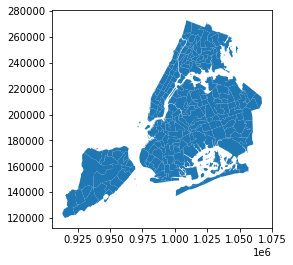

In [187]:
nta_shape.plot()

In [188]:
nta_shape.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ntacode      195 non-null    object  
 1   shape_area   195 non-null    object  
 2   county_fips  195 non-null    object  
 3   ntaname      195 non-null    object  
 4   shape_leng   195 non-null    object  
 5   boro_name    195 non-null    object  
 6   boro_code    195 non-null    object  
 7   geometry     195 non-null    geometry
dtypes: geometry(1), object(7)
memory usage: 12.3+ KB


# 4. Mapping

## City-Wide

In [189]:
gdf = gpd.GeoDataFrame(flooding_311, 
                       geometry=gpd.points_from_xy(flooding_311.x_coordinate_state_plane, 
                                                   flooding_311.y_coordinate_state_plane))

gdf.set_crs(epsg=2263, inplace=True)
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [190]:
gdf = gpd.sjoin(gdf, 
                nta_shape, 
                how="inner", 
                op='within')

In [191]:
gdf.head()

unique_key             created_date              closed_date agency  \
0       40140533  2018-08-29T08:35:00.000  2018-09-08T12:40:00.000    DEP   
13      40203741  2018-09-06T18:34:00.000  2018-09-08T12:25:00.000    DEP   
1971    42223076  2019-04-14T10:33:00.000  2019-04-17T11:00:00.000    DEP   
1973    42224479  2019-04-14T10:36:00.000  2019-04-17T11:25:00.000    DEP   
5920    20549194  2011-06-01T07:59:00.000  2011-06-03T16:00:00.000    DEP   

                                 agency_name complaint_type  \
0     Department of Environmental Protection          Sewer   
13    Department of Environmental Protection          Sewer   
1971  Department of Environmental Protection          Sewer   
1973  Department of Environmental Protection          Sewer   
5920  Department of Environmental Protection          Sewer   

                descriptor  incident_zip intersection_street_1  \
0     Street Flooding (SJ)       10034.0       WEST 206 STREET   
13    Street Flooding (SJ)       10034.0              9 AVENUE   
1971  Street Flooding (SJ)       10034.0                   NaN   
1973  Street Flooding (SJ)       10034.0                   NaN   
5920  Street Flooding (SJ)       10034.0       WEST 207 STREET   

     intersection_street_2  ...           bbl                        geometry  \
0                 9 AVENUE  ...           NaN  POINT (1007054.000 253710.000)   
13         WEST 220 STREET  ...           NaN  POINT (1008802.000 256858.000)   
1971                   NaN  ...  1.022268e+09  POINT (1006343.000 254787.000)   
1973                   NaN  ...  1.022260e+09  POINT (1006135.000 254606.000)   
5920           POST AVENUE  ...           NaN  POINT (1006554.000 254361.000)   

     index_right ntacode     shape_area county_fips             ntaname  \
0             80    MN01  17732688.6953         061  Marble Hill-Inwood   
13            80    MN01  17732688.6953         061  Marble Hill-Inwood   
1971          80    MN01  17732688.6953         061  Marble Hill-Inwood   
1973          80    MN01  17732688.6953         061  Marble Hill-Inwood   
5920          80    MN01  17732688.6953         061  Marble Hill-Inwood   

         shape_leng  boro_name boro_code  
0     31844.4094213  Manhattan         1  
13    31844.4094213  Manhattan         1  
1971  31844.4094213  Manhattan         1  
1973  31844.4094213  Manhattan         1  
5920  31844.4094213  Manhattan         1  

[5 rows x 39 columns]

<AxesSubplot:>

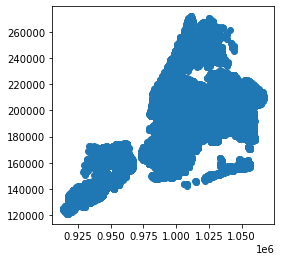

In [192]:
gdf.plot()

In [193]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 26872 entries, 0 to 20084
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      26872 non-null  int64   
 1   created_date                    26872 non-null  object  
 2   closed_date                     26858 non-null  object  
 3   agency                          26872 non-null  object  
 4   agency_name                     26872 non-null  object  
 5   complaint_type                  26872 non-null  object  
 6   descriptor                      26872 non-null  object  
 7   incident_zip                    26872 non-null  float64 
 8   intersection_street_1           9332 non-null   object  
 9   intersection_street_2           9332 non-null   object  
 10  address_type                    26872 non-null  object  
 11  city                            26872 non-null  object  
 12  status    

In [194]:
gdf.describe()

unique_key  incident_zip  x_coordinate_state_plane  \
count  2.687200e+04  26872.000000              2.687200e+04   
mean   3.249796e+07  10969.335554              1.005482e+06   
std    9.142853e+06    536.489890              3.505323e+04   
min    1.563993e+07  10001.000000              9.133570e+05   
25%    2.446031e+07  10312.000000              9.868595e+05   
50%    3.280714e+07  11221.000000              1.007473e+06   
75%    4.040400e+07  11385.000000              1.033960e+06   
max    4.849008e+07  11697.000000              1.067279e+06   

       y_coordinate_state_plane      latitude     longitude           bbl  \
count              26872.000000  24373.000000  24373.000000  1.610000e+04   
mean              186157.443398     40.677426    -73.922172  3.699657e+09   
std                30562.807193      0.083666      0.126331  1.076114e+09   
min               121032.000000     40.498628    -74.254937  0.000000e+00   
25%               161248.000000     40.609055    -73.989748  3.060425e+09   
50%               183602.000000     40.670439    -73.915380  4.068114e+09   
75%               206450.500000     40.732321    -73.819532  4.156283e+09   
max               271876.000000     40.912869    -73.700384  5.080500e+09   

        index_right  
count  26872.000000  
mean     100.092959  
std       58.700143  
min        0.000000  
25%       50.000000  
50%       97.500000  
75%      159.000000  
max      194.000000

In [195]:
gdf.drop(columns=["shape_leng", 'shape_area'], inplace=True)

In [196]:
ls data/

311-flooding-data.csv  streets_clipped.json


In [197]:
path = 'data/streets_clipped.json'
streets = gpd.read_file(path)

streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [198]:
streets.shape

(99354, 12)

<AxesSubplot:>

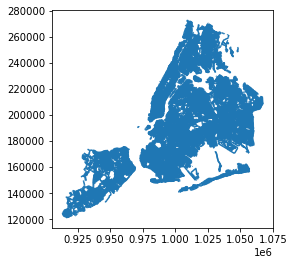

In [199]:
streets.plot()

In [200]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99354 entries, 0 to 99353
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99354 non-null  object  
 1   st_label      99354 non-null  object  
 2   st_name       99354 non-null  object  
 3   full_stree    99354 non-null  object  
 4   rw_type       99354 non-null  object  
 5   rw_type_name  99354 non-null  object  
 6   st_width      99354 non-null  object  
 7   frm_lvl_co    99354 non-null  object  
 8   to_lvl_co     99354 non-null  object  
 9   borocode      99354 non-null  object  
 10  shape_leng    99354 non-null  float64 
 11  geometry      99354 non-null  geometry
dtypes: float64(1), geometry(1), object(10)
memory usage: 9.1+ MB


In [201]:
streets.geom_type.value_counts()

LineString    99354
dtype: int64

In [202]:
streets.describe()

shape_leng
count  9.935400e+04
mean   3.431337e+02
std    2.620169e+02
min    1.068681e-08
25%    1.953887e+02
50%    2.648512e+02
75%    4.583294e+02
max    1.509366e+04

# Snap points to lines

In [203]:
streets.sindex

rtree.index.Index(bounds=[913351.9846191381, 120918.59619133211, 1067379.5294189155, 272688.0944213113], size=99354)

In [204]:
offset = 80

bbox = gdf.bounds + [-offset, -offset, offset, offset]

bbox.head()

minx      miny       maxx      maxy
0     1006974.0  253630.0  1007134.0  253790.0
13    1008722.0  256778.0  1008882.0  256938.0
1971  1006263.0  254707.0  1006423.0  254867.0
1973  1006055.0  254526.0  1006215.0  254686.0
5920  1006474.0  254281.0  1006634.0  254441.0

In [205]:
hits = bbox.apply(lambda row: list(streets.sindex.intersection(row)), axis=1)

hits.head()

0        [6340, 81522, 17295, 77331]
13             [10786, 34033, 59293]
1971     [89996, 15985, 3914, 92049]
1973                         [15985]
5920    [89996, 11128, 97176, 50908]
dtype: object

In [206]:
hits.shape

(26872,)

In [207]:
tmp = pd.DataFrame(
                {
                # index of points table
                "pt_idx": np.repeat(hits.index, hits.apply(len)),
                    
                # ordinal position of line - access via iloc later
                "line_i": np.concatenate(hits.values)
                })

In [208]:
tmp.head()

pt_idx   line_i
0       0   6340.0
1       0  81522.0
2       0  17295.0
3       0  77331.0
4      13  10786.0

In [209]:
tmp.shape

(89484, 2)

In [210]:
streets.shape

(99354, 12)

In [211]:
streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [212]:
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(streets.reset_index(drop=True), on="line_i")

tmp.head()

pt_idx   line_i physicalid  st_label st_name full_stree rw_type  \
0       0   6340.0      24918     9 AVE       9      9 AVE       1   
1       0  81522.0      82455  W 206 ST     206  W  206 ST       1   
2       0  17295.0      24919     9 AVE       9      9 AVE       1   
3       0  77331.0      82454  W 206 ST     206  W  206 ST       1   
4      13  10786.0      25112     9 AVE       9      9 AVE       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       40         13        13        1  260.900947   
1       Street       34         13        13        1  398.876341   
2       Street       40         13        13        1  279.740348   
3       Street       34         13        13        1  586.775330   
4       Street       38         13        13        1  258.616941   

                                            geometry  
0  LINESTRING (1006927.716 253481.641, 1007054.40...  
1  LINESTRING (1007404.139 253517.914, 1007054.40...  
2  LINESTRING (1007054.406 253709.718, 1007190.24...  
3  LINESTRING (1007054.406 253709.718, 1006539.58...  
4  LINESTRING (1008676.210 256631.585, 1008801.63...

In [213]:
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(gdf.geometry.rename("point"), on="pt_idx")

# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(tmp, geometry="geometry", crs=gdf.crs)

In [214]:
tmp.head()

pt_idx   line_i physicalid  st_label st_name full_stree rw_type  \
0       0   6340.0      24918     9 AVE       9      9 AVE       1   
1       0  81522.0      82455  W 206 ST     206  W  206 ST       1   
2       0  17295.0      24919     9 AVE       9      9 AVE       1   
3       0  77331.0      82454  W 206 ST     206  W  206 ST       1   
4      13  10786.0      25112     9 AVE       9      9 AVE       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       40         13        13        1  260.900947   
1       Street       34         13        13        1  398.876341   
2       Street       40         13        13        1  279.740348   
3       Street       34         13        13        1  586.775330   
4       Street       38         13        13        1  258.616941   

                                            geometry  \
0  LINESTRING (1006927.716 253481.641, 1007054.40...   
1  LINESTRING (1007404.139 253517.914, 1007054.40...   
2  LINESTRING (1007054.406 253709.718, 1007190.24...   
3  LINESTRING (1007054.406 253709.718, 1006539.58...   
4  LINESTRING (1008676.210 256631.585, 1008801.63...   

                            point  
0  POINT (1007054.000 253710.000)  
1  POINT (1007054.000 253710.000)  
2  POINT (1007054.000 253710.000)  
3  POINT (1007054.000 253710.000)  
4  POINT (1008802.000 256858.000)

In [215]:
tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))

tmp.head()

pt_idx   line_i physicalid  st_label st_name full_stree rw_type  \
0       0   6340.0      24918     9 AVE       9      9 AVE       1   
1       0  81522.0      82455  W 206 ST     206  W  206 ST       1   
2       0  17295.0      24919     9 AVE       9      9 AVE       1   
3       0  77331.0      82454  W 206 ST     206  W  206 ST       1   
4      13  10786.0      25112     9 AVE       9      9 AVE       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       40         13        13        1  260.900947   
1       Street       34         13        13        1  398.876341   
2       Street       40         13        13        1  279.740348   
3       Street       34         13        13        1  586.775330   
4       Street       38         13        13        1  258.616941   

                                            geometry  \
0  LINESTRING (1006927.716 253481.641, 1007054.40...   
1  LINESTRING (1007404.139 253517.914, 1007054.40...   
2  LINESTRING (1007054.406 253709.718, 1007190.24...   
3  LINESTRING (1007054.406 253709.718, 1006539.58...   
4  LINESTRING (1008676.210 256631.585, 1008801.63...   

                            point  snap_dist  
0  POINT (1007054.000 253710.000)   0.494416  
1  POINT (1007054.000 253710.000)   0.494416  
2  POINT (1007054.000 253710.000)   0.491900  
3  POINT (1007054.000 253710.000)   0.053063  
4  POINT (1008802.000 256858.000)   0.442389

In [216]:
tmp[['snap_dist']].describe()

snap_dist
count  89484.000000
mean      48.754164
std      109.189761
min        0.000002
25%        0.428972
50%        3.352310
75%       63.665634
max     3109.136264

In [217]:
# Discard any lines that are greater than tolerance from points
tmp = tmp.loc[tmp.snap_dist <= offset]

# Sort on ascending snap distance, so that closest goes to top
tmp = tmp.sort_values(by=["snap_dist"])

tmp.head()

pt_idx   line_i physicalid st_label st_name  full_stree rw_type  \
1844     2023  78865.0      53191    63 ST      63       63 ST       1   
65226   16235  75846.0      12940    99 ST      99       99 ST       1   
65202   14580  75846.0      12940    99 ST      99       99 ST       1   
15419     337  17713.0      45636  E 22 ST      22    E  22 ST       1   
55181   20591  33503.0       1116    8 AVE  EIGHTH  EIGHTH AVE       1   

      rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
1844        Street       30         13        13        3  778.787201   
65226       Street       56         13        13        4  776.951894   
65202       Street       56         13        13        4  776.951894   
15419       Street       30         13        13        3  880.043541   
55181       Street       68         13        13        1  261.957251   

                                                geometry  \
1844   LINESTRING (984162.923 167762.061, 984772.939 ...   
65226  LINESTRING (1022531.087 209487.727, 1022844.15...   
65202  LINESTRING (1022531.087 209487.727, 1022844.15...   
15419  LINESTRING (996772.973 168199.186, 996898.570 ...   
55181  LINESTRING (984801.902 211046.822, 984928.407 ...   

                                point  snap_dist  
1844    POINT (984163.000 167762.000)   0.000002  
65226  POINT (1022844.000 208777.000)   0.000026  
65202  POINT (1022844.000 208777.000)   0.000026  
15419   POINT (996773.000 168199.000)   0.000030  
55181   POINT (984802.000 211047.000)   0.000045

In [218]:
tmp[['snap_dist']].describe()

snap_dist
count  73099.000000
mean      16.280064
std       23.955855
min        0.000002
25%        0.358298
50%        2.782204
75%       29.562405
max       79.994171

In [219]:
# group by the index of the points and take the first, which is the
# closest line 
closest = tmp.groupby("pt_idx").first()

# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")

closest.head()

line_i physicalid        st_label     st_name      full_stree  \
pt_idx                                                                   
0       77331.0      82454        W 206 ST         206       W  206 ST   
1       31937.0      44144         E 27 ST          27        E  27 ST   
2       94693.0      51010  BAINBRIDGE AVE  BAINBRIDGE  BAINBRIDGE AVE   
3       24308.0      51112           59 ST          59           59 ST   
4       68555.0     101114         PINE ST        PINE         PINE ST   

       rw_type rw_type_name st_width frm_lvl_co to_lvl_co borocode  \
pt_idx                                                               
0            1       Street       34         13        13        1   
1            1       Street       32         13        13        3   
2            1       Street       30         13        13        2   
3            1       Street       30         13        13        3   
4            1       Street       30         13        13        3   

        shape_leng                                           geometry  \
pt_idx                                                                  
0       586.775330  LINESTRING (1007054.406 253709.718, 1006539.58...   
1       780.066860  LINESTRING (999945.884 155504.927, 1000057.212...   
2       875.994518  LINESTRING (1014086.065 254305.350, 1014142.56...   
3       785.473086  LINESTRING (987335.617 166599.416, 987951.361 ...   
4       674.642961  LINESTRING (1019290.805 188931.768, 1019418.30...   

                                 point  snap_dist  
pt_idx                                             
0       POINT (1007054.000 253710.000)   0.053063  
1       POINT (1000014.000 155014.000)   2.644267  
2       POINT (1014109.000 254371.000)   3.057985  
3        POINT (987430.000 166528.000)   2.615709  
4       POINT (1019366.000 188555.000)   2.635187

In [220]:
closest.index.is_unique

True

In [221]:
closest.physicalid.is_unique

False

In [222]:
len(gdf)

26872

In [223]:
len(closest)

26812

In [224]:
len(closest)/len(gdf)

0.9977671926168502

In [225]:
print("We've dropped", str(len(gdf) - len(closest)), '(' + \
      str(round((1 - (len(closest) / len(gdf))) * 100, 2)) + \
      '%) of street flooding complaint points that\nwere more than 80 ft. ' + \
      'from the closest street center line.')

We've dropped 60 (0.22%) of street flooding complaint points that
were more than 80 ft. from the closest street center line.


In [226]:
# Position of nearest point from start of the line
pos = closest.geometry.project(gpd.GeoSeries(closest.point))

# Get new point location geometry
new_pts = closest.geometry.interpolate(pos)

new_pts.head()

pt_idx
0    POINT (1007053.975 253709.953)
1    POINT (1000016.617 155014.377)
2    POINT (1014111.840 254369.865)
3     POINT (987428.376 166525.950)
4    POINT (1019363.412 188554.502)
dtype: geometry

In [227]:
# Create a new GeoDataFrame from the columns from the closest line and 
# new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(closest, geometry=new_pts)

snapped.head()

line_i physicalid        st_label     st_name      full_stree  \
pt_idx                                                                   
0       77331.0      82454        W 206 ST         206       W  206 ST   
1       31937.0      44144         E 27 ST          27        E  27 ST   
2       94693.0      51010  BAINBRIDGE AVE  BAINBRIDGE  BAINBRIDGE AVE   
3       24308.0      51112           59 ST          59           59 ST   
4       68555.0     101114         PINE ST        PINE         PINE ST   

       rw_type rw_type_name st_width frm_lvl_co to_lvl_co borocode  \
pt_idx                                                               
0            1       Street       34         13        13        1   
1            1       Street       32         13        13        3   
2            1       Street       30         13        13        2   
3            1       Street       30         13        13        3   
4            1       Street       30         13        13        3   

        shape_leng                        geometry  \
pt_idx                                               
0       586.775330  POINT (1007053.975 253709.953)   
1       780.066860  POINT (1000016.617 155014.377)   
2       875.994518  POINT (1014111.840 254369.865)   
3       785.473086   POINT (987428.376 166525.950)   
4       674.642961  POINT (1019363.412 188554.502)   

                                 point  snap_dist  
pt_idx                                             
0       POINT (1007054.000 253710.000)   0.053063  
1       POINT (1000014.000 155014.000)   2.644267  
2       POINT (1014109.000 254371.000)   3.057985  
3        POINT (987430.000 166528.000)   2.615709  
4       POINT (1019366.000 188555.000)   2.635187

In [228]:
gdf.head()

unique_key             created_date              closed_date agency  \
0       40140533  2018-08-29T08:35:00.000  2018-09-08T12:40:00.000    DEP   
13      40203741  2018-09-06T18:34:00.000  2018-09-08T12:25:00.000    DEP   
1971    42223076  2019-04-14T10:33:00.000  2019-04-17T11:00:00.000    DEP   
1973    42224479  2019-04-14T10:36:00.000  2019-04-17T11:25:00.000    DEP   
5920    20549194  2011-06-01T07:59:00.000  2011-06-03T16:00:00.000    DEP   

                                 agency_name complaint_type  \
0     Department of Environmental Protection          Sewer   
13    Department of Environmental Protection          Sewer   
1971  Department of Environmental Protection          Sewer   
1973  Department of Environmental Protection          Sewer   
5920  Department of Environmental Protection          Sewer   

                descriptor  incident_zip intersection_street_1  \
0     Street Flooding (SJ)       10034.0       WEST 206 STREET   
13    Street Flooding (SJ)       10034.0              9 AVENUE   
1971  Street Flooding (SJ)       10034.0                   NaN   
1973  Street Flooding (SJ)       10034.0                   NaN   
5920  Street Flooding (SJ)       10034.0       WEST 207 STREET   

     intersection_street_2  ... cross_street_1 cross_street_2           bbl  \
0                 9 AVENUE  ...            NaN            NaN           NaN   
13         WEST 220 STREET  ...            NaN            NaN           NaN   
1971                   NaN  ...    SHERMAN AVE  VERMILYEA AVE  1.022268e+09   
1973                   NaN  ...       W 204 ST       W 207 ST  1.022260e+09   
5920           POST AVENUE  ...       W 207 ST       POST AVE           NaN   

                            geometry index_right ntacode county_fips  \
0     POINT (1007054.000 253710.000)          80    MN01         061   
13    POINT (1008802.000 256858.000)          80    MN01         061   
1971  POINT (1006343.000 254787.000)          80    MN01         061   
1973  POINT (1006135.000 254606.000)          80    MN01         061   
5920  POINT (1006554.000 254361.000)          80    MN01         061   

                 ntaname  boro_name boro_code  
0     Marble Hill-Inwood  Manhattan         1  
13    Marble Hill-Inwood  Manhattan         1  
1971  Marble Hill-Inwood  Manhattan         1  
1973  Marble Hill-Inwood  Manhattan         1  
5920  Marble Hill-Inwood  Manhattan         1  

[5 rows x 37 columns]

In [229]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 26872 entries, 0 to 20084
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      26872 non-null  int64   
 1   created_date                    26872 non-null  object  
 2   closed_date                     26858 non-null  object  
 3   agency                          26872 non-null  object  
 4   agency_name                     26872 non-null  object  
 5   complaint_type                  26872 non-null  object  
 6   descriptor                      26872 non-null  object  
 7   incident_zip                    26872 non-null  float64 
 8   intersection_street_1           9332 non-null   object  
 9   intersection_street_2           9332 non-null   object  
 10  address_type                    26872 non-null  object  
 11  city                            26872 non-null  object  
 12  status    

In [230]:
gdf.drop(columns=["geometry"], inplace=True)

In [231]:
gdf.head()

unique_key             created_date              closed_date agency  \
0       40140533  2018-08-29T08:35:00.000  2018-09-08T12:40:00.000    DEP   
13      40203741  2018-09-06T18:34:00.000  2018-09-08T12:25:00.000    DEP   
1971    42223076  2019-04-14T10:33:00.000  2019-04-17T11:00:00.000    DEP   
1973    42224479  2019-04-14T10:36:00.000  2019-04-17T11:25:00.000    DEP   
5920    20549194  2011-06-01T07:59:00.000  2011-06-03T16:00:00.000    DEP   

                                 agency_name complaint_type  \
0     Department of Environmental Protection          Sewer   
13    Department of Environmental Protection          Sewer   
1971  Department of Environmental Protection          Sewer   
1973  Department of Environmental Protection          Sewer   
5920  Department of Environmental Protection          Sewer   

                descriptor  incident_zip intersection_street_1  \
0     Street Flooding (SJ)       10034.0       WEST 206 STREET   
13    Street Flooding (SJ)       10034.0              9 AVENUE   
1971  Street Flooding (SJ)       10034.0                   NaN   
1973  Street Flooding (SJ)       10034.0                   NaN   
5920  Street Flooding (SJ)       10034.0       WEST 207 STREET   

     intersection_street_2  ...      street_name cross_street_1  \
0                 9 AVENUE  ...              NaN            NaN   
13         WEST 220 STREET  ...              NaN            NaN   
1971                   NaN  ...  WEST 207 STREET    SHERMAN AVE   
1973                   NaN  ...   SHERMAN AVENUE       W 204 ST   
5920           POST AVENUE  ...              NaN       W 207 ST   

     cross_street_2           bbl index_right ntacode county_fips  \
0               NaN           NaN          80    MN01         061   
13              NaN           NaN          80    MN01         061   
1971  VERMILYEA AVE  1.022268e+09          80    MN01         061   
1973       W 207 ST  1.022260e+09          80    MN01         061   
5920       POST AVE           NaN          80    MN01         061   

                 ntaname  boro_name boro_code  
0     Marble Hill-Inwood  Manhattan         1  
13    Marble Hill-Inwood  Manhattan         1  
1971  Marble Hill-Inwood  Manhattan         1  
1973  Marble Hill-Inwood  Manhattan         1  
5920  Marble Hill-Inwood  Manhattan         1  

[5 rows x 36 columns]

In [232]:
snapped.head()

line_i physicalid        st_label     st_name      full_stree  \
pt_idx                                                                   
0       77331.0      82454        W 206 ST         206       W  206 ST   
1       31937.0      44144         E 27 ST          27        E  27 ST   
2       94693.0      51010  BAINBRIDGE AVE  BAINBRIDGE  BAINBRIDGE AVE   
3       24308.0      51112           59 ST          59           59 ST   
4       68555.0     101114         PINE ST        PINE         PINE ST   

       rw_type rw_type_name st_width frm_lvl_co to_lvl_co borocode  \
pt_idx                                                               
0            1       Street       34         13        13        1   
1            1       Street       32         13        13        3   
2            1       Street       30         13        13        2   
3            1       Street       30         13        13        3   
4            1       Street       30         13        13        3   

        shape_leng                        geometry  \
pt_idx                                               
0       586.775330  POINT (1007053.975 253709.953)   
1       780.066860  POINT (1000016.617 155014.377)   
2       875.994518  POINT (1014111.840 254369.865)   
3       785.473086   POINT (987428.376 166525.950)   
4       674.642961  POINT (1019363.412 188554.502)   

                                 point  snap_dist  
pt_idx                                             
0       POINT (1007054.000 253710.000)   0.053063  
1       POINT (1000014.000 155014.000)   2.644267  
2       POINT (1014109.000 254371.000)   3.057985  
3        POINT (987430.000 166528.000)   2.615709  
4       POINT (1019366.000 188555.000)   2.635187

In [233]:
# Join back to the original points:
updated_points = gdf.join(snapped)

updated_points.head()

unique_key             created_date              closed_date agency  \
0       40140533  2018-08-29T08:35:00.000  2018-09-08T12:40:00.000    DEP   
13      40203741  2018-09-06T18:34:00.000  2018-09-08T12:25:00.000    DEP   
1971    42223076  2019-04-14T10:33:00.000  2019-04-17T11:00:00.000    DEP   
1973    42224479  2019-04-14T10:36:00.000  2019-04-17T11:25:00.000    DEP   
5920    20549194  2011-06-01T07:59:00.000  2011-06-03T16:00:00.000    DEP   

                                 agency_name complaint_type  \
0     Department of Environmental Protection          Sewer   
13    Department of Environmental Protection          Sewer   
1971  Department of Environmental Protection          Sewer   
1973  Department of Environmental Protection          Sewer   
5920  Department of Environmental Protection          Sewer   

                descriptor  incident_zip intersection_street_1  \
0     Street Flooding (SJ)       10034.0       WEST 206 STREET   
13    Street Flooding (SJ)       10034.0              9 AVENUE   
1971  Street Flooding (SJ)       10034.0                   NaN   
1973  Street Flooding (SJ)       10034.0                   NaN   
5920  Street Flooding (SJ)       10034.0       WEST 207 STREET   

     intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
0                 9 AVENUE  ...       1       Street       34         13   
13         WEST 220 STREET  ...       1       Street       38         13   
1971                   NaN  ...       1       Street       48         13   
1973                   NaN  ...       1       Street       60         13   
5920           POST AVENUE  ...       1       Street       40         13   

     to_lvl_co borocode  shape_leng                        geometry  \
0           13        1  586.775330  POINT (1007053.975 253709.953)   
13          13        1  480.008640  POINT (1008801.774 256858.093)   
1971        13        1  389.929306  POINT (1006345.630 254788.280)   
1973        13        1  580.352368  POINT (1006136.490 254602.944)   
5920        13        1  580.782384  POINT (1006553.918 254361.169)   

                               point snap_dist  
0     POINT (1007054.000 253710.000)  0.053063  
13    POINT (1008802.000 256858.000)  0.244108  
1971  POINT (1006343.000 254787.000)  2.924519  
1973  POINT (1006135.000 254606.000)  3.400272  
5920  POINT (1006554.000 254361.000)  0.187814  

[5 rows x 51 columns]

In [234]:
updated_points.geom_type.isna().value_counts()

False    26812
True        60
dtype: int64

In [235]:
# You may want to drop any that didn't snap, if so:
updated_points = updated_points.dropna(subset=["geometry"])

updated_points.head()

unique_key             created_date              closed_date agency  \
0       40140533  2018-08-29T08:35:00.000  2018-09-08T12:40:00.000    DEP   
13      40203741  2018-09-06T18:34:00.000  2018-09-08T12:25:00.000    DEP   
1971    42223076  2019-04-14T10:33:00.000  2019-04-17T11:00:00.000    DEP   
1973    42224479  2019-04-14T10:36:00.000  2019-04-17T11:25:00.000    DEP   
5920    20549194  2011-06-01T07:59:00.000  2011-06-03T16:00:00.000    DEP   

                                 agency_name complaint_type  \
0     Department of Environmental Protection          Sewer   
13    Department of Environmental Protection          Sewer   
1971  Department of Environmental Protection          Sewer   
1973  Department of Environmental Protection          Sewer   
5920  Department of Environmental Protection          Sewer   

                descriptor  incident_zip intersection_street_1  \
0     Street Flooding (SJ)       10034.0       WEST 206 STREET   
13    Street Flooding (SJ)       10034.0              9 AVENUE   
1971  Street Flooding (SJ)       10034.0                   NaN   
1973  Street Flooding (SJ)       10034.0                   NaN   
5920  Street Flooding (SJ)       10034.0       WEST 207 STREET   

     intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
0                 9 AVENUE  ...       1       Street       34         13   
13         WEST 220 STREET  ...       1       Street       38         13   
1971                   NaN  ...       1       Street       48         13   
1973                   NaN  ...       1       Street       60         13   
5920           POST AVENUE  ...       1       Street       40         13   

     to_lvl_co borocode  shape_leng                        geometry  \
0           13        1  586.775330  POINT (1007053.975 253709.953)   
13          13        1  480.008640  POINT (1008801.774 256858.093)   
1971        13        1  389.929306  POINT (1006345.630 254788.280)   
1973        13        1  580.352368  POINT (1006136.490 254602.944)   
5920        13        1  580.782384  POINT (1006553.918 254361.169)   

                               point snap_dist  
0     POINT (1007054.000 253710.000)  0.053063  
13    POINT (1008802.000 256858.000)  0.244108  
1971  POINT (1006343.000 254787.000)  2.924519  
1973  POINT (1006135.000 254606.000)  3.400272  
5920  POINT (1006554.000 254361.000)  0.187814  

[5 rows x 51 columns]

In [236]:
updated_points.geom_type.isna().value_counts()

False    26812
dtype: int64

In [237]:
updated_points.shape

(26812, 51)

In [238]:
updated_points.sort_values(by='snap_dist').head()

unique_key             created_date              closed_date agency  \
2023     42243506  2019-04-16T08:42:00.000  2019-04-16T11:15:00.000    DEP   
16235    25320481  2013-04-08T11:02:00.000  2013-04-12T09:15:00.000    DEP   
14580    23341412  2012-06-01T09:24:00.000  2012-06-05T09:45:00.000    DEP   
337      40665956  2018-10-26T13:23:00.000  2018-10-27T09:45:00.000    DEP   
1905     42117184  2019-04-02T10:40:00.000  2019-04-13T11:45:00.000    DEP   

                                  agency_name complaint_type  \
2023   Department of Environmental Protection          Sewer   
16235  Department of Environmental Protection          Sewer   
14580  Department of Environmental Protection          Sewer   
337    Department of Environmental Protection          Sewer   
1905   Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
2023   Street Flooding (SJ)       11219.0             63 STREET   
16235  Street Flooding (SJ)       11368.0             55 AVENUE   
14580  Street Flooding (SJ)       11368.0             55 AVENUE   
337    Street Flooding (SJ)       11210.0              AVENUE I   
1905   Street Flooding (SJ)       10011.0        WEST 24 STREET   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
2023              13 AVENUE  ...       1       Street       30         13   
16235             99 STREET  ...       1       Street       56         13   
14580             99 STREET  ...       1       Street       56         13   
337          EAST 22 STREET  ...       1       Street       30         13   
1905               8 AVENUE  ...       1       Street       68         13   

      to_lvl_co borocode  shape_leng                        geometry  \
2023         13        3  778.787201   POINT (984163.000 167762.000)   
16235        13        4  776.951894  POINT (1022844.000 208777.000)   
14580        13        4  776.951894  POINT (1022844.000 208777.000)   
337          13        3  880.043541   POINT (996773.000 168199.000)   
1905         13        1  261.957251   POINT (984802.000 211047.000)   

                                point snap_dist  
2023    POINT (984163.000 167762.000)  0.000002  
16235  POINT (1022844.000 208777.000)  0.000026  
14580  POINT (1022844.000 208777.000)  0.000026  
337     POINT (996773.000 168199.000)  0.000030  
1905    POINT (984802.000 211047.000)  0.000045  

[5 rows x 51 columns]

In [239]:
updated_points.sort_values(by='snap_dist', ascending=False).head()

unique_key             created_date              closed_date agency  \
19102    28480099  2014-07-15T15:23:00.000  2014-07-16T03:40:00.000    DEP   
3164     43346261  2019-07-22T21:11:00.000  2019-07-23T11:40:00.000    DEP   
8881     18817559  2010-10-03T15:16:00.000  2010-10-04T10:40:00.000    DEP   
20755    30740271  2015-05-31T20:33:00.000  2015-06-23T08:45:00.000    DEP   
14057    22847904  2012-03-08T13:36:00.000  2012-03-10T09:00:00.000    DEP   

                                  agency_name complaint_type  \
19102  Department of Environmental Protection          Sewer   
3164   Department of Environmental Protection          Sewer   
8881   Department of Environmental Protection          Sewer   
20755  Department of Environmental Protection          Sewer   
14057  Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
19102  Street Flooding (SJ)       11414.0                   NaN   
3164   Street Flooding (SJ)       10018.0                   NaN   
8881   Street Flooding (SJ)       10467.0     WHITE PLAINS ROAD   
20755  Street Flooding (SJ)       11414.0                   NaN   
14057  Street Flooding (SJ)       10473.0                   NaN   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
19102                   NaN  ...       1       Street       40         13   
3164                    NaN  ...       1       Street       44         13   
8881        EAST 211 STREET  ...       1       Street       20         13   
20755                   NaN  ...       1       Street       40         13   
14057                   NaN  ...       1       Street       30         13   

      to_lvl_co borocode  shape_leng                        geometry  \
19102        13        3  566.479837  POINT (1024165.937 181775.728)   
3164         13        1   66.732032   POINT (983509.551 216227.222)   
8881         13        2  171.725774  POINT (1021332.894 259153.397)   
20755        13        3  566.479837  POINT (1024070.126 182327.816)   
14057        13        2  445.892229  POINT (1020826.997 236855.538)   

                                point  snap_dist  
19102  POINT (1024242.000 181788.000)  77.046677  
3164    POINT (983477.000 216162.000)  72.893503  
8881   POINT (1021264.000 259166.000)  70.037699  
20755  POINT (1024139.000 182340.000)  69.943081  
14057  POINT (1020839.000 236788.000)  68.595955  

[5 rows x 51 columns]

In [240]:
updated_points[['snap_dist']].describe()

snap_dist
count  26812.000000
mean       2.737545
std        4.495345
min        0.000002
25%        0.238611
50%        2.702270
75%        3.157043
max       77.046677

Text(0.5, 1.0, 'Histogram of snap_dist (ft.)')

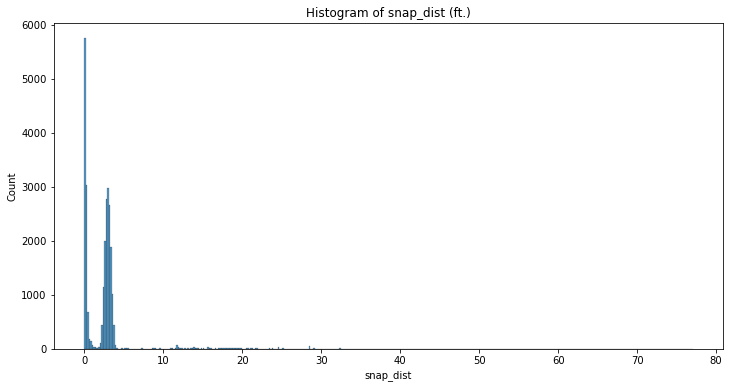

In [241]:
plt.figure(figsize=(12,6))

sns.histplot(updated_points.snap_dist)
plt.title('Histogram of snap_dist (ft.)')

In [242]:
updated_points.iloc[:, 30:45].head()

index_right ntacode county_fips             ntaname  boro_name  \
0              80    MN01         061  Marble Hill-Inwood  Manhattan   
13             80    MN01         061  Marble Hill-Inwood  Manhattan   
1971           80    MN01         061  Marble Hill-Inwood  Manhattan   
1973           80    MN01         061  Marble Hill-Inwood  Manhattan   
5920           80    MN01         061  Marble Hill-Inwood  Manhattan   

     boro_code   line_i physicalid     st_label  st_name   full_stree rw_type  \
0            1  77331.0      82454     W 206 ST      206    W  206 ST       1   
13           1  59293.0      25113        9 AVE        9        9 AVE       1   
1971         1  92049.0      26818     W 207 ST      207    W  207 ST       1   
1973         1  15985.0      25065  SHERMAN AVE  SHERMAN  SHERMAN AVE       1   
5920         1  50908.0      97483     POST AVE     POST     POST AVE       1   

     rw_type_name st_width frm_lvl_co  
0          Street       34         13  
13         Street       38         13  
1971       Street       48         13  
1973       Street       60         13  
5920       Street       40         13

In [243]:
updated_points.physicalid.value_counts()

76941     115
93488      91
44654      88
109590     81
23726      77
         ... 
180682      1
6568        1
31662       1
165043      1
84844       1
Name: physicalid, Length: 12781, dtype: int64

In [244]:
updated_points.physicalid.value_counts().index[0]

'76941'

In [245]:
top_street_id = updated_points.physicalid.value_counts().index[0]
print(top_street_id)

updated_points.loc[updated_points.physicalid == top_street_id].iloc[:, 30:45].head()

76941


index_right ntacode county_fips                 ntaname      boro_name  \
484            95    SI45         085  New Dorp-Midland Beach  Staten Island   
731            95    SI45         085  New Dorp-Midland Beach  Staten Island   
949            95    SI45         085  New Dorp-Midland Beach  Staten Island   
1474           95    SI45         085  New Dorp-Midland Beach  Staten Island   
1747           95    SI45         085  New Dorp-Midland Beach  Staten Island   

     boro_code   line_i physicalid    st_label  st_name  full_stree rw_type  \
484          5  19419.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
731          5  19419.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
949          5  19419.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
1474         5  19419.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
1747         5  19419.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   

     rw_type_name st_width frm_lvl_co  
484        Street       22         13  
731        Street       22         13  
949        Street       22         13  
1474       Street       22         13  
1747       Street       22         13

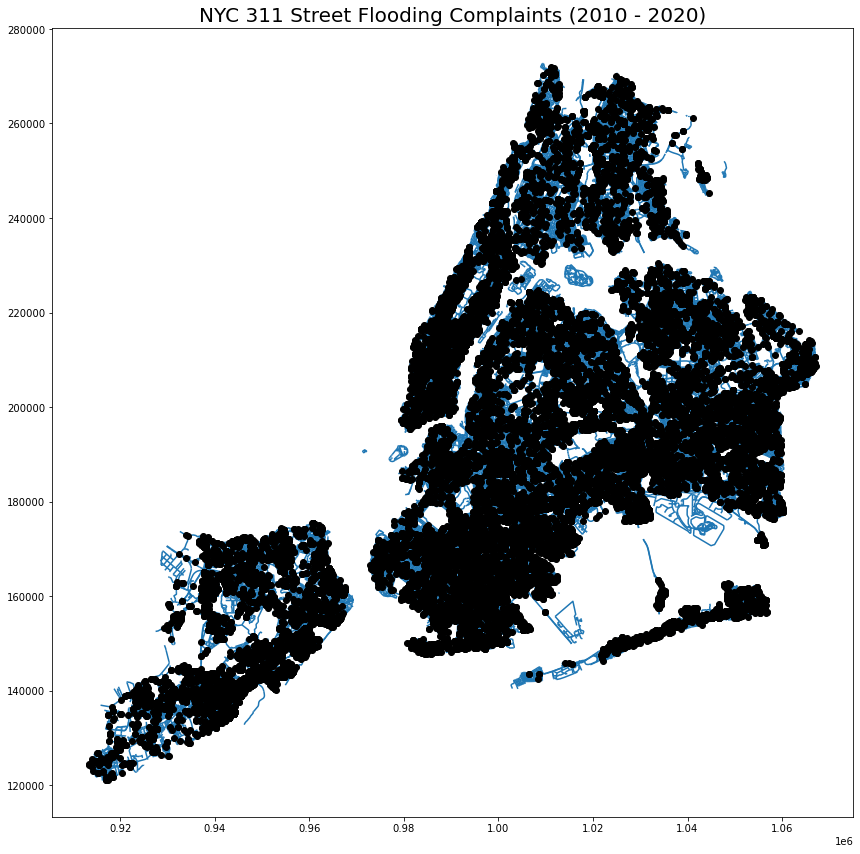

In [246]:
fig, ax = plt.subplots(figsize=(12, 12))

updated_points.plot(ax=ax, 
                    c='black')

streets.plot(ax=ax, 
             zorder=0)

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('NYC 311 Street Flooding Complaints (2010 - 2020)', 
             fontsize=20)

plt.tight_layout()

In [247]:
gdf_count = updated_points.groupby(by='physicalid')['created_date'].count().reset_index()

In [248]:
gdf_count.head()

physicalid  created_date
0     100002             2
1     100019             1
2     100020             1
3      10003             1
4      10004             2

In [249]:
gdf_count.rename(columns={"created_date": "count"}, inplace=True)

In [250]:
gdf_count.head()

physicalid  count
0     100002      2
1     100019      1
2     100020      1
3      10003      1
4      10004      2

In [251]:
streets[['geometry']].head()

geometry
0  LINESTRING (1047146.080 222733.432, 1047385.93...
1  LINESTRING (1009926.638 269075.549, 1010033.71...
2  LINESTRING (989292.818 189689.736, 989648.842 ...
3  LINESTRING (1031371.427 199453.863, 1031412.58...
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [252]:
streets.set_geometry('geometry', inplace=True)

In [253]:
streets.geom_type.value_counts()

LineString    99354
dtype: int64

In [254]:
streets['new_geom'] = streets.geometry.buffer(40, cap_style=2)

streets.set_geometry('new_geom', inplace=True)

In [255]:
streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  \
0  LINESTRING (1047146.080 222733.432, 1047385.93...   
1  LINESTRING (1009926.638 269075.549, 1010033.71...   
2  LINESTRING (989292.818 189689.736, 989648.842 ...   
3  LINESTRING (1031371.427 199453.863, 1031412.58...   
4  LINESTRING (940277.458 144141.538, 940027.193 ...   

                                            new_geom  
0  POLYGON ((1047370.887 222867.857, 1047400.976 ...  
1  POLYGON ((1009994.841 269527.116, 1010072.594 ...  
2  POLYGON ((989665.155 189566.793, 989865.462 18...  
3  POLYGON ((1031432.423 199465.095, 1031392.753 ...  
4  POLYGON ((940041.585 144007.708, 940012.801 14...

In [256]:
streets.geom_type.value_counts()

Polygon         99321
MultiPolygon       33
dtype: int64

In [257]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99354 entries, 0 to 99353
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99354 non-null  object  
 1   st_label      99354 non-null  object  
 2   st_name       99354 non-null  object  
 3   full_stree    99354 non-null  object  
 4   rw_type       99354 non-null  object  
 5   rw_type_name  99354 non-null  object  
 6   st_width      99354 non-null  object  
 7   frm_lvl_co    99354 non-null  object  
 8   to_lvl_co     99354 non-null  object  
 9   borocode      99354 non-null  object  
 10  shape_leng    99354 non-null  float64 
 11  geometry      99354 non-null  geometry
 12  new_geom      99354 non-null  geometry
dtypes: float64(1), geometry(2), object(10)
memory usage: 9.9+ MB


In [258]:
gdf_count.head()

physicalid  count
0     100002      2
1     100019      1
2     100020      1
3      10003      1
4      10004      2

In [259]:
gdf_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12781 entries, 0 to 12780
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   physicalid  12781 non-null  object
 1   count       12781 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 199.8+ KB


In [260]:
streets.shape

(99354, 13)

In [261]:
# joining our street data to our flood complaints data
streets_with_count = streets.merge(gdf_count, 
                                   left_on='physicalid', 
                                   right_on='physicalid', 
                                   how='left')

In [262]:
streets_with_count.shape

(99354, 14)

In [263]:
streets_with_count.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  \
0  LINESTRING (1047146.080 222733.432, 1047385.93...   
1  LINESTRING (1009926.638 269075.549, 1010033.71...   
2  LINESTRING (989292.818 189689.736, 989648.842 ...   
3  LINESTRING (1031371.427 199453.863, 1031412.58...   
4  LINESTRING (940277.458 144141.538, 940027.193 ...   

                                            new_geom  count  
0  POLYGON ((1047370.887 222867.857, 1047400.976 ...    NaN  
1  POLYGON ((1009994.841 269527.116, 1010072.594 ...    NaN  
2  POLYGON ((989665.155 189566.793, 989865.462 18...    NaN  
3  POLYGON ((1031432.423 199465.095, 1031392.753 ...    NaN  
4  POLYGON ((940041.585 144007.708, 940012.801 14...    NaN

In [264]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 99354 entries, 0 to 99353
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99354 non-null  object  
 1   st_label      99354 non-null  object  
 2   st_name       99354 non-null  object  
 3   full_stree    99354 non-null  object  
 4   rw_type       99354 non-null  object  
 5   rw_type_name  99354 non-null  object  
 6   st_width      99354 non-null  object  
 7   frm_lvl_co    99354 non-null  object  
 8   to_lvl_co     99354 non-null  object  
 9   borocode      99354 non-null  object  
 10  shape_leng    99354 non-null  float64 
 11  geometry      99354 non-null  geometry
 12  new_geom      99354 non-null  geometry
 13  count         12781 non-null  float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 11.4+ MB


In [265]:
streets_with_count.isna().sum()

physicalid          0
st_label            0
st_name             0
full_stree          0
rw_type             0
rw_type_name        0
st_width            0
frm_lvl_co          0
to_lvl_co           0
borocode            0
shape_leng          0
geometry            0
new_geom            0
count           86573
dtype: int64

In [266]:
streets_with_count['count'].fillna(0, inplace=True)

streets_with_count.isna().sum()

physicalid      0
st_label        0
st_name         0
full_stree      0
rw_type         0
rw_type_name    0
st_width        0
frm_lvl_co      0
to_lvl_co       0
borocode        0
shape_leng      0
geometry        0
new_geom        0
count           0
dtype: int64

In [267]:
streets_with_count.sort_values(by='count', ascending=False).head()

physicalid     st_label   st_name   full_stree rw_type rw_type_name  \
19419      76941   GRIMSBY ST   GRIMSBY   GRIMSBY ST       1       Street   
66849      93488       157 ST       157       157 ST       1       Street   
56682      44654      MILL RD      MILL      MILL RD       1       Street   
32082     109590  SAPPHIRE ST  SAPPHIRE  SAPPHIRE ST       1       Street   
75660      23726       141 ST       141       141 ST       1       Street   

      st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
19419       22         13        13        5  372.786118   
66849       35         13        13        4  499.592808   
56682       60         13        13        5  404.812891   
32082       22         13        13        3  554.170960   
75660       30         13        13        4  678.503925   

                                                geometry  \
19419  LINESTRING (958533.655 149022.834, 958315.338 ...   
66849  LINESTRING (1045395.099 182129.719, 1045149.50...   
56682  LINESTRING (952047.152 142027.684, 951841.926 ...   
32082  LINESTRING (1023855.973 183442.797, 1023962.32...   
75660  LINESTRING (1039008.353 188480.375, 1039246.94...   

                                                new_geom  count  
19419  POLYGON ((958347.761 148697.237, 958282.915 14...  115.0  
66849  POLYGON ((1045184.342 181674.994, 1045114.676 ...   91.0  
56682  POLYGON ((951876.405 141658.470, 951807.447 14...   88.0  
32082  POLYGON ((1024001.581 182906.603, 1023923.068 ...   81.0  
75660  POLYGON ((1039284.394 187859.272, 1039209.503 ...   77.0

In [268]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 99354 entries, 0 to 99353
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99354 non-null  object  
 1   st_label      99354 non-null  object  
 2   st_name       99354 non-null  object  
 3   full_stree    99354 non-null  object  
 4   rw_type       99354 non-null  object  
 5   rw_type_name  99354 non-null  object  
 6   st_width      99354 non-null  object  
 7   frm_lvl_co    99354 non-null  object  
 8   to_lvl_co     99354 non-null  object  
 9   borocode      99354 non-null  object  
 10  shape_leng    99354 non-null  float64 
 11  geometry      99354 non-null  geometry
 12  new_geom      99354 non-null  geometry
 13  count         99354 non-null  float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 11.4+ MB


In [269]:
streets_with_count[['count']].describe()

count
count  99354.000000
mean       0.269863
std        1.406601
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      115.000000

In [270]:
streets_with_count['shape_leng'] = streets_with_count.geometry.length

In [271]:
streets_with_count[['shape_leng']].describe()

shape_leng
count  99354.000000
mean     846.120079
std      523.750667
min      160.000000
25%      550.767808
50%      689.674253
75%     1076.344195
max    30346.427123

In [272]:
streets_with_count.describe()

shape_leng         count
count  99354.000000  99354.000000
mean     846.120079      0.269863
std      523.750667      1.406601
min      160.000000      0.000000
25%      550.767808      0.000000
50%      689.674253      0.000000
75%     1076.344195      0.000000
max    30346.427123    115.000000

In [273]:
streets_with_count['count_per_100ft'] = (streets_with_count['count'] / streets_with_count['shape_leng']) * 100

streets_with_count.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
0       Street       35         13        13        4   677.719481   
1       Street       42         13        13        2  1069.865843   
2       Street       50         13        13        3  1378.848749   
3       Street       40         13        13        4   254.798456   
4       Street       36         13        13        5   696.457501   

                                            geometry  \
0  LINESTRING (1047146.080 222733.432, 1047385.93...   
1  LINESTRING (1009926.638 269075.549, 1010033.71...   
2  LINESTRING (989292.818 189689.736, 989648.842 ...   
3  LINESTRING (1031371.427 199453.863, 1031412.58...   
4  LINESTRING (940277.458 144141.538, 940027.193 ...   

                                            new_geom  count  count_per_100ft  
0  POLYGON ((1047370.887 222867.857, 1047400.976 ...    0.0              0.0  
1  POLYGON ((1009994.841 269527.116, 1010072.594 ...    0.0              0.0  
2  POLYGON ((989665.155 189566.793, 989865.462 18...    0.0              0.0  
3  POLYGON ((1031432.423 199465.095, 1031392.753 ...    0.0              0.0  
4  POLYGON ((940041.585 144007.708, 940012.801 14...    0.0              0.0

In [274]:
streets_with_count[['count_per_100ft']].describe()

count_per_100ft
count     99354.000000
mean          0.032494
std           0.178704
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          14.704680

In [275]:
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head()

physicalid            st_label  st_name  full_stree rw_type  \
10770     155472            W 228 ST      228   W  228 ST       1   
19419      76941          GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
97509     173312          LORING AVE   LORING  LORING AVE       1   
59875      17823  FRANCIS LEWIS BLVD    LEWIS  LEWIS BLVD       1   
56682      44654             MILL RD     MILL     MILL RD       1   

      rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
10770       Street       44         13        13        1  183.615016   
19419       Street       22         13        13        5  905.572235   
97509       Street       30         13        13        3  643.111870   
59875       Street       20         13        13        4  650.977969   
56682       Street       60         13        13        5  969.625782   

                                                geometry  \
10770  LINESTRING (1009588.352 258326.086, 1009580.22...   
19419  LINESTRING (958533.655 149022.834, 958315.338 ...   
97509  LINESTRING (1023724.487 182856.704, 1023962.32...   
59875  LINESTRING (1056604.322 185833.195, 1056520.50...   
56682  LINESTRING (952047.152 142027.684, 951841.926 ...   

                                                new_geom  count  \
10770  POLYGON ((1009551.215 258307.106, 1009609.228 ...   27.0   
19419  POLYGON ((958347.761 148697.237, 958282.915 14...  115.0   
97509  POLYGON ((1023955.332 182938.311, 1023969.316 ...   67.0   
59875  POLYGON ((1056557.484 185614.763, 1056555.807 ...   62.0   
56682  POLYGON ((951876.405 141658.470, 951807.447 14...   88.0   

       count_per_100ft  
10770        14.704680  
19419        12.699153  
97509        10.418094  
59875         9.524132  
56682         9.075666

In [276]:
streets_with_count['count'].sum()

26812.0

In [277]:
streets_with_count.shape

(99354, 15)

# Joining streets to neighborhoods

In [278]:
updated_points.head()

unique_key             created_date              closed_date agency  \
0       40140533  2018-08-29T08:35:00.000  2018-09-08T12:40:00.000    DEP   
13      40203741  2018-09-06T18:34:00.000  2018-09-08T12:25:00.000    DEP   
1971    42223076  2019-04-14T10:33:00.000  2019-04-17T11:00:00.000    DEP   
1973    42224479  2019-04-14T10:36:00.000  2019-04-17T11:25:00.000    DEP   
5920    20549194  2011-06-01T07:59:00.000  2011-06-03T16:00:00.000    DEP   

                                 agency_name complaint_type  \
0     Department of Environmental Protection          Sewer   
13    Department of Environmental Protection          Sewer   
1971  Department of Environmental Protection          Sewer   
1973  Department of Environmental Protection          Sewer   
5920  Department of Environmental Protection          Sewer   

                descriptor  incident_zip intersection_street_1  \
0     Street Flooding (SJ)       10034.0       WEST 206 STREET   
13    Street Flooding (SJ)       10034.0              9 AVENUE   
1971  Street Flooding (SJ)       10034.0                   NaN   
1973  Street Flooding (SJ)       10034.0                   NaN   
5920  Street Flooding (SJ)       10034.0       WEST 207 STREET   

     intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
0                 9 AVENUE  ...       1       Street       34         13   
13         WEST 220 STREET  ...       1       Street       38         13   
1971                   NaN  ...       1       Street       48         13   
1973                   NaN  ...       1       Street       60         13   
5920           POST AVENUE  ...       1       Street       40         13   

     to_lvl_co borocode  shape_leng                        geometry  \
0           13        1  586.775330  POINT (1007053.975 253709.953)   
13          13        1  480.008640  POINT (1008801.774 256858.093)   
1971        13        1  389.929306  POINT (1006345.630 254788.280)   
1973        13        1  580.352368  POINT (1006136.490 254602.944)   
5920        13        1  580.782384  POINT (1006553.918 254361.169)   

                               point snap_dist  
0     POINT (1007054.000 253710.000)  0.053063  
13    POINT (1008802.000 256858.000)  0.244108  
1971  POINT (1006343.000 254787.000)  2.924519  
1973  POINT (1006135.000 254606.000)  3.400272  
5920  POINT (1006554.000 254361.000)  0.187814  

[5 rows x 51 columns]

In [279]:
updated_points.shape

(26812, 51)

In [280]:
updated_points.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'intersection_street_1',
       'intersection_street_2', 'address_type', 'city', 'status',
       'resolution_description', 'resolution_action_updated_date',
       'community_board', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'latitude', 'longitude',
       'location', 'incident_address', 'street_name', 'cross_street_1',
       'cross_street_2', 'bbl', 'index_right', 'ntacode', 'county_fips',
       'ntaname', 'boro_name', 'boro_code', 'line_i', 'physicalid', 'st_label',
       'st_name', 'full_stree', 'rw_type', 'rw_type_name', 'st_width',
       'frm_lvl_co', 'to_lvl_co', 'borocode', 'shape_leng', 'geometry',
       'point', 'snap_dist'],
      dtype='object')

In [281]:
streets_with_nta = updated_points[['unique_key', 
                                   'ntacode', 
                                   'county_fips',
                                   'ntaname', 
                                   'boro_name', 
                                   'boro_code', 
                                   'shape_leng', 
                                   'physicalid']]

streets_with_nta.head()

unique_key ntacode county_fips             ntaname  boro_name boro_code  \
0       40140533    MN01         061  Marble Hill-Inwood  Manhattan         1   
13      40203741    MN01         061  Marble Hill-Inwood  Manhattan         1   
1971    42223076    MN01         061  Marble Hill-Inwood  Manhattan         1   
1973    42224479    MN01         061  Marble Hill-Inwood  Manhattan         1   
5920    20549194    MN01         061  Marble Hill-Inwood  Manhattan         1   

      shape_leng physicalid  
0     586.775330      82454  
13    480.008640      25113  
1971  389.929306      26818  
1973  580.352368      25065  
5920  580.782384      97483

In [282]:
streets_with_nta.physicalid.value_counts()

76941     115
93488      91
44654      88
109590     81
23726      77
         ... 
180682      1
6568        1
31662       1
165043      1
84844       1
Name: physicalid, Length: 12781, dtype: int64

In [283]:
checking_for_duplicates = streets_with_nta.groupby(by=['physicalid', 
                                                       'ntaname', 
                                                       'boro_name'])['shape_leng'].count().reset_index()

checking_for_duplicates.head()

physicalid                  ntaname boro_name  shape_leng
0     100002           Queens Village    Queens           2
1     100019  Lindenwood-Howard Beach    Queens           1
2     100020  Lindenwood-Howard Beach    Queens           1
3      10003            East Elmhurst    Queens           1
4      10004            East Elmhurst    Queens           2

In [284]:
checking_for_duplicates.rename(columns={"shape_leng": "count_complaints"}, inplace=True)

checking_for_duplicates.head()

physicalid                  ntaname boro_name  count_complaints
0     100002           Queens Village    Queens                 2
1     100019  Lindenwood-Howard Beach    Queens                 1
2     100020  Lindenwood-Howard Beach    Queens                 1
3      10003            East Elmhurst    Queens                 1
4      10004            East Elmhurst    Queens                 2

In [285]:
checking_for_duplicates['physicalid'].is_unique

False

In [286]:
checking_for_duplicates[checking_for_duplicates.duplicated(subset=['physicalid'], 
                                                           keep=False) == True].sort_values(
                                                           by=['physicalid', 
                                                               'count_complaints'], 
                                                           ascending=False).head(10)

physicalid                               ntaname      boro_name  \
12445      97041                               Jamaica         Queens   
12444      97041               Briarwood-Jamaica Hills         Queens   
12293       9550                       Jackson Heights         Queens   
12294       9550                          North Corona         Queens   
12170      94540                          Borough Park       Brooklyn   
12171      94540              Kensington-Ocean Parkway       Brooklyn   
11941      93176                              Rosedale         Queens   
11942      93176  Springfield Gardens South-Brookville         Queens   
11298      88110                New Dorp-Midland Beach  Staten Island   
11299      88110                 Oakwood-Oakwood Beach  Staten Island   

       count_complaints  
12445                 2  
12444                 1  
12293                 1  
12294                 1  
12170                 2  
12171                 1  
11941                 1  
11942                 1  
11298                 2  
11299                 1

In [287]:
checking_for_duplicates[checking_for_duplicates.duplicated(subset=['physicalid'], 
                                                           keep=False) == True].sort_values(
                                                           by=['physicalid', 
                                                               'count_complaints'], 
                                                           ascending=[True, False]).head(10)

physicalid                      ntaname  boro_name  count_complaints
202     101556           Marble Hill-Inwood  Manhattan                 1
203     101556  park-cemetery-etc-Manhattan  Manhattan                 1
588      10779               Middle Village     Queens                 1
589      10779                    Ridgewood     Queens                 1
603     109590      Lindenwood-Howard Beach     Queens                56
602     109590                East New York   Brooklyn                25
643       1134                      Clinton  Manhattan                 5
644       1134        Midtown-Midtown South  Manhattan                 3
647       1138                      Clinton  Manhattan                 2
648       1138        Midtown-Midtown South  Manhattan                 1

In [288]:
checking_for_duplicates[checking_for_duplicates.duplicated(subset=['physicalid'], 
                                                           keep=False) == True].shape[0]

150

In [289]:
duplicates = (len(checking_for_duplicates[checking_for_duplicates.duplicated(subset=
                                                               ['physicalid'], 
                                                               keep=False) == True]) / len(streets_with_count) * 100)


round(duplicates, 2)

0.15

# There are 150 duplicates (.15% of total) of street segments to neighborhoods

In [290]:
checking_for_duplicates[checking_for_duplicates.physicalid == '109590'].sort_values(by=['physicalid', 
                                                                                        'count_complaints'], 
                                                                                   ascending=[True,
                                                                                              False])

physicalid                  ntaname boro_name  count_complaints
603     109590  Lindenwood-Howard Beach    Queens                56
602     109590            East New York  Brooklyn                25

# Sorting descending by number of complaints on a street in a given NTA. Then removing duplicates.

In [291]:
unique_streets = checking_for_duplicates.sort_values(by=['physicalid', 
                                                         'count_complaints'], 
                                                     ascending=[True, 
                                                                False]).drop_duplicates('physicalid')

In [292]:
unique_streets.head()

physicalid                  ntaname boro_name  count_complaints
0     100002           Queens Village    Queens                 2
1     100019  Lindenwood-Howard Beach    Queens                 1
2     100020  Lindenwood-Howard Beach    Queens                 1
3      10003            East Elmhurst    Queens                 1
4      10004            East Elmhurst    Queens                 2

In [293]:
unique_streets[unique_streets.physicalid == '109590']

physicalid                  ntaname boro_name  count_complaints
603     109590  Lindenwood-Howard Beach    Queens                56

In [294]:
unique_streets.physicalid.is_unique

True

In [295]:
streets_with_count.shape

(99354, 15)

In [296]:
# joining our nta population data to our nta shapes data
streets_with_count_nta = streets_with_count.merge(unique_streets, 
                                                  left_on='physicalid', 
                                                  right_on='physicalid', 
                                                  how='left')

streets_with_count_nta.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
0       Street       35         13        13        4   677.719481   
1       Street       42         13        13        2  1069.865843   
2       Street       50         13        13        3  1378.848749   
3       Street       40         13        13        4   254.798456   
4       Street       36         13        13        5   696.457501   

                                            geometry  \
0  LINESTRING (1047146.080 222733.432, 1047385.93...   
1  LINESTRING (1009926.638 269075.549, 1010033.71...   
2  LINESTRING (989292.818 189689.736, 989648.842 ...   
3  LINESTRING (1031371.427 199453.863, 1031412.58...   
4  LINESTRING (940277.458 144141.538, 940027.193 ...   

                                            new_geom  count  count_per_100ft  \
0  POLYGON ((1047370.887 222867.857, 1047400.976 ...    0.0              0.0   
1  POLYGON ((1009994.841 269527.116, 1010072.594 ...    0.0              0.0   
2  POLYGON ((989665.155 189566.793, 989865.462 18...    0.0              0.0   
3  POLYGON ((1031432.423 199465.095, 1031392.753 ...    0.0              0.0   
4  POLYGON ((940041.585 144007.708, 940012.801 14...    0.0              0.0   

  ntaname boro_name  count_complaints  
0     NaN       NaN               NaN  
1     NaN       NaN               NaN  
2     NaN       NaN               NaN  
3     NaN       NaN               NaN  
4     NaN       NaN               NaN

In [297]:
streets_with_count_nta.iloc[:, -3:].describe(include='all')

ntaname boro_name  count_complaints
count         12781     12781      12781.000000
unique          194         5               NaN
top     Great Kills    Queens               NaN
freq            221      4817               NaN
mean            NaN       NaN          2.088021
std             NaN       NaN          3.347388
min             NaN       NaN          1.000000
25%             NaN       NaN          1.000000
50%             NaN       NaN          1.000000
75%             NaN       NaN          2.000000
max             NaN       NaN        115.000000

In [298]:
streets_with_count_nta.sort_values(by='count', ascending=False).head()

physicalid     st_label   st_name   full_stree rw_type rw_type_name  \
19419      76941   GRIMSBY ST   GRIMSBY   GRIMSBY ST       1       Street   
66849      93488       157 ST       157       157 ST       1       Street   
56682      44654      MILL RD      MILL      MILL RD       1       Street   
32082     109590  SAPPHIRE ST  SAPPHIRE  SAPPHIRE ST       1       Street   
75660      23726       141 ST       141       141 ST       1       Street   

      st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
19419       22         13        13        5   905.572235   
66849       35         13        13        4  1159.185617   
56682       60         13        13        5   969.625782   
32082       22         13        13        3  1268.341920   
75660       30         13        13        4  1517.007849   

                                                geometry  \
19419  LINESTRING (958533.655 149022.834, 958315.338 ...   
66849  LINESTRING (1045395.099 182129.719, 1045149.50...   
56682  LINESTRING (952047.152 142027.684, 951841.926 ...   
32082  LINESTRING (1023855.973 183442.797, 1023962.32...   
75660  LINESTRING (1039008.353 188480.375, 1039246.94...   

                                                new_geom  count  \
19419  POLYGON ((958347.761 148697.237, 958282.915 14...  115.0   
66849  POLYGON ((1045184.342 181674.994, 1045114.676 ...   91.0   
56682  POLYGON ((951876.405 141658.470, 951807.447 14...   88.0   
32082  POLYGON ((1024001.581 182906.603, 1023923.068 ...   81.0   
75660  POLYGON ((1039284.394 187859.272, 1039209.503 ...   77.0   

       count_per_100ft                               ntaname      boro_name  \
19419        12.699153                New Dorp-Midland Beach  Staten Island   
66849         7.850339  Springfield Gardens South-Brookville         Queens   
56682         9.075666                 Oakwood-Oakwood Beach  Staten Island   
32082         6.386291               Lindenwood-Howard Beach         Queens   
75660         5.075781                          Baisley Park         Queens   

       count_complaints  
19419             115.0  
66849              91.0  
56682              88.0  
32082              56.0  
75660              77.0

In [299]:
streets_with_count_nta.shape

(99354, 18)

In [300]:
count_by_nta = streets_with_count_nta[['physicalid',
                                       'full_stree',
                                       'ntaname',
                                       'boro_name',
                                       'count',
                                       'count_per_100ft']]

In [301]:
count_by_nta.head()

physicalid       full_stree ntaname boro_name  count  count_per_100ft
0       6110           28 AVE     NaN       NaN    0.0              0.0
1      61140    ARLINGTON AVE     NaN       NaN    0.0              0.0
2     145494  SCHERMERHORN ST     NaN       NaN    0.0              0.0
3      12438      QUEENS BLVD     NaN       NaN    0.0              0.0
4      15432    ARTHUR KIL RD     NaN       NaN    0.0              0.0

In [302]:
count_by_nta.sort_values(by='count', ascending=False).head()

physicalid   full_stree                               ntaname  \
19419      76941   GRIMSBY ST                New Dorp-Midland Beach   
66849      93488       157 ST  Springfield Gardens South-Brookville   
56682      44654      MILL RD                 Oakwood-Oakwood Beach   
32082     109590  SAPPHIRE ST               Lindenwood-Howard Beach   
75660      23726       141 ST                          Baisley Park   

           boro_name  count  count_per_100ft  
19419  Staten Island  115.0        12.699153  
66849         Queens   91.0         7.850339  
56682  Staten Island   88.0         9.075666  
32082         Queens   81.0         6.386291  
75660         Queens   77.0         5.075781

In [303]:
count_by_nta.sort_values(by='count_per_100ft', ascending=False).head()

physicalid  full_stree                 ntaname      boro_name  count  \
10770     155472   W  228 ST      Marble Hill-Inwood      Manhattan   27.0   
19419      76941  GRIMSBY ST  New Dorp-Midland Beach  Staten Island  115.0   
97509     173312  LORING AVE           East New York       Brooklyn   67.0   
59875      17823  LEWIS BLVD               Laurelton         Queens   62.0   
56682      44654     MILL RD   Oakwood-Oakwood Beach  Staten Island   88.0   

       count_per_100ft  
10770        14.704680  
19419        12.699153  
97509        10.418094  
59875         9.524132  
56682         9.075666

In [304]:
count_by_nta.physicalid.is_unique

True

In [305]:
count_by_nta.describe()

count  count_per_100ft
count  99354.000000     99354.000000
mean       0.269863         0.032494
std        1.406601         0.178704
min        0.000000         0.000000
25%        0.000000         0.000000
50%        0.000000         0.000000
75%        0.000000         0.000000
max      115.000000        14.704680

# sanity check

In [306]:
streets_with_count.groupby(by=['physicalid',
                               'full_stree'])[[
                               'count', 
                               'count_per_100ft']].sum().reset_index().sort_values(
                                by='count', 
                                ascending=False).head()

physicalid   full_stree  count  count_per_100ft
78448      76941   GRIMSBY ST  115.0        12.699153
93372      93488       157 ST   91.0         7.850339
47798      44654      MILL RD   88.0         9.075666
5605      109590  SAPPHIRE ST   81.0         6.386291
27438      23726       141 ST   77.0         5.075781

In [307]:
streets_with_count.groupby(by=['physicalid',
                               'full_stree'])[[
                               'count', 
                               'count_per_100ft']].sum().reset_index().describe()

count  count_per_100ft
count  99354.000000     99354.000000
mean       0.269863         0.032494
std        1.406601         0.178704
min        0.000000         0.000000
25%        0.000000         0.000000
50%        0.000000         0.000000
75%        0.000000         0.000000
max      115.000000        14.704680

# adding nta information

In [308]:
count_by_nta['with_nta_name'] = count_by_nta['full_stree'] + ", " + count_by_nta['ntaname'] + ", " + count_by_nta['boro_name']

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [309]:
count_by_nta.sort_values(by='count', ascending=False).head()

physicalid   full_stree                               ntaname  \
19419      76941   GRIMSBY ST                New Dorp-Midland Beach   
66849      93488       157 ST  Springfield Gardens South-Brookville   
56682      44654      MILL RD                 Oakwood-Oakwood Beach   
32082     109590  SAPPHIRE ST               Lindenwood-Howard Beach   
75660      23726       141 ST                          Baisley Park   

           boro_name  count  count_per_100ft  \
19419  Staten Island  115.0        12.699153   
66849         Queens   91.0         7.850339   
56682  Staten Island   88.0         9.075666   
32082         Queens   81.0         6.386291   
75660         Queens   77.0         5.075781   

                                           with_nta_name  
19419  GRIMSBY ST, New Dorp-Midland Beach, Staten Island  
66849  157 ST, Springfield Gardens South-Brookville, ...  
56682      MILL RD, Oakwood-Oakwood Beach, Staten Island  
32082       SAPPHIRE ST, Lindenwood-Howard Beach, Queens  
75660                       141 ST, Baisley Park, Queens

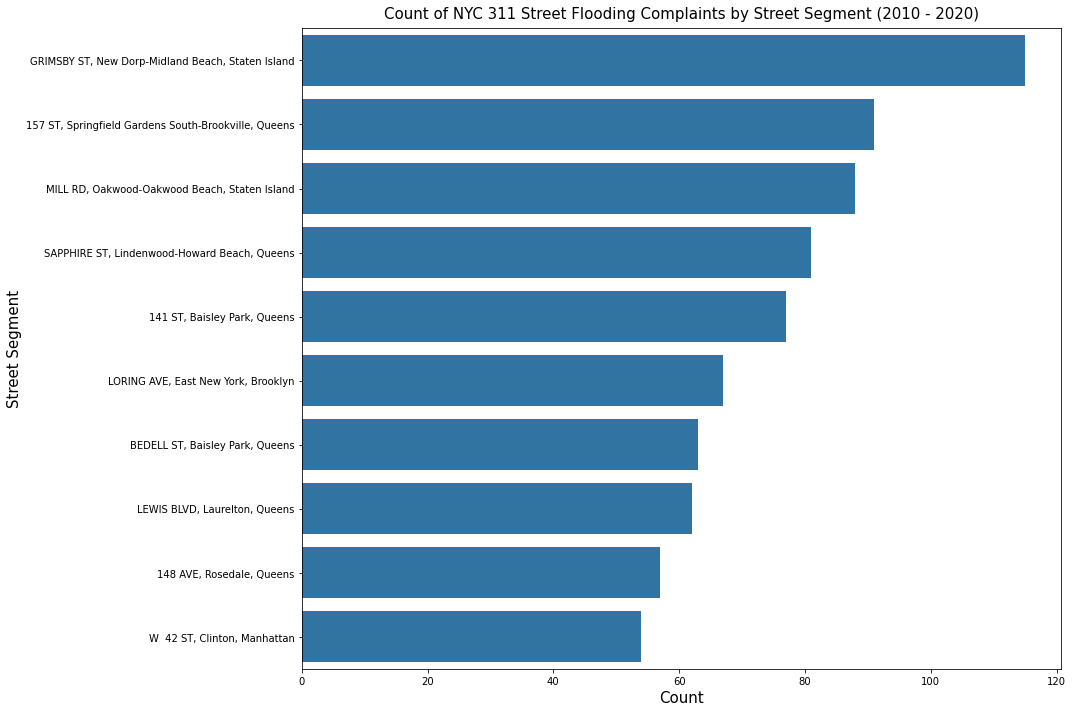

In [310]:
plt.figure(figsize=(15,10))

sns.barplot(data=count_by_nta.sort_values(by='count', ascending=False).head(10),
            y='with_nta_name',
            x='count',
            color='#1f77b4')

plt.title('Count of NYC 311 Street Flooding Complaints by Street Segment (2010 - 2020)', 
          fontsize=15,
          pad=10)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Street Segment', fontsize=15)
plt.tight_layout()

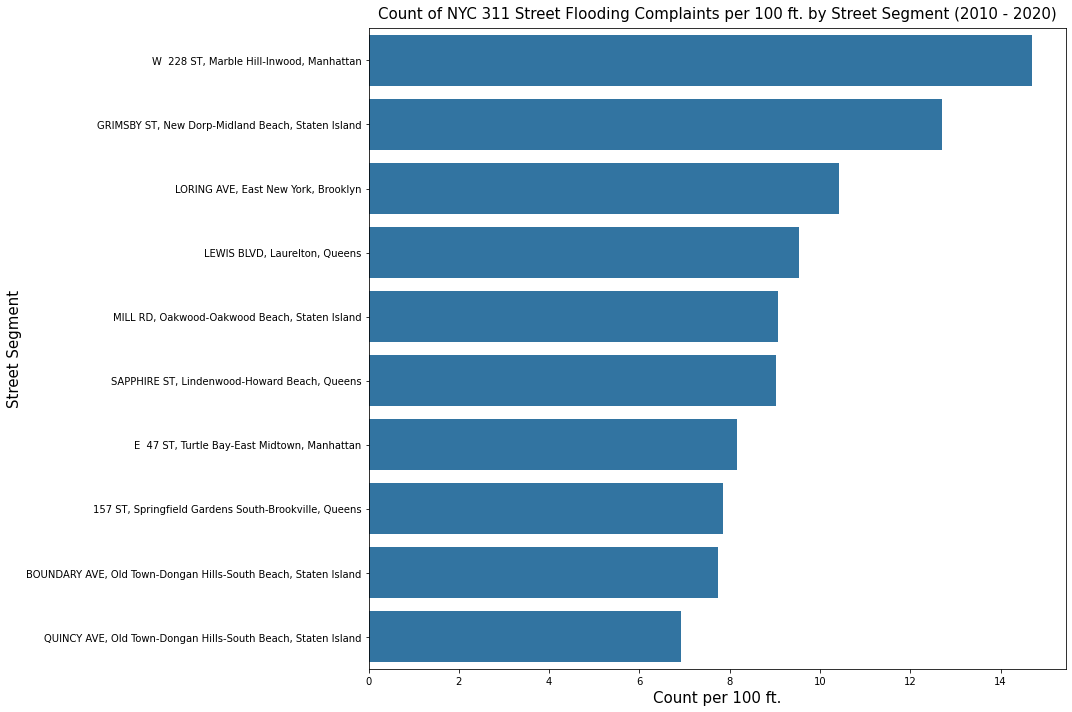

In [311]:
plt.figure(figsize=(15,10))

sns.barplot(data=count_by_nta.sort_values(by='count_per_100ft', ascending=False).head(10),
            y='with_nta_name',
            x='count_per_100ft',
            color='#1f77b4')

plt.title('Count of NYC 311 Street Flooding Complaints per 100 ft. by Street Segment (2010 - 2020)', 
          fontsize=15,
          pad=10)
plt.xlabel('Count per 100 ft.', fontsize=15)
plt.ylabel('Street Segment', fontsize=15)
plt.tight_layout()

plt.savefig('figures/count_per_length.png')

## Case Studies

## 1) Hammels, Arverne, and Edgemere, Queens and 2) New Dorp - Midland Beach, Staten Island

In [312]:
top_nta = gpd.GeoDataFrame(flooding_311, 
                           geometry=gpd.points_from_xy(flooding_311.x_coordinate_state_plane, 
                                                       flooding_311.y_coordinate_state_plane))

top_nta.head()

unique_key             created_date              closed_date agency  \
0    40140533  2018-08-29T08:35:00.000  2018-09-08T12:40:00.000    DEP   
1    40141782  2018-08-29T10:29:00.000  2018-08-30T09:40:00.000    DEP   
2    40143144  2018-08-29T18:36:00.000  2018-09-01T08:40:00.000    DEP   
3    40145580  2018-08-30T14:58:00.000  2018-09-04T11:25:00.000    DEP   
4    40148030  2018-08-30T19:37:00.000  2018-09-05T08:30:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       10034.0       WEST 206 STREET   
1  Street Flooding (SJ)       11235.0                   NaN   
2  Street Flooding (SJ)       10458.0                   NaN   
3  Street Flooding (SJ)       11204.0                   NaN   
4  Street Flooding (SJ)       11208.0                   NaN   

  intersection_street_2  ... park_borough   latitude  longitude  \
0              9 AVENUE  ...    MANHATTAN  40.863021 -73.917557   
1                   NaN  ...     BROOKLYN  40.592140 -73.943240   
2                   NaN  ...        BRONX  40.864814 -73.892048   
3                   NaN  ...     BROOKLYN  40.623757 -73.988545   
4                   NaN  ...     BROOKLYN  40.684147 -73.873386   

                                            location        incident_address  \
0  {'latitude': '40.8630205', 'longitude': '-73.9...                     NaN   
1  {'latitude': '40.5921398', 'longitude': '-73.9...     2468 EAST 27 STREET   
2  {'latitude': '40.8648137', 'longitude': '-73.8...  2641 BAINBRIDGE AVENUE   
3  {'latitude': '40.6237568', 'longitude': '-73.9...          1701 59 STREET   
4  {'latitude': '40.684147', 'longitude': '-73.87...         103 PINE STREET   

         street_name cross_street_1  cross_street_2           bbl  \
0                NaN            NaN             NaN           NaN   
1     EAST 27 STREET       AVENUE X        AVENUE Y  3.074221e+09   
2  BAINBRIDGE AVENUE       E 194 ST        E 196 ST  2.032940e+09   
3          59 STREET         17 AVE          18 AVE  3.055040e+09   
4        PINE STREET  RIDGEWOOD AVE       FULTON ST  3.041300e+09   

                         geometry  
0  POINT (1007054.000 253710.000)  
1  POINT (1000014.000 155014.000)  
2  POINT (1014109.000 254371.000)  
3   POINT (987430.000 166528.000)  
4  POINT (1019366.000 188555.000)  

[5 rows x 31 columns]

In [313]:
top_nta.set_crs(epsg=2263, inplace=True)
top_nta.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

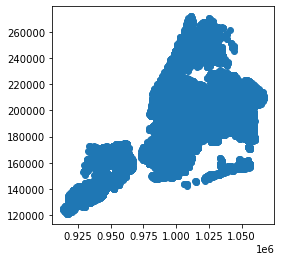

In [314]:
top_nta.plot()

In [315]:
gdf.shape

(26872, 36)

In [316]:
top_nta = gpd.sjoin(top_nta, 
                    nta_shape, 
                    how="inner", 
                    op='within')

In [317]:
top_nta.head()

unique_key             created_date              closed_date agency  \
0       40140533  2018-08-29T08:35:00.000  2018-09-08T12:40:00.000    DEP   
13      40203741  2018-09-06T18:34:00.000  2018-09-08T12:25:00.000    DEP   
1971    42223076  2019-04-14T10:33:00.000  2019-04-17T11:00:00.000    DEP   
1973    42224479  2019-04-14T10:36:00.000  2019-04-17T11:25:00.000    DEP   
5920    20549194  2011-06-01T07:59:00.000  2011-06-03T16:00:00.000    DEP   

                                 agency_name complaint_type  \
0     Department of Environmental Protection          Sewer   
13    Department of Environmental Protection          Sewer   
1971  Department of Environmental Protection          Sewer   
1973  Department of Environmental Protection          Sewer   
5920  Department of Environmental Protection          Sewer   

                descriptor  incident_zip intersection_street_1  \
0     Street Flooding (SJ)       10034.0       WEST 206 STREET   
13    Street Flooding (SJ)       10034.0              9 AVENUE   
1971  Street Flooding (SJ)       10034.0                   NaN   
1973  Street Flooding (SJ)       10034.0                   NaN   
5920  Street Flooding (SJ)       10034.0       WEST 207 STREET   

     intersection_street_2  ...           bbl                        geometry  \
0                 9 AVENUE  ...           NaN  POINT (1007054.000 253710.000)   
13         WEST 220 STREET  ...           NaN  POINT (1008802.000 256858.000)   
1971                   NaN  ...  1.022268e+09  POINT (1006343.000 254787.000)   
1973                   NaN  ...  1.022260e+09  POINT (1006135.000 254606.000)   
5920           POST AVENUE  ...           NaN  POINT (1006554.000 254361.000)   

     index_right ntacode     shape_area county_fips             ntaname  \
0             80    MN01  17732688.6953         061  Marble Hill-Inwood   
13            80    MN01  17732688.6953         061  Marble Hill-Inwood   
1971          80    MN01  17732688.6953         061  Marble Hill-Inwood   
1973          80    MN01  17732688.6953         061  Marble Hill-Inwood   
5920          80    MN01  17732688.6953         061  Marble Hill-Inwood   

         shape_leng  boro_name boro_code  
0     31844.4094213  Manhattan         1  
13    31844.4094213  Manhattan         1  
1971  31844.4094213  Manhattan         1  
1973  31844.4094213  Manhattan         1  
5920  31844.4094213  Manhattan         1  

[5 rows x 39 columns]

# Neighborhoods with the most street flooding complaints

In [318]:
top_nta.groupby(by='ntaname')['unique_key'].count().reset_index().sort_values('unique_key', ascending=False).head(2)

ntaname  unique_key
116    New Dorp-Midland Beach         761
80   Hammels-Arverne-Edgemere         696

## Hammels, Arverne, and Edgemere, Queens

In [319]:
gdf = gpd.GeoDataFrame(flooding_311, 
                       geometry=gpd.points_from_xy(flooding_311.x_coordinate_state_plane, 
                                                   flooding_311.y_coordinate_state_plane))

In [320]:
gdf.head()

unique_key             created_date              closed_date agency  \
0    40140533  2018-08-29T08:35:00.000  2018-09-08T12:40:00.000    DEP   
1    40141782  2018-08-29T10:29:00.000  2018-08-30T09:40:00.000    DEP   
2    40143144  2018-08-29T18:36:00.000  2018-09-01T08:40:00.000    DEP   
3    40145580  2018-08-30T14:58:00.000  2018-09-04T11:25:00.000    DEP   
4    40148030  2018-08-30T19:37:00.000  2018-09-05T08:30:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       10034.0       WEST 206 STREET   
1  Street Flooding (SJ)       11235.0                   NaN   
2  Street Flooding (SJ)       10458.0                   NaN   
3  Street Flooding (SJ)       11204.0                   NaN   
4  Street Flooding (SJ)       11208.0                   NaN   

  intersection_street_2  ... park_borough   latitude  longitude  \
0              9 AVENUE  ...    MANHATTAN  40.863021 -73.917557   
1                   NaN  ...     BROOKLYN  40.592140 -73.943240   
2                   NaN  ...        BRONX  40.864814 -73.892048   
3                   NaN  ...     BROOKLYN  40.623757 -73.988545   
4                   NaN  ...     BROOKLYN  40.684147 -73.873386   

                                            location        incident_address  \
0  {'latitude': '40.8630205', 'longitude': '-73.9...                     NaN   
1  {'latitude': '40.5921398', 'longitude': '-73.9...     2468 EAST 27 STREET   
2  {'latitude': '40.8648137', 'longitude': '-73.8...  2641 BAINBRIDGE AVENUE   
3  {'latitude': '40.6237568', 'longitude': '-73.9...          1701 59 STREET   
4  {'latitude': '40.684147', 'longitude': '-73.87...         103 PINE STREET   

         street_name cross_street_1  cross_street_2           bbl  \
0                NaN            NaN             NaN           NaN   
1     EAST 27 STREET       AVENUE X        AVENUE Y  3.074221e+09   
2  BAINBRIDGE AVENUE       E 194 ST        E 196 ST  2.032940e+09   
3          59 STREET         17 AVE          18 AVE  3.055040e+09   
4        PINE STREET  RIDGEWOOD AVE       FULTON ST  3.041300e+09   

                         geometry  
0  POINT (1007054.000 253710.000)  
1  POINT (1000014.000 155014.000)  
2  POINT (1014109.000 254371.000)  
3   POINT (987430.000 166528.000)  
4  POINT (1019366.000 188555.000)  

[5 rows x 31 columns]

In [321]:
gdf.set_crs(epsg=2263, inplace=True)
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

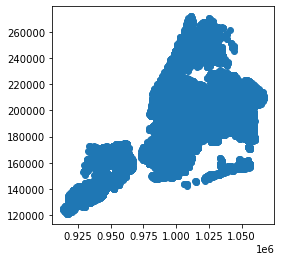

In [322]:
gdf.plot()

In [323]:
gdf.shape

(26874, 31)

In [324]:
gdf = gpd.sjoin(gdf, 
                nta_shape, 
                how="inner", 
                op='within')

In [325]:
gdf.head()

unique_key             created_date              closed_date agency  \
0       40140533  2018-08-29T08:35:00.000  2018-09-08T12:40:00.000    DEP   
13      40203741  2018-09-06T18:34:00.000  2018-09-08T12:25:00.000    DEP   
1971    42223076  2019-04-14T10:33:00.000  2019-04-17T11:00:00.000    DEP   
1973    42224479  2019-04-14T10:36:00.000  2019-04-17T11:25:00.000    DEP   
5920    20549194  2011-06-01T07:59:00.000  2011-06-03T16:00:00.000    DEP   

                                 agency_name complaint_type  \
0     Department of Environmental Protection          Sewer   
13    Department of Environmental Protection          Sewer   
1971  Department of Environmental Protection          Sewer   
1973  Department of Environmental Protection          Sewer   
5920  Department of Environmental Protection          Sewer   

                descriptor  incident_zip intersection_street_1  \
0     Street Flooding (SJ)       10034.0       WEST 206 STREET   
13    Street Flooding (SJ)       10034.0              9 AVENUE   
1971  Street Flooding (SJ)       10034.0                   NaN   
1973  Street Flooding (SJ)       10034.0                   NaN   
5920  Street Flooding (SJ)       10034.0       WEST 207 STREET   

     intersection_street_2  ...           bbl                        geometry  \
0                 9 AVENUE  ...           NaN  POINT (1007054.000 253710.000)   
13         WEST 220 STREET  ...           NaN  POINT (1008802.000 256858.000)   
1971                   NaN  ...  1.022268e+09  POINT (1006343.000 254787.000)   
1973                   NaN  ...  1.022260e+09  POINT (1006135.000 254606.000)   
5920           POST AVENUE  ...           NaN  POINT (1006554.000 254361.000)   

     index_right ntacode     shape_area county_fips             ntaname  \
0             80    MN01  17732688.6953         061  Marble Hill-Inwood   
13            80    MN01  17732688.6953         061  Marble Hill-Inwood   
1971          80    MN01  17732688.6953         061  Marble Hill-Inwood   
1973          80    MN01  17732688.6953         061  Marble Hill-Inwood   
5920          80    MN01  17732688.6953         061  Marble Hill-Inwood   

         shape_leng  boro_name boro_code  
0     31844.4094213  Manhattan         1  
13    31844.4094213  Manhattan         1  
1971  31844.4094213  Manhattan         1  
1973  31844.4094213  Manhattan         1  
5920  31844.4094213  Manhattan         1  

[5 rows x 39 columns]

In [326]:
gdf.drop(columns=["shape_leng", 'shape_area'], inplace=True)

In [327]:
ls data/

311-flooding-data.csv  streets_clipped.json


In [328]:
path = 'data/streets_clipped.json'
streets = gpd.read_file(path)

streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [329]:
streets.shape

(99354, 12)

<AxesSubplot:>

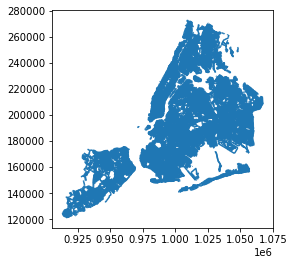

In [330]:
streets.plot()

In [331]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99354 entries, 0 to 99353
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99354 non-null  object  
 1   st_label      99354 non-null  object  
 2   st_name       99354 non-null  object  
 3   full_stree    99354 non-null  object  
 4   rw_type       99354 non-null  object  
 5   rw_type_name  99354 non-null  object  
 6   st_width      99354 non-null  object  
 7   frm_lvl_co    99354 non-null  object  
 8   to_lvl_co     99354 non-null  object  
 9   borocode      99354 non-null  object  
 10  shape_leng    99354 non-null  float64 
 11  geometry      99354 non-null  geometry
dtypes: float64(1), geometry(1), object(10)
memory usage: 9.1+ MB


In [332]:
streets.describe()

shape_leng
count  9.935400e+04
mean   3.431337e+02
std    2.620169e+02
min    1.068681e-08
25%    1.953887e+02
50%    2.648512e+02
75%    4.583294e+02
max    1.509366e+04

In [333]:
streets.geom_type.value_counts()

LineString    99354
dtype: int64

In [334]:
streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [335]:
Hammels_Arverne_Edgemere = nta_shape[nta_shape.ntaname == 'Hammels-Arverne-Edgemere']

In [336]:
# clipping the school points that only fall within the nta shapes
streets_clipped = gpd.clip(streets, Hammels_Arverne_Edgemere)

<AxesSubplot:>

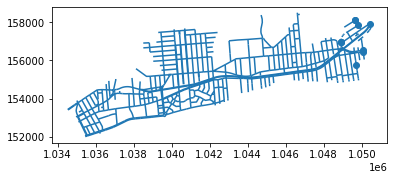

In [337]:
streets_clipped.plot()

In [338]:
streets_clipped.geom_type.value_counts()

LineString            843
Point                   9
MultiLineString         2
GeometryCollection      1
dtype: int64

In [339]:
streets_clipped = streets_clipped[streets_clipped.geom_type == 'LineString']

streets_clipped.geom_type.value_counts()

LineString    843
dtype: int64

In [340]:
# clipping the school points that only fall within the nta shapes
Hammels_Arverne_Edgemere = gpd.clip(gdf, 
                                    Hammels_Arverne_Edgemere)

<AxesSubplot:>

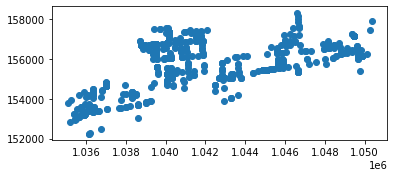

In [341]:
Hammels_Arverne_Edgemere.plot()

In [342]:
Hammels_Arverne_Edgemere.geom_type.value_counts()

Point    696
dtype: int64

# Snap points to streets

# https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa

In [343]:
streets_clipped.sindex

rtree.index.Index(bounds=[1034529.2977429869, 151996.05628808722, 1050540.0391240292, 158513.33282463337], size=843)

In [344]:
offset = 80

bbox = Hammels_Arverne_Edgemere.bounds + [-offset, -offset, offset, offset]

bbox.head()

minx      miny       maxx      maxy
42  1036947.0  154733.0  1037107.0  154893.0
55  1043239.0  154980.0  1043399.0  155140.0
57  1036947.0  154733.0  1037107.0  154893.0
77  1036920.0  154637.0  1037080.0  154797.0
79  1036721.0  154308.0  1036881.0  154468.0

In [345]:
hits = bbox.apply(lambda row: list(streets_clipped.sindex.intersection(row)), axis=1)

hits.head()

42                                  [12]
55                            [507, 117]
57                                  [12]
77                                  [12]
79    [648, 639, 775, 82, 806, 536, 231]
dtype: object

In [346]:
hits.shape

(696,)

In [347]:
tmp = pd.DataFrame(
    {
    # index of points table
    "pt_idx": np.repeat(hits.index, hits.apply(len)),
        
    # ordinal position of line - access via iloc later
    "line_i": np.concatenate(hits.values)
    })

In [348]:
tmp.head()

pt_idx  line_i
0      42    12.0
1      55   507.0
2      55   117.0
3      57    12.0
4      77    12.0

In [349]:
tmp.shape

(2141, 2)

In [350]:
streets_clipped.shape

(843, 12)

In [351]:
streets_clipped.head()

physicalid             st_label         st_name          full_stree  \
41        92035            BCH 66 ST            B 66             B 66 ST   
252       14294            BCH 74 ST            B 74             B 74 ST   
347       14034  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE   
506      154483  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE   
1016      92062            BCH 87 ST            B 87             B 87 ST   

     rw_type rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
41         1       Street       42         13        13        4  495.233090   
252        1       Street       30         13        13        4  623.015421   
347        1       Street       35         13        13        4  234.071915   
506        1       Street       31         13        13        4  255.930554   
1016       1       Street       24         13        13        4  186.284190   

                                               geometry  
41    LINESTRING (1041022.181 156864.681, 1040981.69...  
252   LINESTRING (1039173.301 154571.323, 1039121.22...  
347   LINESTRING (1046371.747 155628.532, 1046139.47...  
506   LINESTRING (1041944.905 154892.163, 1041702.46...  
1016  LINESTRING (1036423.096 153354.452, 1036408.71...

In [352]:
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(streets_clipped.reset_index(drop=True), 
               on="line_i")

tmp.head()

pt_idx  line_i physicalid             st_label         st_name  \
0      42    12.0      89897            BCH 84 ST            B 84   
1      55   507.0      14096  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH   
2      55   117.0     168722         ROCKAWAY FWY        ROCKAWAY   
3      57    12.0      89897            BCH 84 ST            B 84   
4      77    12.0      89897            BCH 84 ST            B 84   

           full_stree rw_type rw_type_name st_width frm_lvl_co to_lvl_co  \
0             B 84 ST       1       Street       20         13        13   
1  ROCKAWAY BEACH AVE       1       Street       38         13        13   
2        ROCKAWAY FWY       1       Street       25         13        13   
3             B 84 ST       1       Street       20         13        13   
4             B 84 ST       1       Street       20         13        13   

  borocode  shape_leng                                           geometry  
0        4  581.197914  LINESTRING (1036945.986 154458.262, 1037059.20...  
1        4  664.392053  LINESTRING (1043530.411 155056.572, 1043233.92...  
2        4  663.512771  LINESTRING (1043532.891 155124.954, 1043352.95...  
3        4  581.197914  LINESTRING (1036945.986 154458.262, 1037059.20...  
4        4  581.197914  LINESTRING (1036945.986 154458.262, 1037059.20...

In [353]:
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(Hammels_Arverne_Edgemere.geometry.rename("point"), 
               on="pt_idx")

# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(tmp, 
                       geometry="geometry", 
                       crs=Hammels_Arverne_Edgemere.crs)

In [354]:
tmp.head()

pt_idx  line_i physicalid             st_label         st_name  \
0      42    12.0      89897            BCH 84 ST            B 84   
1      55   507.0      14096  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH   
2      55   117.0     168722         ROCKAWAY FWY        ROCKAWAY   
3      57    12.0      89897            BCH 84 ST            B 84   
4      77    12.0      89897            BCH 84 ST            B 84   

           full_stree rw_type rw_type_name st_width frm_lvl_co to_lvl_co  \
0             B 84 ST       1       Street       20         13        13   
1  ROCKAWAY BEACH AVE       1       Street       38         13        13   
2        ROCKAWAY FWY       1       Street       25         13        13   
3             B 84 ST       1       Street       20         13        13   
4             B 84 ST       1       Street       20         13        13   

  borocode  shape_leng                                           geometry  \
0        4  581.197914  LINESTRING (1036945.986 154458.262, 1037059.20...   
1        4  664.392053  LINESTRING (1043530.411 155056.572, 1043233.92...   
2        4  663.512771  LINESTRING (1043532.891 155124.954, 1043352.95...   
3        4  581.197914  LINESTRING (1036945.986 154458.262, 1037059.20...   
4        4  581.197914  LINESTRING (1036945.986 154458.262, 1037059.20...   

                            point  
0  POINT (1037027.000 154813.000)  
1  POINT (1043319.000 155060.000)  
2  POINT (1043319.000 155060.000)  
3  POINT (1037027.000 154813.000)  
4  POINT (1037000.000 154717.000)

In [355]:
tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))

tmp[['snap_dist']].describe()

snap_dist
count  2141.000000
mean     32.960082
std      49.775521
min       0.004010
25%       0.491634
50%       7.268701
75%      57.602492
max     377.414126

In [356]:
# Discard any lines that are greater than tolerance from points
tmp = tmp.loc[tmp.snap_dist <= offset]

# Sort on ascending snap distance, so that closest goes to top
tmp = tmp.sort_values(by=["snap_dist"])

tmp.head()

pt_idx  line_i physicalid        st_label  st_name      full_stree  \
1920   25735   312.0      14365  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR   
1174   16751   413.0      80917       BCH 48 ST       48       BCH 48 ST   
1732   22166   413.0      80917       BCH 48 ST       48       BCH 48 ST   
1483   21058   413.0      80917       BCH 48 ST       48       BCH 48 ST   
1577   22013   334.0      14195  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR   

     rw_type rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
1920       1       Street       50         13        13        4  261.689492   
1174       1       Street       30         13        13        4  570.432126   
1732       1       Street       30         13        13        4  570.432126   
1483       1       Street       30         13        13        4  570.432126   
1577       1       Street       52         13        13        4  308.269676   

                                               geometry  \
1920  LINESTRING (1043336.353 156058.630, 1043104.72...   
1174  LINESTRING (1045615.013 156289.929, 1045564.12...   
1732  LINESTRING (1045615.013 156289.929, 1045564.12...   
1483  LINESTRING (1045615.013 156289.929, 1045564.12...   
1577  LINESTRING (1038297.735 154234.529, 1037989.55...   

                               point  snap_dist  
1920  POINT (1043105.000 155937.000)   0.004010  
1174  POINT (1045615.000 156290.000)   0.006761  
1732  POINT (1045615.000 156290.000)   0.006761  
1483  POINT (1045615.000 156290.000)   0.006761  
1577  POINT (1037990.000 154242.000)   0.011789

In [357]:
tmp[['snap_dist']].describe()

snap_dist
count  1846.000000
mean     17.013918
std      23.916537
min       0.004010
25%       0.446798
50%       3.184132
75%      21.744168
max      78.864107

In [358]:
# group by the index of the points and take the first, which is the closest line 
closest = tmp.groupby("pt_idx").first()

# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")

closest.head()

line_i physicalid             st_label         st_name  \
pt_idx                                                           
42        12.0      89897            BCH 84 ST            B 84   
55       507.0      14096  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH   
57        12.0      89897            BCH 84 ST            B 84   
77        12.0      89897            BCH 84 ST            B 84   
79       639.0      14726       BCH CHANNEL DR         CHANNEL   

                full_stree rw_type rw_type_name st_width frm_lvl_co to_lvl_co  \
pt_idx                                                                          
42                 B 84 ST       1       Street       20         13        13   
55      ROCKAWAY BEACH AVE       1       Street       38         13        13   
57                 B 84 ST       1       Street       20         13        13   
77                 B 84 ST       1       Street       20         13        13   
79          BCH CHANNEL DR       1       Street       52         13        13   

       borocode  shape_leng  \
pt_idx                        
42            4  581.197914   
55            4  664.392053   
57            4  581.197914   
77            4  581.197914   
79            4  112.892653   

                                                 geometry  \
pt_idx                                                      
42      LINESTRING (1036945.986 154458.262, 1037059.20...   
55      LINESTRING (1043530.411 155056.572, 1043233.92...   
57      LINESTRING (1036945.986 154458.262, 1037059.20...   
77      LINESTRING (1036945.986 154458.262, 1037059.20...   
79      LINESTRING (1036839.965 154450.854, 1036727.07...   

                                 point  snap_dist  
pt_idx                                             
42      POINT (1037027.000 154813.000)   3.249246  
55      POINT (1043319.000 155060.000)   3.251238  
57      POINT (1037027.000 154813.000)   3.249246  
77      POINT (1037000.000 154717.000)   2.588239  
79      POINT (1036801.000 154388.000)  62.595829

In [359]:
# Position of nearest point from start of the line
pos = closest.geometry.project(gpd.GeoSeries(closest.point))

# Get new point location geometry
new_pts = closest.geometry.interpolate(pos)

new_pts.head()

pt_idx
42    POINT (1037023.826 154813.695)
55    POINT (1043319.103 155063.250)
57    POINT (1037023.826 154813.695)
77    POINT (1037002.528 154716.446)
79    POINT (1036800.587 154450.594)
dtype: geometry

In [360]:
# Create a new GeoDataFrame from the columns from the closest line and 
# new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(closest, 
                           geometry=new_pts)

snapped.head()

line_i physicalid             st_label         st_name  \
pt_idx                                                           
42        12.0      89897            BCH 84 ST            B 84   
55       507.0      14096  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH   
57        12.0      89897            BCH 84 ST            B 84   
77        12.0      89897            BCH 84 ST            B 84   
79       639.0      14726       BCH CHANNEL DR         CHANNEL   

                full_stree rw_type rw_type_name st_width frm_lvl_co to_lvl_co  \
pt_idx                                                                          
42                 B 84 ST       1       Street       20         13        13   
55      ROCKAWAY BEACH AVE       1       Street       38         13        13   
57                 B 84 ST       1       Street       20         13        13   
77                 B 84 ST       1       Street       20         13        13   
79          BCH CHANNEL DR       1       Street       52         13        13   

       borocode  shape_leng                        geometry  \
pt_idx                                                        
42            4  581.197914  POINT (1037023.826 154813.695)   
55            4  664.392053  POINT (1043319.103 155063.250)   
57            4  581.197914  POINT (1037023.826 154813.695)   
77            4  581.197914  POINT (1037002.528 154716.446)   
79            4  112.892653  POINT (1036800.587 154450.594)   

                                 point  snap_dist  
pt_idx                                             
42      POINT (1037027.000 154813.000)   3.249246  
55      POINT (1043319.000 155060.000)   3.251238  
57      POINT (1037027.000 154813.000)   3.249246  
77      POINT (1037000.000 154717.000)   2.588239  
79      POINT (1036801.000 154388.000)  62.595829

In [361]:
Hammels_Arverne_Edgemere.head()

unique_key             created_date              closed_date agency  \
42    40233378  2018-09-09T22:50:00.000  2018-09-14T22:50:00.000    DEP   
55    40240260  2018-09-10T10:18:00.000  2018-09-10T10:19:00.000    DEP   
57    40241238  2018-09-10T11:20:00.000  2018-09-10T14:36:00.000    DEP   
77    40249007  2018-09-11T11:01:00.000  2018-09-16T11:01:00.000    DEP   
79    40250213  2018-09-11T12:14:00.000  2018-09-12T13:40:00.000    DEP   

                               agency_name complaint_type  \
42  Department of Environmental Protection          Sewer   
55  Department of Environmental Protection          Sewer   
57  Department of Environmental Protection          Sewer   
77  Department of Environmental Protection          Sewer   
79  Department of Environmental Protection          Sewer   

              descriptor  incident_zip intersection_street_1  \
42  Street Flooding (SJ)       11693.0                   NaN   
55  Street Flooding (SJ)       11692.0                   NaN   
57  Street Flooding (SJ)       11693.0                   NaN   
77  Street Flooding (SJ)       11693.0                   NaN   
79  Street Flooding (SJ)       11693.0                   NaN   

   intersection_street_2  ...    cross_street_1          cross_street_2  \
42                   NaN  ...  BEACH CHANNEL DR  LONG BAR BAY SHORELINE   
55                   NaN  ...       BEACH 56 PL             BEACH 59 ST   
57                   NaN  ...  BEACH CHANNEL DR  LONG BAR BAY SHORELINE   
77                   NaN  ...  BEACH CHANNEL DR  LONG BAR BAY SHORELINE   
79                   NaN  ...           JAVA PL        BEACH CHANNEL DR   

             bbl                        geometry index_right ntacode  \
42  4.161030e+09  POINT (1037027.000 154813.000)         131    QN12   
55  4.159260e+09  POINT (1043319.000 155060.000)         131    QN12   
57  4.161030e+09  POINT (1037027.000 154813.000)         131    QN12   
77  4.161100e+09  POINT (1037000.000 154717.000)         131    QN12   
79  4.161160e+09  POINT (1036801.000 154388.000)         131    QN12   

   county_fips                   ntaname  boro_name boro_code  
42         081  Hammels-Arverne-Edgemere     Queens         4  
55         081  Hammels-Arverne-Edgemere     Queens         4  
57         081  Hammels-Arverne-Edgemere     Queens         4  
77         081  Hammels-Arverne-Edgemere     Queens         4  
79         081  Hammels-Arverne-Edgemere     Queens         4  

[5 rows x 37 columns]

In [362]:
Hammels_Arverne_Edgemere.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 696 entries, 42 to 27629
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      696 non-null    int64   
 1   created_date                    696 non-null    object  
 2   closed_date                     696 non-null    object  
 3   agency                          696 non-null    object  
 4   agency_name                     696 non-null    object  
 5   complaint_type                  696 non-null    object  
 6   descriptor                      696 non-null    object  
 7   incident_zip                    696 non-null    float64 
 8   intersection_street_1           208 non-null    object  
 9   intersection_street_2           208 non-null    object  
 10  address_type                    696 non-null    object  
 11  city                            696 non-null    object  
 12  status     

In [363]:
Hammels_Arverne_Edgemere.drop(columns=["geometry"], inplace=True)

In [364]:
Hammels_Arverne_Edgemere.head()

unique_key             created_date              closed_date agency  \
42    40233378  2018-09-09T22:50:00.000  2018-09-14T22:50:00.000    DEP   
55    40240260  2018-09-10T10:18:00.000  2018-09-10T10:19:00.000    DEP   
57    40241238  2018-09-10T11:20:00.000  2018-09-10T14:36:00.000    DEP   
77    40249007  2018-09-11T11:01:00.000  2018-09-16T11:01:00.000    DEP   
79    40250213  2018-09-11T12:14:00.000  2018-09-12T13:40:00.000    DEP   

                               agency_name complaint_type  \
42  Department of Environmental Protection          Sewer   
55  Department of Environmental Protection          Sewer   
57  Department of Environmental Protection          Sewer   
77  Department of Environmental Protection          Sewer   
79  Department of Environmental Protection          Sewer   

              descriptor  incident_zip intersection_street_1  \
42  Street Flooding (SJ)       11693.0                   NaN   
55  Street Flooding (SJ)       11692.0                   NaN   
57  Street Flooding (SJ)       11693.0                   NaN   
77  Street Flooding (SJ)       11693.0                   NaN   
79  Street Flooding (SJ)       11693.0                   NaN   

   intersection_street_2  ...               street_name    cross_street_1  \
42                   NaN  ...           BEACH 84 STREET  BEACH CHANNEL DR   
55                   NaN  ...  ROCKAWAY BEACH BOULEVARD       BEACH 56 PL   
57                   NaN  ...           BEACH 84 STREET  BEACH CHANNEL DR   
77                   NaN  ...           BEACH 84 STREET  BEACH CHANNEL DR   
79                   NaN  ...           BEACH 85 STREET           JAVA PL   

            cross_street_2           bbl index_right ntacode county_fips  \
42  LONG BAR BAY SHORELINE  4.161030e+09         131    QN12         081   
55             BEACH 59 ST  4.159260e+09         131    QN12         081   
57  LONG BAR BAY SHORELINE  4.161030e+09         131    QN12         081   
77  LONG BAR BAY SHORELINE  4.161100e+09         131    QN12         081   
79        BEACH CHANNEL DR  4.161160e+09         131    QN12         081   

                     ntaname  boro_name boro_code  
42  Hammels-Arverne-Edgemere     Queens         4  
55  Hammels-Arverne-Edgemere     Queens         4  
57  Hammels-Arverne-Edgemere     Queens         4  
77  Hammels-Arverne-Edgemere     Queens         4  
79  Hammels-Arverne-Edgemere     Queens         4  

[5 rows x 36 columns]

In [365]:
snapped.head()

line_i physicalid             st_label         st_name  \
pt_idx                                                           
42        12.0      89897            BCH 84 ST            B 84   
55       507.0      14096  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH   
57        12.0      89897            BCH 84 ST            B 84   
77        12.0      89897            BCH 84 ST            B 84   
79       639.0      14726       BCH CHANNEL DR         CHANNEL   

                full_stree rw_type rw_type_name st_width frm_lvl_co to_lvl_co  \
pt_idx                                                                          
42                 B 84 ST       1       Street       20         13        13   
55      ROCKAWAY BEACH AVE       1       Street       38         13        13   
57                 B 84 ST       1       Street       20         13        13   
77                 B 84 ST       1       Street       20         13        13   
79          BCH CHANNEL DR       1       Street       52         13        13   

       borocode  shape_leng                        geometry  \
pt_idx                                                        
42            4  581.197914  POINT (1037023.826 154813.695)   
55            4  664.392053  POINT (1043319.103 155063.250)   
57            4  581.197914  POINT (1037023.826 154813.695)   
77            4  581.197914  POINT (1037002.528 154716.446)   
79            4  112.892653  POINT (1036800.587 154450.594)   

                                 point  snap_dist  
pt_idx                                             
42      POINT (1037027.000 154813.000)   3.249246  
55      POINT (1043319.000 155060.000)   3.251238  
57      POINT (1037027.000 154813.000)   3.249246  
77      POINT (1037000.000 154717.000)   2.588239  
79      POINT (1036801.000 154388.000)  62.595829

In [366]:
# Join back to the original points:
updated_points = Hammels_Arverne_Edgemere.join(snapped)

updated_points.head()

unique_key             created_date              closed_date agency  \
42    40233378  2018-09-09T22:50:00.000  2018-09-14T22:50:00.000    DEP   
55    40240260  2018-09-10T10:18:00.000  2018-09-10T10:19:00.000    DEP   
57    40241238  2018-09-10T11:20:00.000  2018-09-10T14:36:00.000    DEP   
77    40249007  2018-09-11T11:01:00.000  2018-09-16T11:01:00.000    DEP   
79    40250213  2018-09-11T12:14:00.000  2018-09-12T13:40:00.000    DEP   

                               agency_name complaint_type  \
42  Department of Environmental Protection          Sewer   
55  Department of Environmental Protection          Sewer   
57  Department of Environmental Protection          Sewer   
77  Department of Environmental Protection          Sewer   
79  Department of Environmental Protection          Sewer   

              descriptor  incident_zip intersection_street_1  \
42  Street Flooding (SJ)       11693.0                   NaN   
55  Street Flooding (SJ)       11692.0                   NaN   
57  Street Flooding (SJ)       11693.0                   NaN   
77  Street Flooding (SJ)       11693.0                   NaN   
79  Street Flooding (SJ)       11693.0                   NaN   

   intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
42                   NaN  ...       1       Street       20         13   
55                   NaN  ...       1       Street       38         13   
57                   NaN  ...       1       Street       20         13   
77                   NaN  ...       1       Street       20         13   
79                   NaN  ...       1       Street       52         13   

   to_lvl_co borocode  shape_leng                        geometry  \
42        13        4  581.197914  POINT (1037023.826 154813.695)   
55        13        4  664.392053  POINT (1043319.103 155063.250)   
57        13        4  581.197914  POINT (1037023.826 154813.695)   
77        13        4  581.197914  POINT (1037002.528 154716.446)   
79        13        4  112.892653  POINT (1036800.587 154450.594)   

                             point  snap_dist  
42  POINT (1037027.000 154813.000)   3.249246  
55  POINT (1043319.000 155060.000)   3.251238  
57  POINT (1037027.000 154813.000)   3.249246  
77  POINT (1037000.000 154717.000)   2.588239  
79  POINT (1036801.000 154388.000)  62.595829  

[5 rows x 51 columns]

In [367]:
updated_points.geometry.isna().sum()

4

In [368]:
# You may want to drop any that didn't snap, if so:
updated_points = updated_points.dropna(subset=["geometry"])

updated_points.head()

unique_key             created_date              closed_date agency  \
42    40233378  2018-09-09T22:50:00.000  2018-09-14T22:50:00.000    DEP   
55    40240260  2018-09-10T10:18:00.000  2018-09-10T10:19:00.000    DEP   
57    40241238  2018-09-10T11:20:00.000  2018-09-10T14:36:00.000    DEP   
77    40249007  2018-09-11T11:01:00.000  2018-09-16T11:01:00.000    DEP   
79    40250213  2018-09-11T12:14:00.000  2018-09-12T13:40:00.000    DEP   

                               agency_name complaint_type  \
42  Department of Environmental Protection          Sewer   
55  Department of Environmental Protection          Sewer   
57  Department of Environmental Protection          Sewer   
77  Department of Environmental Protection          Sewer   
79  Department of Environmental Protection          Sewer   

              descriptor  incident_zip intersection_street_1  \
42  Street Flooding (SJ)       11693.0                   NaN   
55  Street Flooding (SJ)       11692.0                   NaN   
57  Street Flooding (SJ)       11693.0                   NaN   
77  Street Flooding (SJ)       11693.0                   NaN   
79  Street Flooding (SJ)       11693.0                   NaN   

   intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
42                   NaN  ...       1       Street       20         13   
55                   NaN  ...       1       Street       38         13   
57                   NaN  ...       1       Street       20         13   
77                   NaN  ...       1       Street       20         13   
79                   NaN  ...       1       Street       52         13   

   to_lvl_co borocode  shape_leng                        geometry  \
42        13        4  581.197914  POINT (1037023.826 154813.695)   
55        13        4  664.392053  POINT (1043319.103 155063.250)   
57        13        4  581.197914  POINT (1037023.826 154813.695)   
77        13        4  581.197914  POINT (1037002.528 154716.446)   
79        13        4  112.892653  POINT (1036800.587 154450.594)   

                             point  snap_dist  
42  POINT (1037027.000 154813.000)   3.249246  
55  POINT (1043319.000 155060.000)   3.251238  
57  POINT (1037027.000 154813.000)   3.249246  
77  POINT (1037000.000 154717.000)   2.588239  
79  POINT (1036801.000 154388.000)  62.595829  

[5 rows x 51 columns]

In [369]:
updated_points.shape

(692, 51)

In [370]:
updated_points.sort_values(by='snap_dist').head()

unique_key             created_date              closed_date agency  \
25735    37623196  2017-11-06T12:29:00.000  2017-11-06T12:45:00.000    DEP   
16751    25700377  2013-06-08T12:26:00.000  2013-06-09T03:00:00.000    DEP   
22166    32637669  2016-02-09T08:58:00.000  2016-02-09T13:12:00.000    DEP   
21058    31086765  2015-07-15T14:59:00.000  2015-07-16T11:00:00.000    DEP   
22013    32625576  2016-02-08T08:10:00.000  2016-02-08T10:18:00.000    DEP   

                                  agency_name complaint_type  \
25735  Department of Environmental Protection          Sewer   
16751  Department of Environmental Protection          Sewer   
22166  Department of Environmental Protection          Sewer   
21058  Department of Environmental Protection          Sewer   
22013  Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
25735  Street Flooding (SJ)       11692.0   BEACH CHANNEL DRIVE   
16751  Street Flooding (SJ)       11691.0       BEACH 48 STREET   
22166  Street Flooding (SJ)       11691.0   BEACH CHANNEL DRIVE   
21058  Street Flooding (SJ)       11691.0   BEACH CHANNEL DRIVE   
22013  Street Flooding (SJ)       11693.0   BEACH CHANNEL DRIVE   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
25735       BEACH 58 STREET  ...       1       Street       50         13   
16751   BEACH CHANNEL DRIVE  ...       1       Street       30         13   
22166       BEACH 48 STREET  ...       1       Street       30         13   
21058       BEACH 48 STREET  ...       1       Street       30         13   
22013       BEACH 80 STREET  ...       1       Street       52         13   

      to_lvl_co borocode  shape_leng                        geometry  \
25735        13        4  261.689492  POINT (1043105.002 155936.996)   
16751        13        4  570.432126  POINT (1045615.007 156290.001)   
22166        13        4  570.432126  POINT (1045615.007 156290.001)   
21058        13        4  570.432126  POINT (1045615.007 156290.001)   
22013        13        4  308.269676  POINT (1037990.000 154242.012)   

                                point snap_dist  
25735  POINT (1043105.000 155937.000)  0.004010  
16751  POINT (1045615.000 156290.000)  0.006761  
22166  POINT (1045615.000 156290.000)  0.006761  
21058  POINT (1045615.000 156290.000)  0.006761  
22013  POINT (1037990.000 154242.000)  0.011789  

[5 rows x 51 columns]

In [371]:
updated_points.sort_values(by='snap_dist', ascending=False).head()

unique_key             created_date              closed_date agency  \
79       40250213  2018-09-11T12:14:00.000  2018-09-12T13:40:00.000    DEP   
400      40676118  2018-10-27T10:36:00.000  2018-10-27T12:06:00.000    DEP   
19185    28605200  2014-08-02T09:15:00.000  2014-08-02T12:50:00.000    DEP   
16509    25521641  2013-05-10T11:40:00.000  2013-05-11T10:25:00.000    DEP   
16381    25508407  2013-05-08T11:32:00.000  2013-05-08T17:15:00.000    DEP   

                                  agency_name complaint_type  \
79     Department of Environmental Protection          Sewer   
400    Department of Environmental Protection          Sewer   
19185  Department of Environmental Protection          Sewer   
16509  Department of Environmental Protection          Sewer   
16381  Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
79     Street Flooding (SJ)       11693.0                   NaN   
400    Street Flooding (SJ)       11691.0     SEAGIRT BOULEVARD   
19185  Street Flooding (SJ)       11691.0       BEACH 49 STREET   
16509  Street Flooding (SJ)       11693.0                   NaN   
16381  Street Flooding (SJ)       11693.0       BEACH 91 STREET   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
79                      NaN  ...       1       Street       52         13   
400         BEACH 31 STREET  ...       1       Street       46         13   
19185         NORTON AVENUE  ...       1       Street       50         13   
16509                   NaN  ...       1       Street       30         13   
16381   SHORE FRONT PARKWAY  ...       1       Street       30         13   

      to_lvl_co borocode  shape_leng                        geometry  \
79           13        4  112.892653  POINT (1036800.587 154450.594)   
400          13        4  240.190481  POINT (1049836.661 156428.683)   
19185        13        4  430.763995  POINT (1045338.758 156616.404)   
16509        13        4  446.584910  POINT (1036771.745 152480.181)   
16381        13        4  182.433428  POINT (1036197.325 152285.256)   

                                point  snap_dist  
79     POINT (1036801.000 154388.000)  62.595829  
400    POINT (1049831.000 156463.000)  34.780299  
19185  POINT (1045306.000 156614.000)  32.846455  
16509  POINT (1036779.000 152460.000)  21.445682  
16381  POINT (1036204.000 152265.000)  21.327543  

[5 rows x 51 columns]

In [372]:
updated_points[['snap_dist']].describe()

snap_dist
count  692.000000
mean     2.872714
std      4.171727
min      0.004010
25%      0.340039
50%      2.719306
75%      3.246390
max     62.595829

Text(0.5, 1.0, 'Histogram of snap_dist (ft.)')

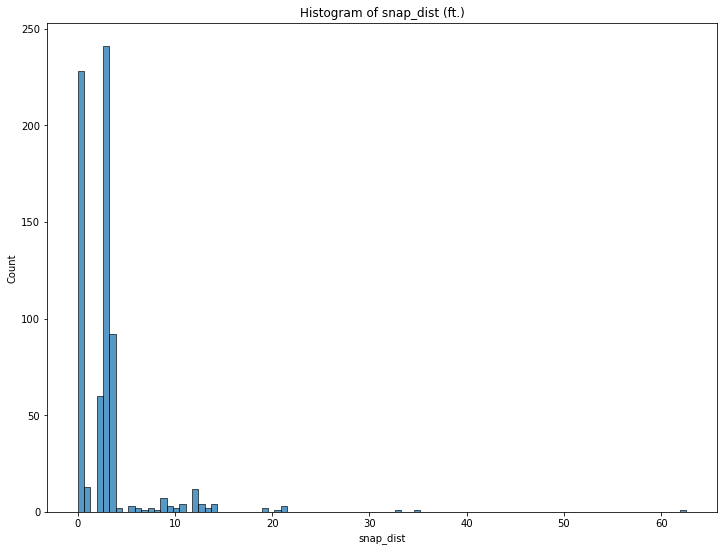

In [373]:
plt.figure(figsize=(12, 9))

sns.histplot(updated_points.snap_dist)
plt.title('Histogram of snap_dist (ft.)')

In [374]:
updated_points.iloc[:, 30:45].head()

index_right ntacode county_fips                   ntaname boro_name  \
42          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
55          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
57          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
77          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
79          131    QN12         081  Hammels-Arverne-Edgemere    Queens   

   boro_code  line_i physicalid             st_label         st_name  \
42         4    12.0      89897            BCH 84 ST            B 84   
55         4   507.0      14096  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH   
57         4    12.0      89897            BCH 84 ST            B 84   
77         4    12.0      89897            BCH 84 ST            B 84   
79         4   639.0      14726       BCH CHANNEL DR         CHANNEL   

            full_stree rw_type rw_type_name st_width frm_lvl_co  
42             B 84 ST       1       Street       20         13  
55  ROCKAWAY BEACH AVE       1       Street       38         13  
57             B 84 ST       1       Street       20         13  
77             B 84 ST       1       Street       20         13  
79      BCH CHANNEL DR       1       Street       52         13

In [375]:
updated_points.physicalid.value_counts()

89897     48
92055     22
168518    22
14104     20
14030     17
          ..
14197      1
14366      1
136845     1
80866      1
14373      1
Name: physicalid, Length: 205, dtype: int64

In [376]:
updated_points.loc[updated_points.physicalid == '89897'].iloc[:, 30:45].head()

index_right ntacode county_fips                   ntaname boro_name  \
42           131    QN12         081  Hammels-Arverne-Edgemere    Queens   
57           131    QN12         081  Hammels-Arverne-Edgemere    Queens   
77           131    QN12         081  Hammels-Arverne-Edgemere    Queens   
80           131    QN12         081  Hammels-Arverne-Edgemere    Queens   
289          131    QN12         081  Hammels-Arverne-Edgemere    Queens   

    boro_code  line_i physicalid   st_label st_name full_stree rw_type  \
42          4    12.0      89897  BCH 84 ST    B 84    B 84 ST       1   
57          4    12.0      89897  BCH 84 ST    B 84    B 84 ST       1   
77          4    12.0      89897  BCH 84 ST    B 84    B 84 ST       1   
80          4    12.0      89897  BCH 84 ST    B 84    B 84 ST       1   
289         4    12.0      89897  BCH 84 ST    B 84    B 84 ST       1   

    rw_type_name st_width frm_lvl_co  
42        Street       20         13  
57        Street       20         13  
77        Street       20         13  
80        Street       20         13  
289       Street       20         13

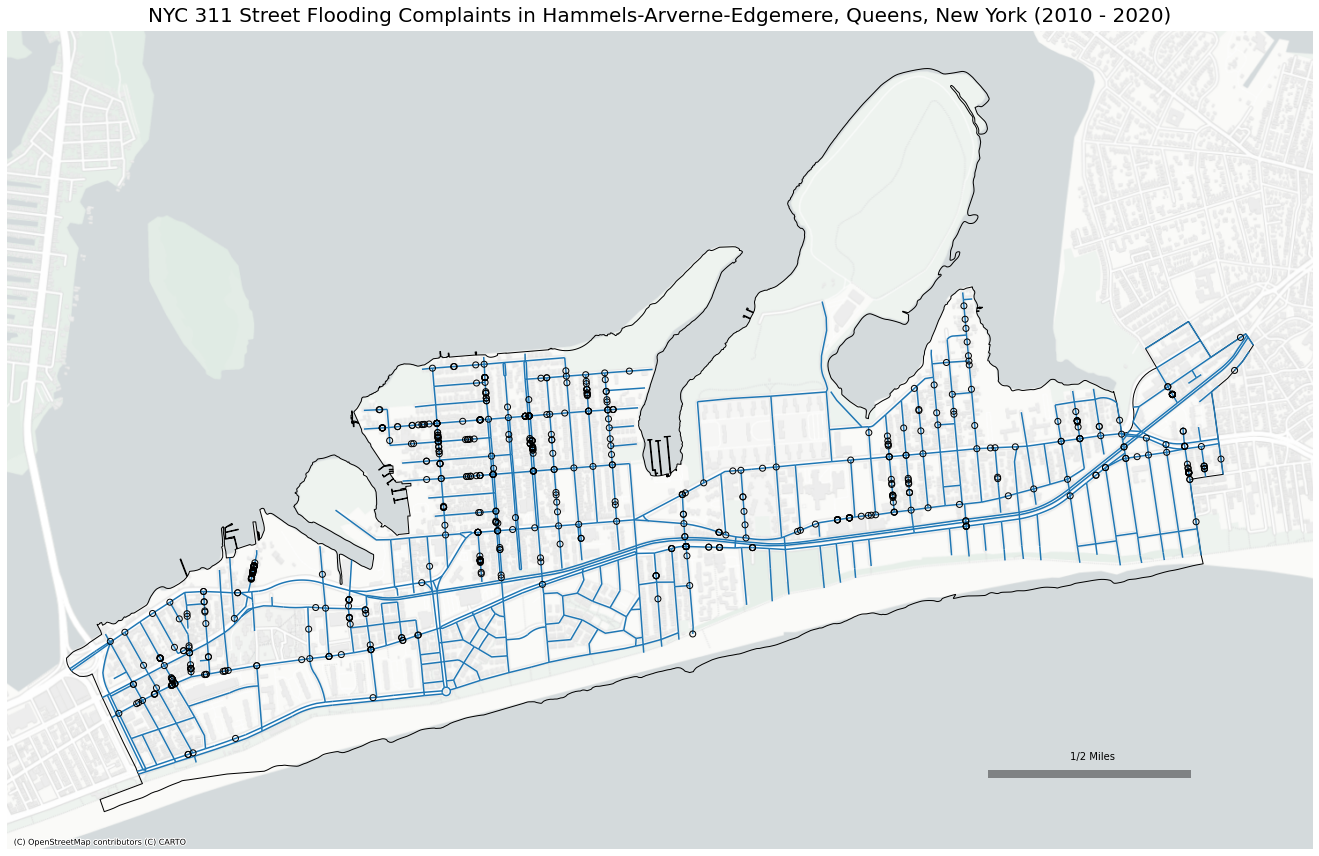

In [377]:
fig, ax = plt.subplots(figsize=(20,12)) # creating a figure

updated_points.plot(color='none', 
                edgecolor='black',
                ax=ax,
                zorder=3)

streets_clipped.plot(ax=ax, zorder=2)

nta_shape[nta_shape.ntaname == 'Hammels-Arverne-Edgemere'].plot(ax=ax, 
                                                                zorder=1, 
                                                                color='None', 
                                                                edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [1047000, 1047000+5280/2], [152000, 152000]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, 
         zorder=3)

# adding the scale bar text to the line
plt.text(1047000 + (5280/2/2.5), 152000 + 200, '1/2 Miles', dict(size=10))

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('NYC 311 Street Flooding Complaints in Hammels-Arverne-Edgemere, Queens, New York (2010 - 2020)', 
             fontsize=20,
             pad=10)

plt.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

In [378]:
gdf_count = updated_points.groupby(by='physicalid')['created_date'].count().reset_index()

In [379]:
gdf_count.head()

physicalid  created_date
0     101236             2
1     102480             1
2     104183            12
3     104184             4
4     104185             1

In [380]:
gdf_count.rename(columns={"created_date": "count"}, inplace=True)

In [381]:
gdf_count.head()

physicalid  count
0     101236      2
1     102480      1
2     104183     12
3     104184      4
4     104185      1

In [382]:
streets_clipped.set_geometry('geometry', inplace=True)

In [383]:
streets_clipped.geom_type.value_counts()

LineString    843
dtype: int64

In [384]:
streets_clipped['new_geom'] = streets_clipped.geometry.buffer(40, cap_style=2)

streets_clipped.set_geometry('new_geom', inplace=True)

In [385]:
streets_clipped.head()

physicalid             st_label         st_name          full_stree  \
41        92035            BCH 66 ST            B 66             B 66 ST   
252       14294            BCH 74 ST            B 74             B 74 ST   
347       14034  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE   
506      154483  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE   
1016      92062            BCH 87 ST            B 87             B 87 ST   

     rw_type rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
41         1       Street       42         13        13        4  495.233090   
252        1       Street       30         13        13        4  623.015421   
347        1       Street       35         13        13        4  234.071915   
506        1       Street       31         13        13        4  255.930554   
1016       1       Street       24         13        13        4  186.284190   

                                               geometry  \
41    LINESTRING (1041022.181 156864.681, 1040981.69...   
252   LINESTRING (1039173.301 154571.323, 1039121.22...   
347   LINESTRING (1046371.747 155628.532, 1046139.47...   
506   LINESTRING (1041944.905 154892.163, 1041702.46...   
1016  LINESTRING (1036423.096 153354.452, 1036408.71...   

                                               new_geom  
41    POLYGON ((1040941.827 157354.986, 1041021.559 ...  
252   POLYGON ((1039081.367 155188.815, 1039161.087 ...  
347   POLYGON ((1046144.416 155559.902, 1046134.526 ...  
506   POLYGON ((1041715.285 154772.266, 1041689.651 ...  
1016  POLYGON ((1036368.829 153537.091, 1036448.590 ...

In [386]:
streets_clipped.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 843 entries, 41 to 99093
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    843 non-null    object  
 1   st_label      843 non-null    object  
 2   st_name       843 non-null    object  
 3   full_stree    843 non-null    object  
 4   rw_type       843 non-null    object  
 5   rw_type_name  843 non-null    object  
 6   st_width      843 non-null    object  
 7   frm_lvl_co    843 non-null    object  
 8   to_lvl_co     843 non-null    object  
 9   borocode      843 non-null    object  
 10  shape_leng    843 non-null    float64 
 11  geometry      843 non-null    geometry
 12  new_geom      843 non-null    geometry
dtypes: float64(1), geometry(2), object(10)
memory usage: 92.2+ KB


In [387]:
# joining our nta population data to our nta shapes data
streets_with_count = streets_clipped.merge(gdf_count, 
                                           left_on='physicalid', 
                                           right_on='physicalid', 
                                           how='left')

In [388]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 843 entries, 0 to 842
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    843 non-null    object  
 1   st_label      843 non-null    object  
 2   st_name       843 non-null    object  
 3   full_stree    843 non-null    object  
 4   rw_type       843 non-null    object  
 5   rw_type_name  843 non-null    object  
 6   st_width      843 non-null    object  
 7   frm_lvl_co    843 non-null    object  
 8   to_lvl_co     843 non-null    object  
 9   borocode      843 non-null    object  
 10  shape_leng    843 non-null    float64 
 11  geometry      843 non-null    geometry
 12  new_geom      843 non-null    geometry
 13  count         205 non-null    float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 98.8+ KB


In [389]:
streets_with_count.isna().sum()

physicalid        0
st_label          0
st_name           0
full_stree        0
rw_type           0
rw_type_name      0
st_width          0
frm_lvl_co        0
to_lvl_co         0
borocode          0
shape_leng        0
geometry          0
new_geom          0
count           638
dtype: int64

In [390]:
streets_with_count['count'].fillna(0, inplace=True)

In [391]:
streets_with_count.head()

physicalid             st_label         st_name          full_stree rw_type  \
0      92035            BCH 66 ST            B 66             B 66 ST       1   
1      14294            BCH 74 ST            B 74             B 74 ST       1   
2      14034  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE       1   
3     154483  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE       1   
4      92062            BCH 87 ST            B 87             B 87 ST       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       42         13        13        4  495.233090   
1       Street       30         13        13        4  623.015421   
2       Street       35         13        13        4  234.071915   
3       Street       31         13        13        4  255.930554   
4       Street       24         13        13        4  186.284190   

                                            geometry  \
0  LINESTRING (1041022.181 156864.681, 1040981.69...   
1  LINESTRING (1039173.301 154571.323, 1039121.22...   
2  LINESTRING (1046371.747 155628.532, 1046139.47...   
3  LINESTRING (1041944.905 154892.163, 1041702.46...   
4  LINESTRING (1036423.096 153354.452, 1036408.71...   

                                            new_geom  count  
0  POLYGON ((1040941.827 157354.986, 1041021.559 ...    1.0  
1  POLYGON ((1039081.367 155188.815, 1039161.087 ...    0.0  
2  POLYGON ((1046144.416 155559.902, 1046134.526 ...    0.0  
3  POLYGON ((1041715.285 154772.266, 1041689.651 ...    0.0  
4  POLYGON ((1036368.829 153537.091, 1036448.590 ...    0.0

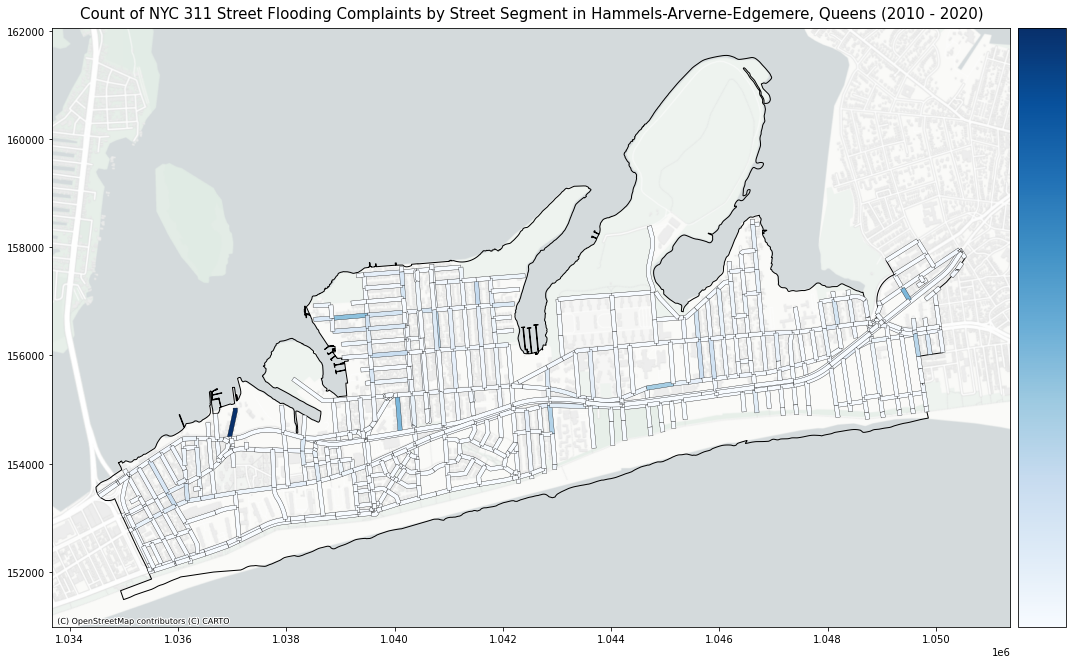

In [392]:
fig, ax = plt.subplots(figsize=(15,15)) # creating figure

# saving variable to format integers as strings with commas
comma_fmt = FuncFormatter(lambda x, p: format(int(x), ','))

# resizing the color bar to scale to the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count', 
                        ax=ax, # plotting on the generated axis
                        cax=cax, # legend of the color bar
                        zorder=2,                        
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True)

nta_shape[nta_shape.ntaname == 'Hammels-Arverne-Edgemere'].plot(ax=ax, 
                                                                zorder=1, 
                                                                color='None', 
                                                                edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of NYC 311 Street Flooding Complaints by Street Segment in Hammels-Arverne-Edgemere, Queens (2010 - 2020)', 
             fontsize=15,
             pad=10)

plt.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

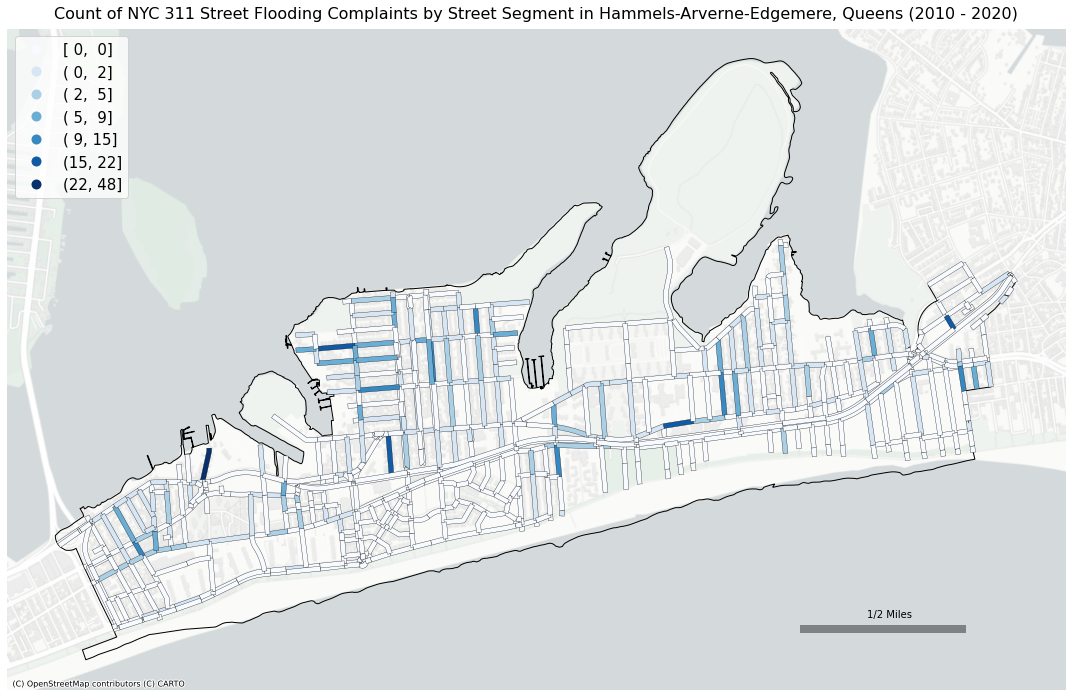

In [393]:
fig, ax = plt.subplots(figsize=(15,15)) # creating figure

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count', 
                        ax=ax, # plotting on the generated axis
                        zorder=2,                        
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True, 
                        scheme='fisherjenks',
                        k=7,
                        legend_kwds={'loc': "upper left", 
                                            'fmt': "{:,.0f}",
                                            'fontsize': "15"})

nta_shape[nta_shape.ntaname == 'Hammels-Arverne-Edgemere'].plot(ax=ax, 
                                                                zorder=1, 
                                                                color='None', 
                                                                edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [1047000, 1047000+5280/2], [152000, 152000]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, 
         zorder=3)

# adding the scale bar text to the line
plt.text(1047000 + (5280/2/2.5), 152000 + 200, '1/2 Miles', dict(size=10))

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of NYC 311 Street Flooding Complaints by Street Segment in Hammels-Arverne-Edgemere, Queens (2010 - 2020)', 
             fontsize=16,
             pad=10)

plt.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

In [394]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 843 entries, 0 to 842
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    843 non-null    object  
 1   st_label      843 non-null    object  
 2   st_name       843 non-null    object  
 3   full_stree    843 non-null    object  
 4   rw_type       843 non-null    object  
 5   rw_type_name  843 non-null    object  
 6   st_width      843 non-null    object  
 7   frm_lvl_co    843 non-null    object  
 8   to_lvl_co     843 non-null    object  
 9   borocode      843 non-null    object  
 10  shape_leng    843 non-null    float64 
 11  geometry      843 non-null    geometry
 12  new_geom      843 non-null    geometry
 13  count         843 non-null    float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 98.8+ KB


In [395]:
streets_with_count['shape_leng'] = streets_with_count.geometry.length

In [396]:
streets_with_count.length.describe()

count     843.000000
mean      765.465404
std       480.935941
min       160.000025
25%       431.234423
50%       662.259194
75%       951.824937
max      4017.618319
dtype: float64

In [397]:
streets_with_count.describe()

shape_leng       count
count   843.000000  843.000000
mean    765.465404    0.820878
std     480.935941    2.776289
min     160.000025    0.000000
25%     431.234423    0.000000
50%     662.259194    0.000000
75%     951.824937    0.000000
max    4017.618319   48.000000

In [398]:
streets_with_count['count_per_100ft'] = (streets_with_count['count'] / streets_with_count['shape_leng']) * 100

streets_with_count.head()

physicalid             st_label         st_name          full_stree rw_type  \
0      92035            BCH 66 ST            B 66             B 66 ST       1   
1      14294            BCH 74 ST            B 74             B 74 ST       1   
2      14034  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE       1   
3     154483  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE       1   
4      92062            BCH 87 ST            B 87             B 87 ST       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
0       Street       42         13        13        4  1150.466181   
1       Street       30         13        13        4  1406.030841   
2       Street       35         13        13        4   628.143830   
3       Street       31         13        13        4   671.861108   
4       Street       24         13        13        4   532.568379   

                                            geometry  \
0  LINESTRING (1041022.181 156864.681, 1040981.69...   
1  LINESTRING (1039173.301 154571.323, 1039121.22...   
2  LINESTRING (1046371.747 155628.532, 1046139.47...   
3  LINESTRING (1041944.905 154892.163, 1041702.46...   
4  LINESTRING (1036423.096 153354.452, 1036408.71...   

                                            new_geom  count  count_per_100ft  
0  POLYGON ((1040941.827 157354.986, 1041021.559 ...    1.0         0.086921  
1  POLYGON ((1039081.367 155188.815, 1039161.087 ...    0.0         0.000000  
2  POLYGON ((1046144.416 155559.902, 1046134.526 ...    0.0         0.000000  
3  POLYGON ((1041715.285 154772.266, 1041689.651 ...    0.0         0.000000  
4  POLYGON ((1036368.829 153537.091, 1036448.590 ...    0.0         0.000000

In [399]:
streets_with_count.describe()

shape_leng       count  count_per_100ft
count   843.000000  843.000000       843.000000
mean    765.465404    0.820878         0.106457
std     480.935941    2.776289         0.347350
min     160.000025    0.000000         0.000000
25%     431.234423    0.000000         0.000000
50%     662.259194    0.000000         0.000000
75%     951.824937    0.000000         0.000000
max    4017.618319   48.000000         4.644650

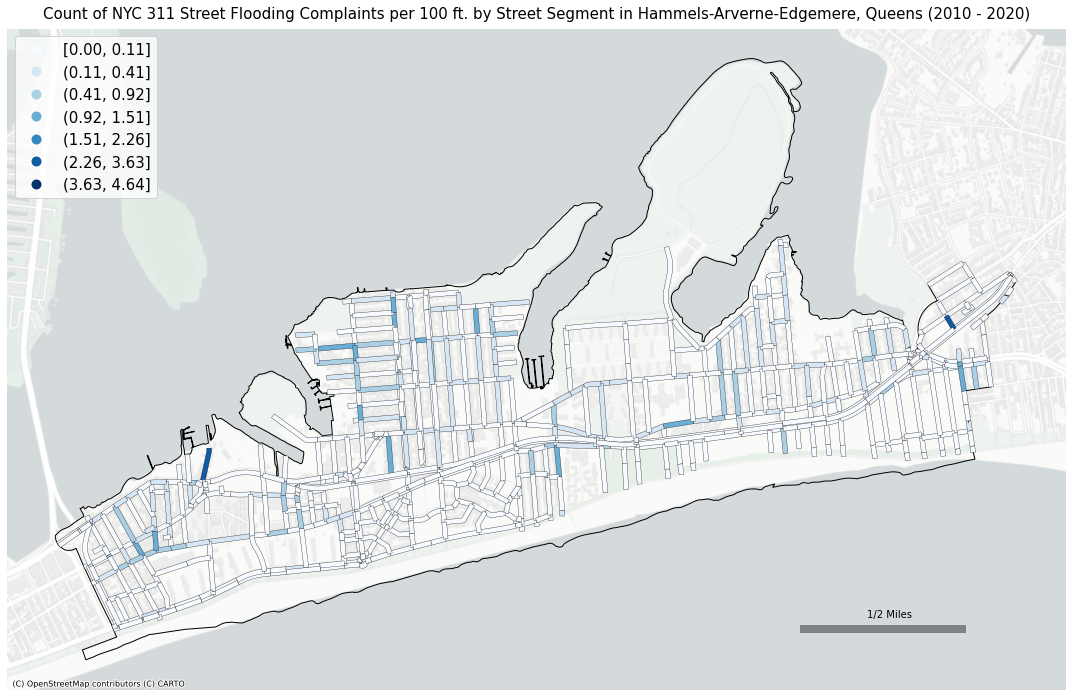

In [400]:
fig, ax = plt.subplots(figsize=(15,15)) # creating figure

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count_per_100ft', 
                        ax=ax, # plotting on the generated axis
                        zorder=2,                        
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True, 
                        scheme='fisherjenks',
                        k=7,
                        legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.2f}",
                                              'fontsize': "15"})

nta_shape[nta_shape.ntaname == 'Hammels-Arverne-Edgemere'].plot(ax=ax, 
                                                                zorder=1, 
                                                                color='None', 
                                                                edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [1047000, 1047000+5280/2], [152000, 152000]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, 
         zorder=3)

# adding the scale bar text to the line
plt.text(1047000 + (5280/2/2.5), 152000 + 200, '1/2 Miles', dict(size=10))

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of NYC 311 Street Flooding Complaints per 100 ft. by Street Segment in Hammels-Arverne-Edgemere, Queens (2010 - 2020)', 
             fontsize=15,
             pad=10)

plt.axis('off')
plt.tight_layout()

plt.savefig('figures/arverne.png')

<AxesSubplot:>

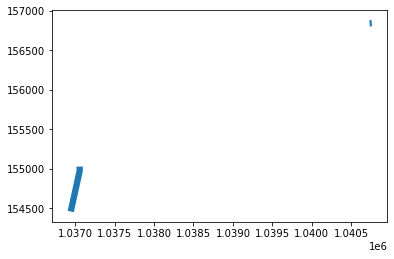

In [401]:
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head(2).plot()

In [402]:
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head()

physicalid     st_label  st_name   full_stree rw_type rw_type_name  \
141      14099   ALMEDA AVE   ALMEDA   ALMEDA AVE       1       Street   
12       89897    BCH 84 ST     B 84      B 84 ST       1       Street   
721     168518    BCH 32 ST     B 32      B 32 ST       1       Street   
289      14115  THURSBY AVE  THURSBY  THURSBY AVE       1       Street   
294      14110  THURSBY AVE  THURSBY  THURSBY AVE       1       Street   

    st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
141       52         13        13        4   215.301494   
12        20         13        13        4  1322.346934   
721       30         13        13        4   670.276012   
289       60         13        13        4   216.157649   
294       58         13        13        4   221.032906   

                                              geometry  \
141  LINESTRING (1040758.199 156843.323, 1040743.30...   
12   LINESTRING (1036945.986 154458.262, 1037059.20...   
721  LINESTRING (1049512.805 157017.705, 1049383.00...   
289  LINESTRING (1040269.040 156052.196, 1040255.64...   
294  LINESTRING (1040815.925 156097.308, 1040800.88...   

                                              new_geom  count  count_per_100ft  
141  POLYGON ((1040746.527 156802.249, 1040746.464 ...   10.0         4.644650  
12   POLYGON ((1037019.120 154979.182, 1037018.204 ...   48.0         3.629910  
721  POLYGON ((1049348.570 157217.010, 1049417.444 ...   22.0         3.282230  
289  POLYGON ((1040258.352 156011.379, 1040258.188 ...    7.0         3.238377  
294  POLYGON ((1040804.822 156056.256, 1040790.137 ...    5.0         2.262107

In [403]:
streets_with_count['count'].sum()

692.0

## New Dorp - Midland Beach, Staten Island

In [404]:
gdf = gpd.GeoDataFrame(flooding_311, 
                       geometry=gpd.points_from_xy(flooding_311.x_coordinate_state_plane, 
                                                   flooding_311.y_coordinate_state_plane))

In [405]:
gdf.head()

unique_key             created_date              closed_date agency  \
0    40140533  2018-08-29T08:35:00.000  2018-09-08T12:40:00.000    DEP   
1    40141782  2018-08-29T10:29:00.000  2018-08-30T09:40:00.000    DEP   
2    40143144  2018-08-29T18:36:00.000  2018-09-01T08:40:00.000    DEP   
3    40145580  2018-08-30T14:58:00.000  2018-09-04T11:25:00.000    DEP   
4    40148030  2018-08-30T19:37:00.000  2018-09-05T08:30:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       10034.0       WEST 206 STREET   
1  Street Flooding (SJ)       11235.0                   NaN   
2  Street Flooding (SJ)       10458.0                   NaN   
3  Street Flooding (SJ)       11204.0                   NaN   
4  Street Flooding (SJ)       11208.0                   NaN   

  intersection_street_2  ... park_borough   latitude  longitude  \
0              9 AVENUE  ...    MANHATTAN  40.863021 -73.917557   
1                   NaN  ...     BROOKLYN  40.592140 -73.943240   
2                   NaN  ...        BRONX  40.864814 -73.892048   
3                   NaN  ...     BROOKLYN  40.623757 -73.988545   
4                   NaN  ...     BROOKLYN  40.684147 -73.873386   

                                            location        incident_address  \
0  {'latitude': '40.8630205', 'longitude': '-73.9...                     NaN   
1  {'latitude': '40.5921398', 'longitude': '-73.9...     2468 EAST 27 STREET   
2  {'latitude': '40.8648137', 'longitude': '-73.8...  2641 BAINBRIDGE AVENUE   
3  {'latitude': '40.6237568', 'longitude': '-73.9...          1701 59 STREET   
4  {'latitude': '40.684147', 'longitude': '-73.87...         103 PINE STREET   

         street_name cross_street_1  cross_street_2           bbl  \
0                NaN            NaN             NaN           NaN   
1     EAST 27 STREET       AVENUE X        AVENUE Y  3.074221e+09   
2  BAINBRIDGE AVENUE       E 194 ST        E 196 ST  2.032940e+09   
3          59 STREET         17 AVE          18 AVE  3.055040e+09   
4        PINE STREET  RIDGEWOOD AVE       FULTON ST  3.041300e+09   

                         geometry  
0  POINT (1007054.000 253710.000)  
1  POINT (1000014.000 155014.000)  
2  POINT (1014109.000 254371.000)  
3   POINT (987430.000 166528.000)  
4  POINT (1019366.000 188555.000)  

[5 rows x 31 columns]

In [406]:
gdf.set_crs(epsg=2263, inplace=True)
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

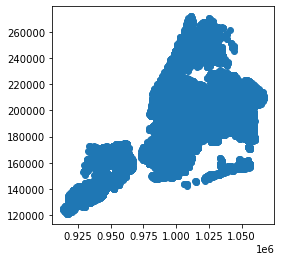

In [407]:
gdf.plot()

In [408]:
gdf.shape

(26874, 31)

In [409]:
gdf.isna().sum()

unique_key                            0
created_date                          0
closed_date                          14
agency                                0
agency_name                           0
complaint_type                        0
descriptor                            0
incident_zip                          0
intersection_street_1             17540
intersection_street_2             17540
address_type                          0
city                                  0
status                                0
resolution_description               12
resolution_action_updated_date        5
community_board                       0
borough                               0
x_coordinate_state_plane              0
y_coordinate_state_plane              0
open_data_channel_type                0
park_facility_name                    0
park_borough                          0
latitude                           2499
longitude                          2499
location                           2499


In [410]:
gdf = gpd.sjoin(gdf, 
                nta_shape, 
                how="inner", 
                op='within')

In [411]:
gdf.head()

unique_key             created_date              closed_date agency  \
0       40140533  2018-08-29T08:35:00.000  2018-09-08T12:40:00.000    DEP   
13      40203741  2018-09-06T18:34:00.000  2018-09-08T12:25:00.000    DEP   
1971    42223076  2019-04-14T10:33:00.000  2019-04-17T11:00:00.000    DEP   
1973    42224479  2019-04-14T10:36:00.000  2019-04-17T11:25:00.000    DEP   
5920    20549194  2011-06-01T07:59:00.000  2011-06-03T16:00:00.000    DEP   

                                 agency_name complaint_type  \
0     Department of Environmental Protection          Sewer   
13    Department of Environmental Protection          Sewer   
1971  Department of Environmental Protection          Sewer   
1973  Department of Environmental Protection          Sewer   
5920  Department of Environmental Protection          Sewer   

                descriptor  incident_zip intersection_street_1  \
0     Street Flooding (SJ)       10034.0       WEST 206 STREET   
13    Street Flooding (SJ)       10034.0              9 AVENUE   
1971  Street Flooding (SJ)       10034.0                   NaN   
1973  Street Flooding (SJ)       10034.0                   NaN   
5920  Street Flooding (SJ)       10034.0       WEST 207 STREET   

     intersection_street_2  ...           bbl                        geometry  \
0                 9 AVENUE  ...           NaN  POINT (1007054.000 253710.000)   
13         WEST 220 STREET  ...           NaN  POINT (1008802.000 256858.000)   
1971                   NaN  ...  1.022268e+09  POINT (1006343.000 254787.000)   
1973                   NaN  ...  1.022260e+09  POINT (1006135.000 254606.000)   
5920           POST AVENUE  ...           NaN  POINT (1006554.000 254361.000)   

     index_right ntacode     shape_area county_fips             ntaname  \
0             80    MN01  17732688.6953         061  Marble Hill-Inwood   
13            80    MN01  17732688.6953         061  Marble Hill-Inwood   
1971          80    MN01  17732688.6953         061  Marble Hill-Inwood   
1973          80    MN01  17732688.6953         061  Marble Hill-Inwood   
5920          80    MN01  17732688.6953         061  Marble Hill-Inwood   

         shape_leng  boro_name boro_code  
0     31844.4094213  Manhattan         1  
13    31844.4094213  Manhattan         1  
1971  31844.4094213  Manhattan         1  
1973  31844.4094213  Manhattan         1  
5920  31844.4094213  Manhattan         1  

[5 rows x 39 columns]

In [412]:
gdf.drop(columns=["shape_leng", 'shape_area'], inplace=True)

In [413]:
ls data/

311-flooding-data.csv  streets_clipped.json


In [414]:
path = 'data/streets_clipped.json'
streets = gpd.read_file(path)

streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [415]:
streets.shape

(99354, 12)

<AxesSubplot:>

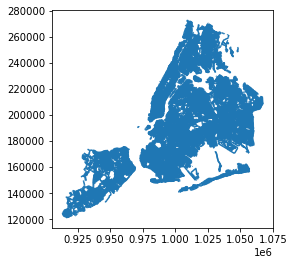

In [416]:
streets.plot()

In [417]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99354 entries, 0 to 99353
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99354 non-null  object  
 1   st_label      99354 non-null  object  
 2   st_name       99354 non-null  object  
 3   full_stree    99354 non-null  object  
 4   rw_type       99354 non-null  object  
 5   rw_type_name  99354 non-null  object  
 6   st_width      99354 non-null  object  
 7   frm_lvl_co    99354 non-null  object  
 8   to_lvl_co     99354 non-null  object  
 9   borocode      99354 non-null  object  
 10  shape_leng    99354 non-null  float64 
 11  geometry      99354 non-null  geometry
dtypes: float64(1), geometry(1), object(10)
memory usage: 9.1+ MB


In [418]:
streets.describe()

shape_leng
count  9.935400e+04
mean   3.431337e+02
std    2.620169e+02
min    1.068681e-08
25%    1.953887e+02
50%    2.648512e+02
75%    4.583294e+02
max    1.509366e+04

In [419]:
streets.geom_type.value_counts()

LineString    99354
dtype: int64

In [420]:
streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [421]:
New_Dorp_Midland_Beach = nta_shape[nta_shape.ntaname == 'New Dorp-Midland Beach']

New_Dorp_Midland_Beach.head()

ntacode     shape_area county_fips                 ntaname     shape_leng  \
95    SI45  55429451.2194         085  New Dorp-Midland Beach  34336.5206382   

        boro_name boro_code                                           geometry  
95  Staten Island         5  MULTIPOLYGON (((960721.609 147492.642, 960370....

In [422]:
# clipping the school points that only fall within the nta shapes
streets_clipped = gpd.clip(streets, New_Dorp_Midland_Beach)

<AxesSubplot:>

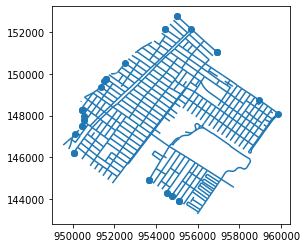

In [423]:
streets_clipped.plot()

In [424]:
streets_clipped.geom_type.value_counts()

LineString            737
Point                  32
GeometryCollection      5
MultiLineString         2
dtype: int64

In [425]:
streets_clipped = streets_clipped[streets_clipped.geom_type == 'LineString']

streets_clipped.geom_type.value_counts()

LineString    737
dtype: int64

In [426]:
# clipping the school points that only fall within the nta shapes
New_Dorp_Midland_Beach = gpd.clip(gdf, New_Dorp_Midland_Beach)

<AxesSubplot:>

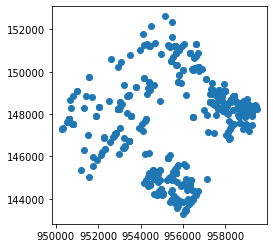

In [427]:
New_Dorp_Midland_Beach.plot()

In [428]:
New_Dorp_Midland_Beach.geom_type.value_counts()

Point    761
dtype: int64

# Snap points to lines

# https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa

In [429]:
streets_clipped.sindex

rtree.index.Index(bounds=[949549.8247149212, 143281.59894616972, 959897.8481633187, 152760.96722404534], size=737)

In [430]:
offset = 80

bbox = New_Dorp_Midland_Beach.bounds + [-offset, -offset, offset, offset]

bbox.head()

minx      miny      maxx      maxy
17   950555.0  147690.0  950715.0  147850.0
471  955928.0  150021.0  956088.0  150181.0
477  958545.0  148428.0  958705.0  148588.0
484  958342.0  148783.0  958502.0  148943.0
581  958536.0  148432.0  958696.0  148592.0

In [431]:
hits = bbox.apply(lambda row: list(streets_clipped.sindex.intersection(row)), axis=1)

hits.head()

17     [269, 505, 564, 110]
471    [668, 656, 717, 418]
477         [186, 473, 341]
484                   [148]
581         [186, 473, 341]
dtype: object

In [432]:
hits.shape

(761,)

In [433]:
tmp = pd.DataFrame(
    # index of points table
    {"pt_idx": np.repeat(hits.index, hits.apply(len)),
        
    # ordinal position of line - access via iloc later
    "line_i": np.concatenate(hits.values)
    })

In [434]:
tmp.head()

pt_idx  line_i
0      17   269.0
1      17   505.0
2      17   564.0
3      17   110.0
4     471   668.0

In [435]:
tmp.shape

(2645, 2)

In [436]:
streets_clipped.shape

(737, 12)

In [437]:
streets_clipped.head()

physicalid        st_label   st_name       full_stree rw_type  \
90       63908  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1   
411      98840     FREMONT AVE   FREMONT      FREMONT AVE       1   
551      64022      HAMDEN AVE    HAMDEN       HAMDEN AVE       1   
581     169350      SANCHEZ DR   SANCHEZ       SANCHEZ DR       1   
651      63915  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1   

    rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
90        Street       30         13        13        5  256.539897   
411       Street       30         13        13        5  447.066950   
551       Street       20         13        13        5   40.275747   
581       Street       18         13        13        5  176.145848   
651       Street       30         13        13        5  261.169357   

                                              geometry  
90   LINESTRING (954781.156 151271.724, 954597.833 ...  
411  LINESTRING (952841.921 150886.337, 953221.730 ...  
551  LINESTRING (957558.853 149344.789, 957591.137 ...  
581  LINESTRING (955726.813 147175.642, 955875.554 ...  
651  LINESTRING (953360.096 149917.140, 953173.390 ...

In [438]:
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(streets_clipped.reset_index(drop=True), on="line_i")

tmp.head()

pt_idx  line_i physicalid    st_label st_name  full_stree rw_type  \
0      17   269.0      89716        3 ST   THIRD    THIRD ST       1   
1      17   505.0      35225   BEACH AVE   BEACH   BEACH AVE       1   
2      17   564.0      89723        3 ST   THIRD    THIRD ST       1   
3      17   110.0      35226   BEACH AVE   BEACH   BEACH AVE       1   
4     471   668.0      15665  HYLAN BLVD   HYLAN  HYLAN BLVD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       30         13        13        5  549.025800   
1       Street       34         13        13        5  209.420359   
2       Street       30         13        13        5  102.153415   
3       Street       30         13        13        5   59.557059   
4       Street       70         13        13        5  305.775123   

                                            geometry  
0  LINESTRING (950899.960 148135.099, 950574.747 ...  
1  LINESTRING (950574.747 147692.758, 950742.430 ...  
2  LINESTRING (950574.747 147692.758, 950510.775 ...  
3  LINESTRING (950527.060 147728.437, 950574.747 ...  
4  LINESTRING (956007.528 150101.076, 955827.781 ...

In [439]:
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(New_Dorp_Midland_Beach.geometry.rename("point"), on="pt_idx")

# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(tmp, geometry="geometry", crs=New_Dorp_Midland_Beach.crs)

tmp.head()

pt_idx  line_i physicalid    st_label st_name  full_stree rw_type  \
0      17   269.0      89716        3 ST   THIRD    THIRD ST       1   
1      17   505.0      35225   BEACH AVE   BEACH   BEACH AVE       1   
2      17   564.0      89723        3 ST   THIRD    THIRD ST       1   
3      17   110.0      35226   BEACH AVE   BEACH   BEACH AVE       1   
4     471   668.0      15665  HYLAN BLVD   HYLAN  HYLAN BLVD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       30         13        13        5  549.025800   
1       Street       34         13        13        5  209.420359   
2       Street       30         13        13        5  102.153415   
3       Street       30         13        13        5   59.557059   
4       Street       70         13        13        5  305.775123   

                                            geometry  \
0  LINESTRING (950899.960 148135.099, 950574.747 ...   
1  LINESTRING (950574.747 147692.758, 950742.430 ...   
2  LINESTRING (950574.747 147692.758, 950510.775 ...   
3  LINESTRING (950527.060 147728.437, 950574.747 ...   
4  LINESTRING (956007.528 150101.076, 955827.781 ...   

                           point  
0  POINT (950635.000 147770.000)  
1  POINT (950635.000 147770.000)  
2  POINT (950635.000 147770.000)  
3  POINT (950635.000 147770.000)  
4  POINT (956008.000 150101.000)

In [440]:
tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))

tmp[['snap_dist']].describe()

snap_dist
count  2645.000000
mean     79.274135
std     111.375609
min       0.000567
25%       0.486597
50%      23.782248
75%      97.963148
max    1119.662091

In [441]:
# Discard any lines that are greater than tolerance from points
tmp = tmp.loc[tmp.snap_dist <= offset]

# Sort on ascending snap distance, so that closest goes to top
tmp = tmp.sort_values(by=["snap_dist"])

tmp.head()

pt_idx  line_i physicalid      st_label   st_name    full_stree rw_type  \
694     6693   292.0      55540  BANCROFT AVE  BANCROFT  BANCROFT AVE       1   
2554   27008   292.0      55540  BANCROFT AVE  BANCROFT  BANCROFT AVE       1   
1960   17607   497.0      64050    CLAWSON ST   CLAWSON    CLAWSON ST       1   
601     6354   668.0      15665    HYLAN BLVD     HYLAN    HYLAN BLVD       1   
662     6604   668.0      15665    HYLAN BLVD     HYLAN    HYLAN BLVD       1   

     rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
694        Street       30         13        13        5  608.866647   
2554       Street       30         13        13        5  608.866647   
1960       Street       32         13        13        5  259.287109   
601        Street       70         13        13        5  305.775123   
662        Street       70         13        13        5  305.775123   

                                               geometry  \
694   LINESTRING (953291.900 149648.075, 953790.042 ...   
2554  LINESTRING (953291.900 149648.075, 953790.042 ...   
1960  LINESTRING (952706.317 146911.440, 952557.581 ...   
601   LINESTRING (956007.528 150101.076, 955827.781 ...   
662   LINESTRING (956007.528 150101.076, 955827.781 ...   

                              point  snap_dist  
694   POINT (953790.000 149298.000)   0.000567  
2554  POINT (953790.000 149298.000)   0.000567  
1960  POINT (952706.000 146911.000)   0.007325  
601   POINT (955828.000 149854.000)   0.007674  
662   POINT (955828.000 149854.000)   0.007674

In [442]:
tmp[['snap_dist']].describe()

snap_dist
count  1646.000000
mean     13.767554
std      23.888730
min       0.000567
25%       0.375417
50%       2.638374
75%       4.028307
max      79.689427

In [443]:
# group by the index of the points and take the first, which is the
# closest line 
closest = tmp.groupby("pt_idx").first()

# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")

closest.head()

line_i physicalid      st_label   st_name    full_stree rw_type  \
pt_idx                                                                    
17       269.0      89716          3 ST     THIRD      THIRD ST       1   
471      656.0      52147   BEDFORD AVE   BEDFORD   BEDFORD AVE       1   
477      473.0      76093  MAPLETON AVE  MAPLETON  MAPLETON AVE       1   
484      148.0      76941    GRIMSBY ST   GRIMSBY    GRIMSBY ST       1   
581      473.0      76093  MAPLETON AVE  MAPLETON  MAPLETON AVE       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
17           Street       30         13        13        5  549.025800   
471          Street       48         13        13        5  395.456745   
477          Street       25         13        13        5  248.849478   
484          Street       22         13        13        5  372.786118   
581          Street       25         13        13        5  248.849478   

                                                 geometry  \
pt_idx                                                      
17      LINESTRING (950899.960 148135.099, 950574.747 ...   
471     LINESTRING (956007.528 150101.076, 956326.746 ...   
477     LINESTRING (958524.695 148581.558, 958726.633 ...   
484     LINESTRING (958533.655 149022.834, 958315.338 ...   
581     LINESTRING (958524.695 148581.558, 958726.633 ...   

                                point  snap_dist  
pt_idx                                            
17      POINT (950635.000 147770.000)   2.790895  
471     POINT (956008.000 150101.000)   0.217017  
477     POINT (958625.000 148508.000)   1.076617  
484     POINT (958422.000 148863.000)   3.099728  
581     POINT (958616.000 148512.000)   3.089971

In [444]:
# Position of nearest point from start of the line
pos = closest.geometry.project(gpd.GeoSeries(closest.point))

# Get new point location geometry
new_pts = closest.geometry.interpolate(pos)

new_pts.head()

pt_idx
17     POINT (950632.751 147771.653)
471    POINT (956007.872 150100.825)
477    POINT (958625.629 148508.874)
484    POINT (958419.487 148864.815)
581    POINT (958617.806 148514.507)
dtype: geometry

In [445]:
# Create a new GeoDataFrame from the columns from the closest line and new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(closest, geometry=new_pts)

snapped.head()

line_i physicalid      st_label   st_name    full_stree rw_type  \
pt_idx                                                                    
17       269.0      89716          3 ST     THIRD      THIRD ST       1   
471      656.0      52147   BEDFORD AVE   BEDFORD   BEDFORD AVE       1   
477      473.0      76093  MAPLETON AVE  MAPLETON  MAPLETON AVE       1   
484      148.0      76941    GRIMSBY ST   GRIMSBY    GRIMSBY ST       1   
581      473.0      76093  MAPLETON AVE  MAPLETON  MAPLETON AVE       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
17           Street       30         13        13        5  549.025800   
471          Street       48         13        13        5  395.456745   
477          Street       25         13        13        5  248.849478   
484          Street       22         13        13        5  372.786118   
581          Street       25         13        13        5  248.849478   

                             geometry                          point  \
pt_idx                                                                 
17      POINT (950632.751 147771.653)  POINT (950635.000 147770.000)   
471     POINT (956007.872 150100.825)  POINT (956008.000 150101.000)   
477     POINT (958625.629 148508.874)  POINT (958625.000 148508.000)   
484     POINT (958419.487 148864.815)  POINT (958422.000 148863.000)   
581     POINT (958617.806 148514.507)  POINT (958616.000 148512.000)   

        snap_dist  
pt_idx             
17       2.790895  
471      0.217017  
477      1.076617  
484      3.099728  
581      3.089971

In [446]:
New_Dorp_Midland_Beach.head()

unique_key             created_date              closed_date agency  \
17     40218870  2018-09-07T18:47:00.000  2018-09-10T09:30:00.000    DEP   
471    40754755  2018-11-06T13:32:00.000  2018-11-08T10:30:00.000    DEP   
477    40755773  2018-11-06T22:26:00.000  2018-11-07T13:30:00.000    DEP   
484    40756624  2018-11-06T16:43:00.000  2018-11-07T14:00:00.000    DEP   
581    40858258  2018-11-09T19:35:00.000  2018-11-09T22:00:00.000    DEP   

                                agency_name complaint_type  \
17   Department of Environmental Protection          Sewer   
471  Department of Environmental Protection          Sewer   
477  Department of Environmental Protection          Sewer   
484  Department of Environmental Protection          Sewer   
581  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
17   Street Flooding (SJ)       10306.0                   NaN   
471  Street Flooding (SJ)       10306.0        BEDFORD AVENUE   
477  Street Flooding (SJ)       10306.0                   NaN   
484  Street Flooding (SJ)       10306.0                   NaN   
581  Street Flooding (SJ)       10306.0                   NaN   

    intersection_street_2  ...   cross_street_1     cross_street_2  \
17                    NaN  ...         ROSS AVE          BEACH AVE   
471       HYLAN BOULEVARD  ...      BEDFORD AVE         HYLAN BLVD   
477                   NaN  ...  FREEBORN STREET  OLYMPIA BOULEVARD   
484                   NaN  ...       HUNTER AVE       MAPLETON AVE   
581                   NaN  ...      FREEBORN ST       OLYMPIA BLVD   

              bbl                       geometry index_right ntacode  \
17   5.042060e+09  POINT (950635.000 147770.000)          95    SI45   
471           NaN  POINT (956008.000 150101.000)          95    SI45   
477           NaN  POINT (958625.000 148508.000)          95    SI45   
484  5.037960e+09  POINT (958422.000 148863.000)          95    SI45   
581  5.038000e+09  POINT (958616.000 148512.000)          95    SI45   

    county_fips                 ntaname      boro_name boro_code  
17          085  New Dorp-Midland Beach  Staten Island         5  
471         085  New Dorp-Midland Beach  Staten Island         5  
477         085  New Dorp-Midland Beach  Staten Island         5  
484         085  New Dorp-Midland Beach  Staten Island         5  
581         085  New Dorp-Midland Beach  Staten Island         5  

[5 rows x 37 columns]

In [447]:
New_Dorp_Midland_Beach.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 761 entries, 17 to 27775
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      761 non-null    int64   
 1   created_date                    761 non-null    object  
 2   closed_date                     761 non-null    object  
 3   agency                          761 non-null    object  
 4   agency_name                     761 non-null    object  
 5   complaint_type                  761 non-null    object  
 6   descriptor                      761 non-null    object  
 7   incident_zip                    761 non-null    float64 
 8   intersection_street_1           216 non-null    object  
 9   intersection_street_2           216 non-null    object  
 10  address_type                    761 non-null    object  
 11  city                            761 non-null    object  
 12  status     

In [448]:
New_Dorp_Midland_Beach.drop(columns=["geometry"], inplace=True)

In [449]:
New_Dorp_Midland_Beach.head()

unique_key             created_date              closed_date agency  \
17     40218870  2018-09-07T18:47:00.000  2018-09-10T09:30:00.000    DEP   
471    40754755  2018-11-06T13:32:00.000  2018-11-08T10:30:00.000    DEP   
477    40755773  2018-11-06T22:26:00.000  2018-11-07T13:30:00.000    DEP   
484    40756624  2018-11-06T16:43:00.000  2018-11-07T14:00:00.000    DEP   
581    40858258  2018-11-09T19:35:00.000  2018-11-09T22:00:00.000    DEP   

                                agency_name complaint_type  \
17   Department of Environmental Protection          Sewer   
471  Department of Environmental Protection          Sewer   
477  Department of Environmental Protection          Sewer   
484  Department of Environmental Protection          Sewer   
581  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
17   Street Flooding (SJ)       10306.0                   NaN   
471  Street Flooding (SJ)       10306.0        BEDFORD AVENUE   
477  Street Flooding (SJ)       10306.0                   NaN   
484  Street Flooding (SJ)       10306.0                   NaN   
581  Street Flooding (SJ)       10306.0                   NaN   

    intersection_street_2  ...      street_name   cross_street_1  \
17                    NaN  ...         3 STREET         ROSS AVE   
471       HYLAN BOULEVARD  ...              NaN      BEDFORD AVE   
477                   NaN  ...  MAPLETON AVENUE  FREEBORN STREET   
484                   NaN  ...   GRIMSBY STREET       HUNTER AVE   
581                   NaN  ...  MAPLETON AVENUE      FREEBORN ST   

        cross_street_2           bbl index_right ntacode county_fips  \
17           BEACH AVE  5.042060e+09          95    SI45         085   
471         HYLAN BLVD           NaN          95    SI45         085   
477  OLYMPIA BOULEVARD           NaN          95    SI45         085   
484       MAPLETON AVE  5.037960e+09          95    SI45         085   
581       OLYMPIA BLVD  5.038000e+09          95    SI45         085   

                    ntaname      boro_name boro_code  
17   New Dorp-Midland Beach  Staten Island         5  
471  New Dorp-Midland Beach  Staten Island         5  
477  New Dorp-Midland Beach  Staten Island         5  
484  New Dorp-Midland Beach  Staten Island         5  
581  New Dorp-Midland Beach  Staten Island         5  

[5 rows x 36 columns]

In [450]:
snapped.head()

line_i physicalid      st_label   st_name    full_stree rw_type  \
pt_idx                                                                    
17       269.0      89716          3 ST     THIRD      THIRD ST       1   
471      656.0      52147   BEDFORD AVE   BEDFORD   BEDFORD AVE       1   
477      473.0      76093  MAPLETON AVE  MAPLETON  MAPLETON AVE       1   
484      148.0      76941    GRIMSBY ST   GRIMSBY    GRIMSBY ST       1   
581      473.0      76093  MAPLETON AVE  MAPLETON  MAPLETON AVE       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
17           Street       30         13        13        5  549.025800   
471          Street       48         13        13        5  395.456745   
477          Street       25         13        13        5  248.849478   
484          Street       22         13        13        5  372.786118   
581          Street       25         13        13        5  248.849478   

                             geometry                          point  \
pt_idx                                                                 
17      POINT (950632.751 147771.653)  POINT (950635.000 147770.000)   
471     POINT (956007.872 150100.825)  POINT (956008.000 150101.000)   
477     POINT (958625.629 148508.874)  POINT (958625.000 148508.000)   
484     POINT (958419.487 148864.815)  POINT (958422.000 148863.000)   
581     POINT (958617.806 148514.507)  POINT (958616.000 148512.000)   

        snap_dist  
pt_idx             
17       2.790895  
471      0.217017  
477      1.076617  
484      3.099728  
581      3.089971

In [451]:
# Join back to the original points:
updated_points = New_Dorp_Midland_Beach.join(snapped)

updated_points.head()

unique_key             created_date              closed_date agency  \
17     40218870  2018-09-07T18:47:00.000  2018-09-10T09:30:00.000    DEP   
471    40754755  2018-11-06T13:32:00.000  2018-11-08T10:30:00.000    DEP   
477    40755773  2018-11-06T22:26:00.000  2018-11-07T13:30:00.000    DEP   
484    40756624  2018-11-06T16:43:00.000  2018-11-07T14:00:00.000    DEP   
581    40858258  2018-11-09T19:35:00.000  2018-11-09T22:00:00.000    DEP   

                                agency_name complaint_type  \
17   Department of Environmental Protection          Sewer   
471  Department of Environmental Protection          Sewer   
477  Department of Environmental Protection          Sewer   
484  Department of Environmental Protection          Sewer   
581  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
17   Street Flooding (SJ)       10306.0                   NaN   
471  Street Flooding (SJ)       10306.0        BEDFORD AVENUE   
477  Street Flooding (SJ)       10306.0                   NaN   
484  Street Flooding (SJ)       10306.0                   NaN   
581  Street Flooding (SJ)       10306.0                   NaN   

    intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
17                    NaN  ...       1       Street       30         13   
471       HYLAN BOULEVARD  ...       1       Street       48         13   
477                   NaN  ...       1       Street       25         13   
484                   NaN  ...       1       Street       22         13   
581                   NaN  ...       1       Street       25         13   

    to_lvl_co borocode  shape_leng                       geometry  \
17         13        5  549.025800  POINT (950632.751 147771.653)   
471        13        5  395.456745  POINT (956007.872 150100.825)   
477        13        5  248.849478  POINT (958625.629 148508.874)   
484        13        5  372.786118  POINT (958419.487 148864.815)   
581        13        5  248.849478  POINT (958617.806 148514.507)   

                             point snap_dist  
17   POINT (950635.000 147770.000)  2.790895  
471  POINT (956008.000 150101.000)  0.217017  
477  POINT (958625.000 148508.000)  1.076617  
484  POINT (958422.000 148863.000)  3.099728  
581  POINT (958616.000 148512.000)  3.089971  

[5 rows x 51 columns]

In [452]:
updated_points.geometry.isna().sum()

5

In [453]:
# You may want to drop any that didn't snap, if so:
updated_points = updated_points.dropna(subset=["geometry"])

updated_points.head()

unique_key             created_date              closed_date agency  \
17     40218870  2018-09-07T18:47:00.000  2018-09-10T09:30:00.000    DEP   
471    40754755  2018-11-06T13:32:00.000  2018-11-08T10:30:00.000    DEP   
477    40755773  2018-11-06T22:26:00.000  2018-11-07T13:30:00.000    DEP   
484    40756624  2018-11-06T16:43:00.000  2018-11-07T14:00:00.000    DEP   
581    40858258  2018-11-09T19:35:00.000  2018-11-09T22:00:00.000    DEP   

                                agency_name complaint_type  \
17   Department of Environmental Protection          Sewer   
471  Department of Environmental Protection          Sewer   
477  Department of Environmental Protection          Sewer   
484  Department of Environmental Protection          Sewer   
581  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
17   Street Flooding (SJ)       10306.0                   NaN   
471  Street Flooding (SJ)       10306.0        BEDFORD AVENUE   
477  Street Flooding (SJ)       10306.0                   NaN   
484  Street Flooding (SJ)       10306.0                   NaN   
581  Street Flooding (SJ)       10306.0                   NaN   

    intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
17                    NaN  ...       1       Street       30         13   
471       HYLAN BOULEVARD  ...       1       Street       48         13   
477                   NaN  ...       1       Street       25         13   
484                   NaN  ...       1       Street       22         13   
581                   NaN  ...       1       Street       25         13   

    to_lvl_co borocode  shape_leng                       geometry  \
17         13        5  549.025800  POINT (950632.751 147771.653)   
471        13        5  395.456745  POINT (956007.872 150100.825)   
477        13        5  248.849478  POINT (958625.629 148508.874)   
484        13        5  372.786118  POINT (958419.487 148864.815)   
581        13        5  248.849478  POINT (958617.806 148514.507)   

                             point snap_dist  
17   POINT (950635.000 147770.000)  2.790895  
471  POINT (956008.000 150101.000)  0.217017  
477  POINT (958625.000 148508.000)  1.076617  
484  POINT (958422.000 148863.000)  3.099728  
581  POINT (958616.000 148512.000)  3.089971  

[5 rows x 51 columns]

In [454]:
updated_points.shape

(756, 51)

In [455]:
updated_points.sort_values(by='snap_dist').head()

unique_key             created_date              closed_date agency  \
27008    39258388  2018-05-22T12:53:00.000  2018-05-23T09:15:00.000    DEP   
6693     21377770  2011-09-06T16:37:00.000  2011-09-07T14:30:00.000    DEP   
17607    27165829  2014-01-16T07:30:00.000  2014-01-17T09:30:00.000    DEP   
6604     21125790  2011-08-28T12:02:00.000  2011-08-28T16:30:00.000    DEP   
6354     21034224  2011-08-14T05:49:00.000  2011-08-14T14:15:00.000    DEP   

                                  agency_name complaint_type  \
27008  Department of Environmental Protection          Sewer   
6693   Department of Environmental Protection          Sewer   
17607  Department of Environmental Protection          Sewer   
6604   Department of Environmental Protection          Sewer   
6354   Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
27008  Street Flooding (SJ)       10306.0         EDISON STREET   
6693   Street Flooding (SJ)       10306.0       BANCROFT AVENUE   
17607  Street Flooding (SJ)       10306.0           ROSS AVENUE   
6604   Street Flooding (SJ)       10306.0        MIDLAND AVENUE   
6354   Street Flooding (SJ)       10306.0       HYLAN BOULEVARD   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
27008       BANCROFT AVENUE  ...       1       Street       30         13   
6693          EDISON STREET  ...       1       Street       30         13   
17607        CLAWSON STREET  ...       1       Street       32         13   
6604        HYLAN BOULEVARD  ...       1       Street       70         13   
6354         MIDLAND AVENUE  ...       1       Street       70         13   

      to_lvl_co borocode  shape_leng                       geometry  \
27008        13        5  608.866647  POINT (953790.000 149298.000)   
6693         13        5  608.866647  POINT (953790.000 149298.000)   
17607        13        5  259.287109  POINT (952706.006 146910.996)   
6604         13        5  305.775123  POINT (955827.994 149854.005)   
6354         13        5  305.775123  POINT (955827.994 149854.005)   

                               point snap_dist  
27008  POINT (953790.000 149298.000)  0.000567  
6693   POINT (953790.000 149298.000)  0.000567  
17607  POINT (952706.000 146911.000)  0.007325  
6604   POINT (955828.000 149854.000)  0.007674  
6354   POINT (955828.000 149854.000)  0.007674  

[5 rows x 51 columns]

In [456]:
updated_points.sort_values(by='snap_dist', ascending=False).head()

unique_key             created_date              closed_date agency  \
22237    32698429  2016-02-16T15:09:00.000  2016-02-18T09:30:00.000    DEP   
7328     22410047  2011-12-28T00:00:00.000  2011-12-28T11:30:00.000    DEP   
7256     22267856  2011-12-06T23:42:00.000  2011-12-07T09:30:00.000    DEP   
24727    36112767  2017-05-05T13:09:00.000  2017-05-05T19:30:00.000    DEP   
10217    45618020  2020-02-14T13:54:00.000  2020-02-14T17:35:00.000    DEP   

                                  agency_name complaint_type  \
22237  Department of Environmental Protection          Sewer   
7328   Department of Environmental Protection          Sewer   
7256   Department of Environmental Protection          Sewer   
24727  Department of Environmental Protection          Sewer   
10217  Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
22237  Street Flooding (SJ)       10306.0                   NaN   
7328   Street Flooding (SJ)       10306.0                   NaN   
7256   Street Flooding (SJ)       10306.0                   NaN   
24727  Street Flooding (SJ)       10306.0                   NaN   
10217  Street Flooding (SJ)       10306.0                   NaN   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
22237                   NaN  ...       1       Street       30         13   
7328                    NaN  ...       1       Street       26         13   
7256                    NaN  ...       1       Street       26         13   
24727                   NaN  ...       1       Street       34         13   
10217                   NaN  ...       1       Street       30         13   

      to_lvl_co borocode  shape_leng                       geometry  \
22237        13        5  172.488718  POINT (950303.664 147302.727)   
7328         13        5  415.175106  POINT (951590.059 149773.632)   
7256         13        5  415.175106  POINT (951590.059 149773.632)   
24727        13        5  877.651987  POINT (954455.655 152137.781)   
10217        13        5  380.747823  POINT (959115.406 147207.210)   

                               point  snap_dist  
22237  POINT (950345.000 147352.000)  64.315603  
7328   POINT (951564.000 149728.000)  52.548002  
7256   POINT (951564.000 149728.000)  52.548002  
24727  POINT (954484.000 152178.000)  49.203561  
10217  POINT (959133.000 147195.000)  21.415827  

[5 rows x 51 columns]

In [457]:
updated_points[['snap_dist']].describe()

snap_dist
count  756.000000
mean     2.833596
std      4.662350
min      0.000567
25%      0.471728
50%      2.815858
75%      3.256435
max     64.315603

Text(0.5, 1.0, 'Histogram of snap_dist (ft.)')

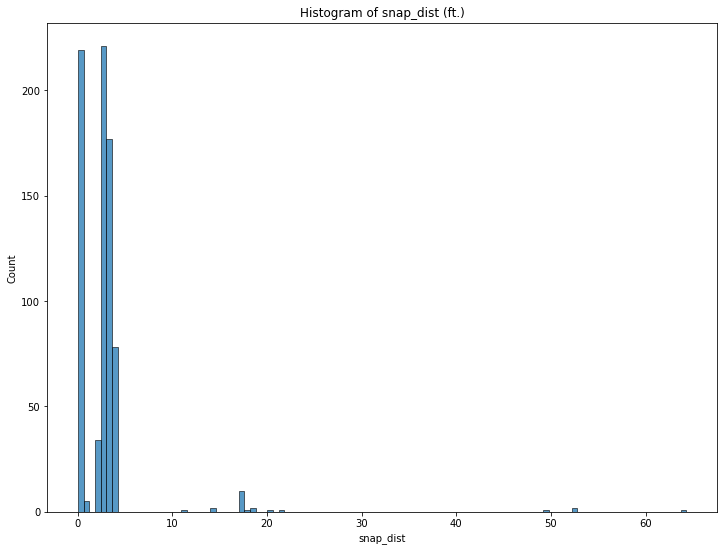

In [458]:
plt.figure(figsize=(12, 9))

sns.histplot(updated_points.snap_dist)
plt.title('Histogram of snap_dist (ft.)')

In [459]:
updated_points.iloc[:, 30:45].head()

index_right ntacode county_fips                 ntaname      boro_name  \
17            95    SI45         085  New Dorp-Midland Beach  Staten Island   
471           95    SI45         085  New Dorp-Midland Beach  Staten Island   
477           95    SI45         085  New Dorp-Midland Beach  Staten Island   
484           95    SI45         085  New Dorp-Midland Beach  Staten Island   
581           95    SI45         085  New Dorp-Midland Beach  Staten Island   

    boro_code  line_i physicalid      st_label   st_name    full_stree  \
17          5   269.0      89716          3 ST     THIRD      THIRD ST   
471         5   656.0      52147   BEDFORD AVE   BEDFORD   BEDFORD AVE   
477         5   473.0      76093  MAPLETON AVE  MAPLETON  MAPLETON AVE   
484         5   148.0      76941    GRIMSBY ST   GRIMSBY    GRIMSBY ST   
581         5   473.0      76093  MAPLETON AVE  MAPLETON  MAPLETON AVE   

    rw_type rw_type_name st_width frm_lvl_co  
17        1       Street       30         13  
471       1       Street       48         13  
477       1       Street       25         13  
484       1       Street       22         13  
581       1       Street       25         13

In [460]:
updated_points.physicalid.value_counts()

76941     115
52067      51
63880      40
76093      30
85564      27
         ... 
173628      1
52145       1
52270       1
52150       1
52272       1
Name: physicalid, Length: 188, dtype: int64

In [461]:
updated_points.loc[updated_points.physicalid == '76941'].iloc[:, 30:45].head()

index_right ntacode county_fips                 ntaname      boro_name  \
484            95    SI45         085  New Dorp-Midland Beach  Staten Island   
731            95    SI45         085  New Dorp-Midland Beach  Staten Island   
949            95    SI45         085  New Dorp-Midland Beach  Staten Island   
1474           95    SI45         085  New Dorp-Midland Beach  Staten Island   
1747           95    SI45         085  New Dorp-Midland Beach  Staten Island   

     boro_code  line_i physicalid    st_label  st_name  full_stree rw_type  \
484          5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
731          5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
949          5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
1474         5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
1747         5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   

     rw_type_name st_width frm_lvl_co  
484        Street       22         13  
731        Street       22         13  
949        Street       22         13  
1474       Street       22         13  
1747       Street       22         13

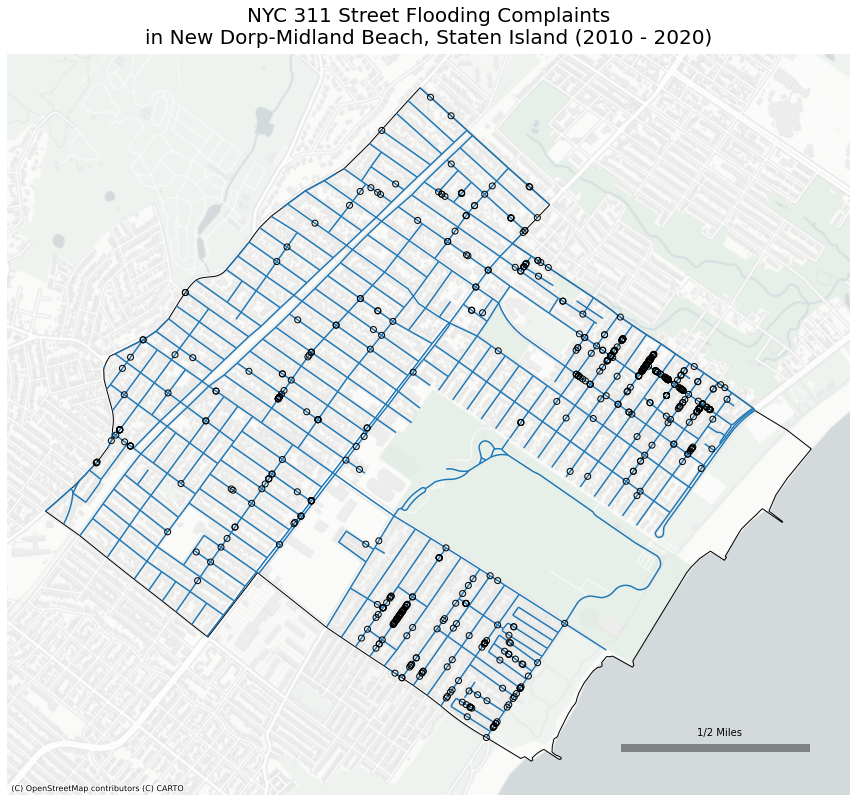

In [462]:
fig, ax = plt.subplots(figsize=(12, 12)) # creating a figure

updated_points.plot(color='none', 
                edgecolor='black',
                ax=ax,
                zorder=3)

streets_clipped.plot(ax=ax, zorder=2)

nta_shape[nta_shape.ntaname == 'New Dorp-Midland Beach'].plot(ax=ax, 
                                                              zorder=1, 
                                                              color='None', 
                                                              edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [958000, 958000+5280/2], [143000 + 130, 143000 + 130]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, zorder=3)

# adding the scale bar text to the line
plt.text(958000 + (5280/2/2.5), 143000 + 300, '1/2 Miles', dict(size=10))

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('NYC 311 Street Flooding Complaints\nin New Dorp-Midland Beach, Staten Island (2010 - 2020)', 
             fontsize=20, 
             pad=10)

plt.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

In [463]:
gdf_count = updated_points.groupby(by='physicalid')['created_date'].count().reset_index()

In [464]:
gdf_count.head()

physicalid  created_date
0     100411             1
1     100451             1
2     100452             2
3     100795             1
4     100822             8

In [465]:
gdf_count.rename(columns={"created_date": "count"}, inplace=True)

In [466]:
gdf_count.head()

physicalid  count
0     100411      1
1     100451      1
2     100452      2
3     100795      1
4     100822      8

In [467]:
streets_clipped.set_geometry('geometry', inplace=True)

In [468]:
streets_clipped.geom_type.value_counts()

LineString    737
dtype: int64

In [469]:
streets_clipped['new_geom'] = streets_clipped.geometry.buffer(40, cap_style=2)

streets_clipped.set_geometry('new_geom', inplace=True)

In [470]:
streets_clipped.head()

physicalid        st_label   st_name       full_stree rw_type  \
90       63908  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1   
411      98840     FREMONT AVE   FREMONT      FREMONT AVE       1   
551      64022      HAMDEN AVE    HAMDEN       HAMDEN AVE       1   
581     169350      SANCHEZ DR   SANCHEZ       SANCHEZ DR       1   
651      63915  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1   

    rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
90        Street       30         13        13        5  256.539897   
411       Street       30         13        13        5  447.066950   
551       Street       20         13        13        5   40.275747   
581       Street       18         13        13        5  176.145848   
651       Street       30         13        13        5  261.169357   

                                              geometry  \
90   LINESTRING (954781.156 151271.724, 954597.833 ...   
411  LINESTRING (952841.921 150886.337, 953221.730 ...   
551  LINESTRING (957558.853 149344.789, 957591.137 ...   
581  LINESTRING (955726.813 147175.642, 955875.554 ...   
651  LINESTRING (953360.096 149917.140, 953173.390 ...   

                                              new_geom  
90   POLYGON ((954625.814 151063.681, 954569.851 15...  
411  POLYGON ((953242.830 150684.493, 953200.630 15...  
551  POLYGON ((957615.053 149352.770, 957567.220 14...  
581  POLYGON ((955854.127 147303.776, 955896.981 14...  
651  POLYGON ((953201.360 149705.923, 953145.420 14...

In [471]:
streets_clipped.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 737 entries, 90 to 99335
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    737 non-null    object  
 1   st_label      737 non-null    object  
 2   st_name       737 non-null    object  
 3   full_stree    737 non-null    object  
 4   rw_type       737 non-null    object  
 5   rw_type_name  737 non-null    object  
 6   st_width      737 non-null    object  
 7   frm_lvl_co    737 non-null    object  
 8   to_lvl_co     737 non-null    object  
 9   borocode      737 non-null    object  
 10  shape_leng    737 non-null    float64 
 11  geometry      737 non-null    geometry
 12  new_geom      737 non-null    geometry
dtypes: float64(1), geometry(2), object(10)
memory usage: 80.6+ KB


In [472]:
# joining our nta population data to our nta shapes data
streets_with_count = streets_clipped.merge(gdf_count, 
                                           left_on='physicalid', 
                                           right_on='physicalid', 
                                           how='left')

In [473]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 737 entries, 0 to 736
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    737 non-null    object  
 1   st_label      737 non-null    object  
 2   st_name       737 non-null    object  
 3   full_stree    737 non-null    object  
 4   rw_type       737 non-null    object  
 5   rw_type_name  737 non-null    object  
 6   st_width      737 non-null    object  
 7   frm_lvl_co    737 non-null    object  
 8   to_lvl_co     737 non-null    object  
 9   borocode      737 non-null    object  
 10  shape_leng    737 non-null    float64 
 11  geometry      737 non-null    geometry
 12  new_geom      737 non-null    geometry
 13  count         188 non-null    float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 86.4+ KB


In [474]:
streets_with_count['count'].fillna(0, inplace=True)

In [475]:
streets_with_count[['count']].isna().sum()

count    0
dtype: int64

In [476]:
streets_with_count.head()

physicalid        st_label   st_name       full_stree rw_type rw_type_name  \
0      63908  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1       Street   
1      98840     FREMONT AVE   FREMONT      FREMONT AVE       1       Street   
2      64022      HAMDEN AVE    HAMDEN       HAMDEN AVE       1       Street   
3     169350      SANCHEZ DR   SANCHEZ       SANCHEZ DR       1       Street   
4      63915  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1       Street   

  st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       30         13        13        5  256.539897   
1       30         13        13        5  447.066950   
2       20         13        13        5   40.275747   
3       18         13        13        5  176.145848   
4       30         13        13        5  261.169357   

                                            geometry  \
0  LINESTRING (954781.156 151271.724, 954597.833 ...   
1  LINESTRING (952841.921 150886.337, 953221.730 ...   
2  LINESTRING (957558.853 149344.789, 957591.137 ...   
3  LINESTRING (955726.813 147175.642, 955875.554 ...   
4  LINESTRING (953360.096 149917.140, 953173.390 ...   

                                            new_geom  count  
0  POLYGON ((954625.814 151063.681, 954569.851 15...    0.0  
1  POLYGON ((953242.830 150684.493, 953200.630 15...    0.0  
2  POLYGON ((957615.053 149352.770, 957567.220 14...    0.0  
3  POLYGON ((955854.127 147303.776, 955896.981 14...    0.0  
4  POLYGON ((953201.360 149705.923, 953145.420 14...    0.0

In [477]:
streets_with_count.sort_values(by='count', ascending=False).head()

physicalid      st_label   st_name    full_stree rw_type rw_type_name  \
148      76941    GRIMSBY ST   GRIMSBY    GRIMSBY ST       1       Street   
574      52067    KISWICK ST   KISWICK    KISWICK ST       1       Street   
252      63880      WEED AVE      WEED      WEED AVE       1       Street   
473      76093  MAPLETON AVE  MAPLETON  MAPLETON AVE       1       Street   
118      85564      BADEN PL     BADEN      BADEN PL       1       Street   

    st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
148       22         13        13        5  372.786118   
574       38         13        13        5  549.294789   
252       32         13        13        5  766.375339   
473       25         13        13        5  248.849478   
118       32         13        13        5  454.064519   

                                              geometry  \
148  LINESTRING (958533.655 149022.834, 958315.338 ...   
574  LINESTRING (958113.203 149295.665, 957794.955 ...   
252  LINESTRING (954903.616 145334.160, 954463.348 ...   
473  LINESTRING (958524.695 148581.558, 958726.633 ...   
118  LINESTRING (959135.084 148145.979, 958868.434 ...   

                                              new_geom  count  
148  POLYGON ((958347.761 148697.237, 958282.915 14...  115.0  
574  POLYGON ((957827.558 148824.781, 957762.353 14...   51.0  
252  POLYGON ((954496.089 144683.889, 954430.607 14...   40.0  
473  POLYGON ((958750.008 148468.598, 958703.259 14...   30.0  
118  POLYGON ((958900.810 147754.966, 958836.058 14...   27.0

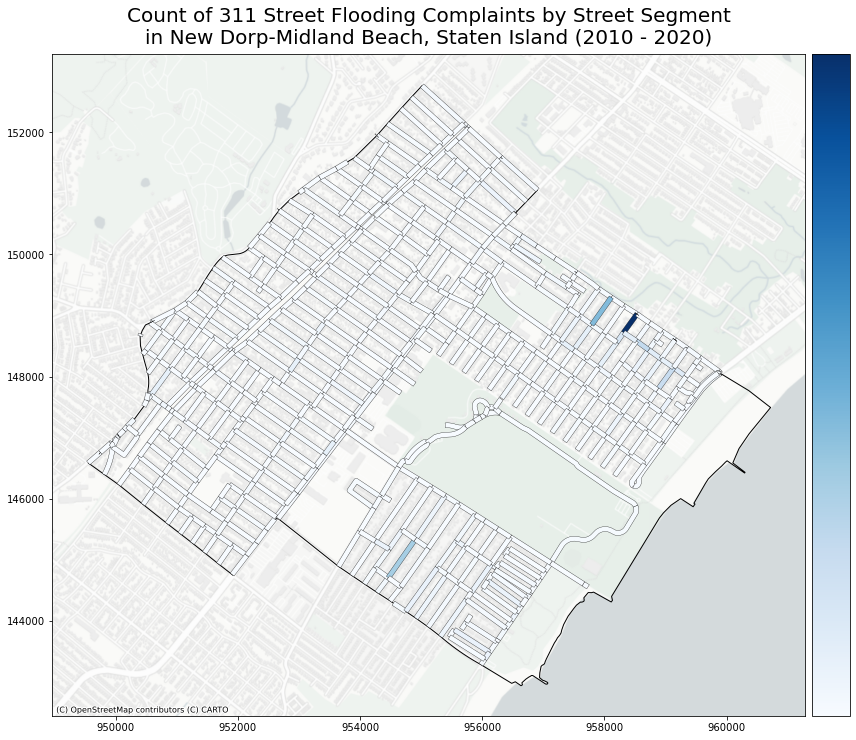

In [478]:
fig, ax = plt.subplots(figsize=(12, 12)) # creating figure

# saving variable to format integers as strings with commas
comma_fmt = FuncFormatter(lambda x, p: format(int(x), ','))

# resizing the color bar to scale to the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count', 
                        ax=ax, # plotting on the generated axis
                        cax=cax, # legend of the color bar
                        zorder=2,                        
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True)

nta_shape[nta_shape.ntaname == 'New Dorp-Midland Beach'].plot(ax=ax, 
                                                              zorder=1, 
                                                              color='None', 
                                                              edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)


ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of 311 Street Flooding Complaints by Street Segment\nin New Dorp-Midland Beach, Staten Island (2010 - 2020)', 
             fontsize=20, 
             pad=10)

plt.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

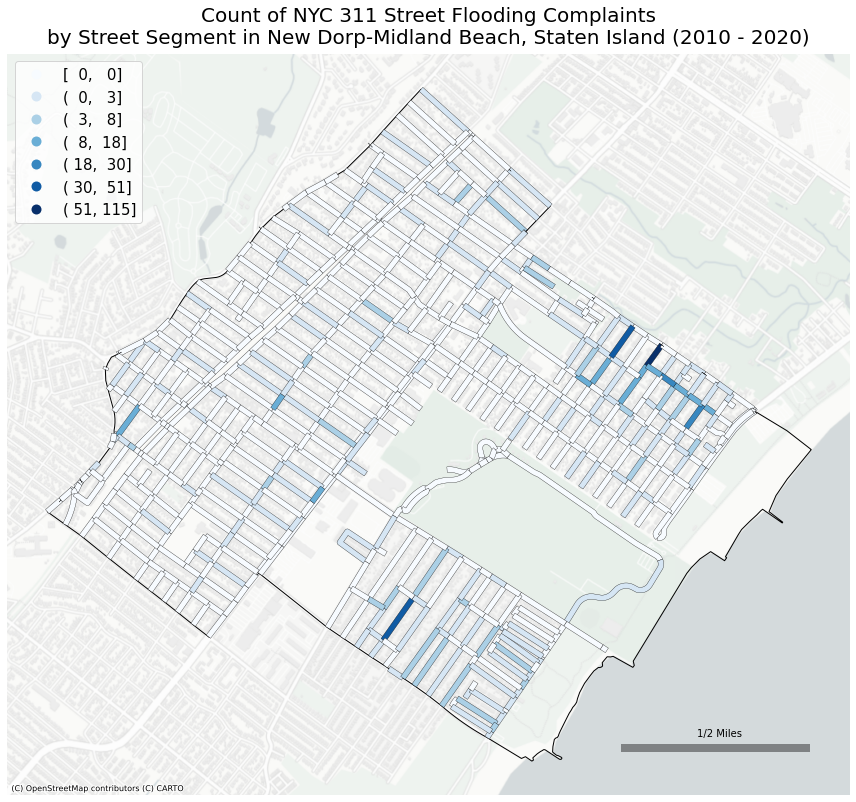

In [479]:
fig, ax = plt.subplots(figsize=(12, 12)) # creating figure

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count', 
                        ax=ax, # plotting on the generated axis
                        zorder=2,
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True, 
                        scheme='fisherjenks',
                        k=7,
                        legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.0f}",
                                              'fontsize': "15"})

nta_shape[nta_shape.ntaname == 'New Dorp-Midland Beach'].plot(ax=ax, 
                                                              zorder=1, 
                                                              color='None', 
                                                              edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [958000, 958000+5280/2], [143000 + 130, 143000 + 130]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, zorder=3)

# adding the scale bar text to the line
plt.text(958000 + (5280/2/2.5), 143000 + 300, '1/2 Miles', dict(size=10))


ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of NYC 311 Street Flooding Complaints\nby Street Segment in New Dorp-Midland Beach, Staten Island (2010 - 2020)', 
             fontsize=20, 
             pad=10)

plt.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

In [480]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 737 entries, 0 to 736
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    737 non-null    object  
 1   st_label      737 non-null    object  
 2   st_name       737 non-null    object  
 3   full_stree    737 non-null    object  
 4   rw_type       737 non-null    object  
 5   rw_type_name  737 non-null    object  
 6   st_width      737 non-null    object  
 7   frm_lvl_co    737 non-null    object  
 8   to_lvl_co     737 non-null    object  
 9   borocode      737 non-null    object  
 10  shape_leng    737 non-null    float64 
 11  geometry      737 non-null    geometry
 12  new_geom      737 non-null    geometry
 13  count         737 non-null    float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 86.4+ KB


In [481]:
streets_with_count['shape_leng'] = streets_with_count.geometry.length

In [482]:
streets_with_count.length.describe()

count     737.000000
mean      852.519540
std       464.511570
min       160.000006
25%       657.049620
50%       689.688260
75%      1084.789133
max      5557.842467
dtype: float64

In [483]:
streets_with_count.describe()

shape_leng       count
count   737.000000  737.000000
mean    852.519540    1.025780
std     464.511570    5.337331
min     160.000006    0.000000
25%     657.049620    0.000000
50%     689.688260    0.000000
75%    1084.789133    1.000000
max    5557.842467  115.000000

In [484]:
streets_with_count['count_per_100ft'] = (streets_with_count['count'] / streets_with_count['shape_leng']) * 100

streets_with_count.head()

physicalid        st_label   st_name       full_stree rw_type rw_type_name  \
0      63908  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1       Street   
1      98840     FREMONT AVE   FREMONT      FREMONT AVE       1       Street   
2      64022      HAMDEN AVE    HAMDEN       HAMDEN AVE       1       Street   
3     169350      SANCHEZ DR   SANCHEZ       SANCHEZ DR       1       Street   
4      63915  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1       Street   

  st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
0       30         13        13        5   673.079794   
1       30         13        13        5  1054.133640   
2       20         13        13        5   240.551494   
3       18         13        13        5   512.291697   
4       30         13        13        5   682.338714   

                                            geometry  \
0  LINESTRING (954781.156 151271.724, 954597.833 ...   
1  LINESTRING (952841.921 150886.337, 953221.730 ...   
2  LINESTRING (957558.853 149344.789, 957591.137 ...   
3  LINESTRING (955726.813 147175.642, 955875.554 ...   
4  LINESTRING (953360.096 149917.140, 953173.390 ...   

                                            new_geom  count  count_per_100ft  
0  POLYGON ((954625.814 151063.681, 954569.851 15...    0.0              0.0  
1  POLYGON ((953242.830 150684.493, 953200.630 15...    0.0              0.0  
2  POLYGON ((957615.053 149352.770, 957567.220 14...    0.0              0.0  
3  POLYGON ((955854.127 147303.776, 955896.981 14...    0.0              0.0  
4  POLYGON ((953201.360 149705.923, 953145.420 14...    0.0              0.0

In [485]:
streets_with_count.describe()

shape_leng       count  count_per_100ft
count   737.000000  737.000000       737.000000
mean    852.519540    1.025780         0.119050
std     464.511570    5.337331         0.584439
min     160.000006    0.000000         0.000000
25%     657.049620    0.000000         0.000000
50%     689.688260    0.000000         0.000000
75%    1084.789133    1.000000         0.056918
max    5557.842467  115.000000        12.699153

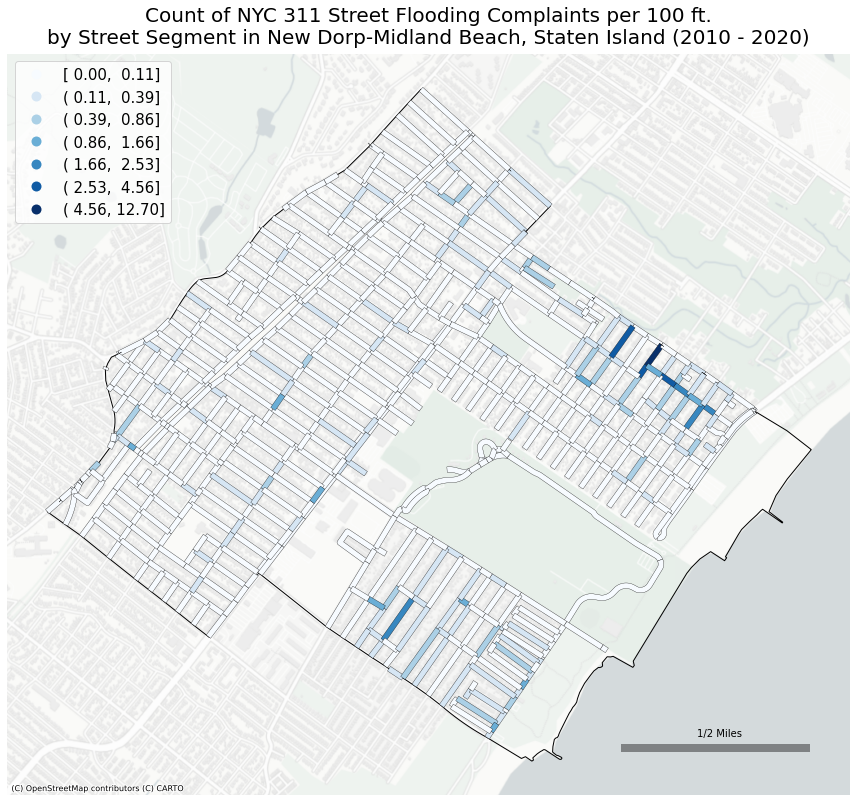

In [486]:
fig, ax = plt.subplots(figsize=(12, 12)) # creating figure

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count_per_100ft', 
                        ax=ax, # plotting on the generated axis
                        zorder=2,
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True, 
                        scheme='fisherjenks',
                        k=7,
                        legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.2f}",
                                              'fontsize': "15"})

nta_shape[nta_shape.ntaname == 'New Dorp-Midland Beach'].plot(ax=ax, 
                                                              zorder=1, 
                                                              color='None', 
                                                              edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [958000, 958000+5280/2], [143000 + 130, 143000 + 130]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, zorder=3)

# adding the scale bar text to the line
plt.text(958000 + (5280/2/2.5), 143000 + 300, '1/2 Miles', dict(size=10))

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of NYC 311 Street Flooding Complaints per 100 ft.\nby Street Segment in New Dorp-Midland Beach, Staten Island (2010 - 2020)', 
             fontsize=20, 
             pad=10)

plt.axis('off')
plt.tight_layout()

plt.savefig('figures/midland-beach.png')

<AxesSubplot:>

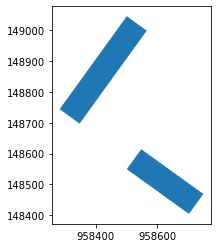

In [487]:
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head(2).plot()

In [488]:
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head()

physicalid      st_label   st_name    full_stree rw_type rw_type_name  \
148      76941    GRIMSBY ST   GRIMSBY    GRIMSBY ST       1       Street   
473      76093  MAPLETON AVE  MAPLETON  MAPLETON AVE       1       Street   
574      52067    KISWICK ST   KISWICK    KISWICK ST       1       Street   
52       76942    GRIMSBY ST   GRIMSBY    GRIMSBY ST       1       Street   
118      85564      BADEN PL     BADEN      BADEN PL       1       Street   

    st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
148       22         13        13        5   905.572235   
473       25         13        13        5   657.698955   
574       38         13        13        5  1258.589579   
52        32         13        13        5   554.966971   
118       32         13        13        5  1068.129038   

                                              geometry  \
148  LINESTRING (958533.655 149022.834, 958315.338 ...   
473  LINESTRING (958524.695 148581.558, 958726.633 ...   
574  LINESTRING (958113.203 149295.665, 957794.955 ...   
52   LINESTRING (958315.338 148720.663, 958202.776 ...   
118  LINESTRING (959135.084 148145.979, 958868.434 ...   

                                              new_geom  count  count_per_100ft  
148  POLYGON ((958347.761 148697.237, 958282.915 14...  115.0        12.699153  
473  POLYGON ((958750.008 148468.598, 958703.259 14...   30.0         4.561357  
574  POLYGON ((957827.558 148824.781, 957762.353 14...   51.0         4.052155  
52   POLYGON ((958235.642 148535.600, 958169.910 14...   18.0         3.243436  
118  POLYGON ((958900.810 147754.966, 958836.058 14...   27.0         2.527784

In [489]:
streets_with_count['count'].sum()

756.0